In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyscf import ao2mo,gto, scf

from typing import Tuple


# qiskit
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, NELDER_MEAD
from qiskit.algorithms import MinimumEigensolverResult

from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance
from qiskit.quantum_info.operators import Operator
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit.opflow.primitive_ops import PauliOp, PauliSumOp
from qiskit.quantum_info import Pauli, SparsePauliOp

# qiskit nature
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)

from qiskit_nature.settings import settings
settings.dict_aux_operators = True

#from qiskit import IBMQ
#from qiskit_nature.runtime import VQEClient
#from qiskit.providers.ibmq import least_busy
#from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session

# useful??
#from qiskit_nature.algorithms import (GroundStateEigensolver,
#                                      NumPyMinimumEigensolverFactory)
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.opflow import TwoQubitReduction

def get_molecular_integrals(molecule):
    '''
    Calculates the 1-electron and 2-electron integrals.
    
    Args:   
        molecule : Mole 
            Ccorresponds to the molecule.
            
    Returns:
        h1_MO : ndarray
                Tensor corresponding to the 1-electron integral in the molecular basis.
        
        h2_MO : ndarray
                Tensor corresponding to the 2-electron integral in the molecular basis.

        n_particles: Tuple[int, int]
            Number of alpha and beta electrons.
        
        num_orb : int 
            Number of orbitals.

        nuclear_repulsion_energy : float
            Nuclear repulsion energy.
    '''
    
    mf = scf.RHF(molecule).run()

    # computing the 1e and 2e AO (atomic orbitals) integrals 
    h1 = molecule.intor_symmetric("int1e_nuc") + molecule.intor_symmetric("int1e_kin") 
    h2 = molecule.intor("int2e")
    # comment : add aosym (axis of symmetry) ???

    # transformations from AO to MO (molecular orbitals)
    h1_MO = np.einsum('pi,pq,qj->ij', mf.mo_coeff, h1, mf.mo_coeff)
    h2_MO = ao2mo.get_mo_eri(h2, mf.mo_coeff)

    #h2_MO = ao2mo.kernel(mol_h2, mf.mo_coeff, aosym="1") #alternative

    nuclear_repulsion_energy=molecule.energy_nuc()
    num_particles = molecule.nelec
    num_orb = h1.shape[0]

    return h1_MO, h2_MO, num_particles, num_orb, nuclear_repulsion_energy


def get_qubit_op(coordinates):
    '''
    Calculates the Hamiltonian as the sum of Pauli operators as a function
    of the coordinates of the atoms.
    
    Args:
        coordinates : ndarray
            Array containing the positions of the atoms constituing the molecule.
        
    
    Returns:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
    '''
    
    mol = gto.M(
                atom = [['H',(coordinates[0], coordinates[1], 0.0)], 
                        ['H',(coordinates[2], coordinates[3], 0.0)],
                        ['H',(coordinates[4], coordinates[5], 0.0)]],
                basis = 'sto3g',
                charge = 1,
                spin = 0,
                symmetry = True,
                verbose = 2 # control the print level of PySCF globally
    )

    h1_MO,h2_MO,nelec,norb,ecore = get_molecular_integrals(mol)

    # Define an ElectronicEnergy instance containing the 1e and 2e integrals
    electronic_energy = ElectronicEnergy.from_raw_integrals(
            h1_MO, ao2mo.restore(1, h2_MO, norb)
        )
    electronic_energy.nuclear_repulsion_energy = ecore

    # Define an ElectronicStructureProblem
    problem = ElectronicStructureProblem(electronic_energy)

    second_q_ops = problem.second_q_ops()     # get second quantized operators
    problem.num_spatial_orbitals = norb  # define number of orbitals
    problem.num_particles = nelec        # define number of particles 
    
    problem.basis = ElectronicBasis.MO 
    
    problem.molecule=MoleculeInfo(symbols=[mol.atom_symbol(i) for i in range(mol.nbas)], 
                                  coords=mol.atom_coords())
    FC_transformer=FreezeCoreTransformer(freeze_core=True)
    problem = FC_transformer.transform(problem)
    
    # TODO we need to give info about the molecule to use FreezeCoreTransformer 
    # question : how to do it in a smart way ? at the initialization ??
    
    hamiltonian = second_q_ops[0]  # Set electronic part of Hamiltonian
    hamiltonian = (hamiltonian + FermionicOp({"": ecore}, num_spin_orbitals=norb)) # add Nuclear Repulsion Energy
    #print("Hamiltonian :\n", hamiltonian) # print for checking purposes
    
    mapper = ParityMapper()  # Set Mapper
    
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    qubit_op = converter.convert(hamiltonian, nelec)
    #print("q_op :\n", qubit_op) # print for checking purposes
    

    return qubit_op, nelec, norb, problem, converter

def calc_ground_state(qubit_op,nelec,norb,problem,converter) :
    '''
    Calculates the ground state and the ground energy of the Hamiltonian.
    
    Args:
        qubit_op : PauliSumOp
            Sum of Pauli operators corresponding to the Hamiltonian.
        
        nelec : Tuple[int, int]
            Number of alpha and beta electrons.
        
        norb : int 
            Number of orbitals.
            
        problem : ElectronicStructureProblem
        
        converter : QubitConverter
        
    
    Returns:
        ground_state : CircuitStateFn
            Ground state of the Hamiltonian.
            
        min_eng : float
            Ground energy of the Hamiltonian.
    '''

    backend = BasicAer.get_backend("statevector_simulator")
    quantum_instance = QuantumInstance(backend)
    optimizer = SLSQP(maxiter=400)

    init_state = HartreeFock(num_spatial_orbitals=norb, 
                                num_particles=nelec, 
                                qubit_converter=converter
                            )
    
    var_form = UCCSD(qubit_converter=converter,
                        num_particles=nelec,
                        num_spatial_orbitals=norb, 
                        initial_state=init_state
                        )

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    min_eng = vqe_result.eigenvalue.real
    final_params = vqe_result.optimal_parameters 

    vqe_ground = vqe.ansatz.bind_parameters(final_params) 
#     vqe_ground_state = CircuitStateFn(vqe_ground)
    
    return vqe_ground, min_eng

In [2]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.01 #removed the angst, since coordinates are given in angst


from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import time #to see which part of code takes the longest
import multiprocessing


def expectation_exact(psi_0,op):
    
    return psi_0.adjoint().compose(op).compose(psi_0).eval().real
    
    
    



#calculate centre of mass (currently for equal particle masses)
def calc_COM(coordinates):
    #print(coordinates)
    r_array = np.array_split(coordinates,3)
    COM = (r_array[0] + r_array[1] + r_array[2])/3
    
    return COM

#task to calculate expectation value
def task1(string, q_instance, psi_0):

    Obs = PauliOp(Pauli(string))
    measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
    expectation = PauliExpectation().convert(measurable_expression)  
    sampler = CircuitSampler(q_instance).convert(expectation) 
    E = sampler.eval().real
    E_ex = expectation_exact(psi_0,Obs)
        
    return (E,E_ex)

#task to calculate operator from coordinates
def task2(coordinates):
    
    #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
    (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0])
    #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
    (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[1])
        
    qubit_op_plus = qubit_op_plus #TODO:number of I's needs to be changed according to number of qubits
    qubit_op_minus = qubit_op_minus
       
    #op =  (-(qubit_op_plus - qubit_op_minus)).reduce()
    op =  -(qubit_op_plus - qubit_op_minus)

                    
    op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
    #print(op_list)    
    #construct dict from list
    op_dict = {}
    for (PauliString,coeff) in op_list:

        if PauliString in op_dict:
            op_dict[PauliString] += coeff
        else:
            op_dict[PauliString] = coeff
    
    return op, op_dict
 
def parallel_operators(coordinates,basis_set):
    
    
    coordinate_list = []
    
    v0_normed = basis_set[0]
    v0_orth = basis_set[1]
    
    v1_normed = basis_set[2]
    v1_orth = basis_set[3]

    v2_normed = basis_set[4]
    v2_orth = basis_set[5]
    
    displ_coords_0_a = np.array([v0_normed[0]*dR,v0_normed[1]*dR,0,0,0,0])
    displ_coords_0_b = np.array([v0_orth[0]*dR,v0_orth[1]*dR,0,0,0,0])
    displ_coords_1_a = np.array([0,0,v1_normed[0]*dR,v1_normed[1]*dR,0,0])
    displ_coords_1_b = np.array([0,0,v1_orth[0]*dR,v1_orth[1]*dR,0,0])
    displ_coords_2_a = np.array([0,0,0,0,v2_normed[0]*dR,v2_normed[1]*dR])
    displ_coords_2_b = np.array([0,0,0,0,v2_orth[0]*dR,v2_orth[1]*dR])
    #print(displ_coords_0_a)
    #print(displ_coords_0_b)
    #print(displ_coords_1_a)
    #print(displ_coords_1_b)
    #print(displ_coords_2_a)
    #print(displ_coords_2_b)

    coordinate_list.append([coordinates + displ_coords_0_a,coordinates - displ_coords_0_a])
    coordinate_list.append([coordinates + displ_coords_0_b,coordinates - displ_coords_0_b])
    coordinate_list.append([coordinates + displ_coords_1_a,coordinates - displ_coords_1_a])
    coordinate_list.append([coordinates + displ_coords_1_b,coordinates - displ_coords_1_b])
    coordinate_list.append([coordinates + displ_coords_2_a,coordinates - displ_coords_2_a])
    coordinate_list.append([coordinates + displ_coords_2_b,coordinates - displ_coords_2_b])
    
    #dR_list = v0_normed.tolist() + v1_normed.tolist() + v2_normed.tolist()
    
    dR_list = [dR,dR,dR,dR,dR,dR]
    #print(dR_list)
    #for i in range(len(coordinates)):
        
        #coordinate_list.append([coordinates[0:i]+[(coordinates[i]+dR_list[i])]+coordinates[i+1:],coordinates[0:i]+[(coordinates[i]-dR_list[i])]+coordinates[i+1:]])
    
    #print(coordinate_list)
    with multiprocessing.Pool() as pool:
         ops,op_coeffs = zip(*pool.map(task2, coordinate_list))
    
    #print(ops)
    return ops, op_coeffs

def sequential_operators(coordinates):
    ops = []
    op_coeffs = []
    
    for i in range(len(coordinates)):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  -(qubit_op_plus - qubit_op_minus).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        ops.append(op)
        op_coeffs.append(op_dict)
    #print(ops)
    return ops, op_coeffs

def parallel_expectations(exp_dict_exact, exp_dict, op_set, q_instance, psi_0):

    triples = []
    for op in op_set:
        triple = (op,q_instance,psi_0)
        triples.append(triple)

    Es = 0
    with multiprocessing.Pool() as pool:
        Es,E_ex = zip(*pool.starmap(task1, triples))
        #print(Es)
        #print(E_ex)
        #Es,E_ex = pool.starmap(task1, triples)
    for i in range(len(Es)):
        
        exp_dict[triples[i][0]]=Es[i]
        exp_dict_exact[triples[i][0]]=E_ex[i]
                       
    return 0

def sequential_expectations(exp_dict, op_set, q_instance, psi_0):

    for pauli_string in op_set:
        
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
        exp_dict[pauli_string] = E

    return 0

def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter)
    
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 128, basis_set_this=None):
  
    
    if simulator == 'qasm':
            backend = Aer.get_backend('qasm_simulator')
            #backend.set_options(max_job_size=1, executor = euler_client)
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "exact":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)   
    
    start = time.time()
    

    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    
    end = time.time()
    
    
    time_psi_0 = end - start
    #print("Took " + str(time_psi_0) + " s to calculate the ground state")
    forces = np.zeros(num_coord)
    forces_exact = np.zeros(num_coord)
    coordinates = coordinates.tolist()
    
    
    coordinates_this = np.array(coordinates)
    COM = calc_COM(coordinates_this)
    coords = np.array_split(coordinates_this,3)
    #print(coords)
    #print(COM)
    v0 = coords[0] - COM
    v1 = coords[1] - COM
    v2 = coords[2] - COM
    
    v0_normed = np.array(v0/np.sqrt(v0[0]**2+v0[1]**2))
    v0_orth = np.array([v0_normed[1],-v0_normed[0]])
    
    v1_normed = np.array(v1/np.sqrt(v1[0]**2+v1[1]**2))
    v1_orth = np.array([v1_normed[1],-v1_normed[0]])

    v2_normed = np.array(v2/np.sqrt(v2[0]**2+v2[1]**2))
    v2_orth = np.array([v2_normed[1],-v2_normed[0]])
    
    #rotated basis
    if basis_set_this == "rotated":
        basis_set = [v0_normed,v0_orth,v1_normed,v1_orth,v2_normed,v2_orth]
    #cartesian basis
    elif basis_set_this == "cartesian":
        basis_set = [[1,0],[0,1],[1,0],[0,1],[1,0],[0,1]]
    
    #basis_set = basis_set_this

    transform_matrix = np.array([[basis_set[0][0],basis_set[1][0],0,0,0,0],
                                 [basis_set[0][1],basis_set[1][1],0,0,0,0],
                                 [0,0,basis_set[2][0],basis_set[3][0],0,0],
                                 [0,0,basis_set[2][1],basis_set[3][1],0,0],
                                 [0,0,0,0,basis_set[4][0],basis_set[5][0]],
                                 [0,0,0,0,basis_set[4][1],basis_set[5][1]]])
    
    transform_matrix_inv = np.linalg.inv(transform_matrix)
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons)
    #replace parallel_ with sequential_ to see effect of parallelization
    force_ops,force_op_coeffs = parallel_operators(coordinates,basis_set)
    
    #for ops in force_ops:
        #print(len(ops))
        
    P1 = force_ops[0]
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
        
            P_prod = (P1@P1)
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    start = time.time()
    exp_dict = {} # dictionary with relevant expectation values
    exp_dict_exact = {}  # dictionary with exact relevant expectation values
        
    #switch between parallel_ and sequential_ to see the effect
    
    parallel_expectations(exp_dict_exact,exp_dict,pauli_op_set,q_instance,psi_0)
    

    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op]
            forces_exact[i] += coeff.real*exp_dict_exact[pauli_op]
    
    #forces[1] = 0
    #forces[3] = 0
    #forces[5] = 0
    
    if basis_set_this == "rotated":
        forces_return = np.matmul(transform_matrix,np.array(forces))
    elif basis_set_this == "cartesian":
        forces_return = forces
        
    #print(forces)
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):

            Pij = force_ops[i]@force_ops[j]
                
            Pij_list = Pij.primitive.to_list()

            #add product expectation 
            
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict_exact[pauli_string]
                    #subtract 
            COV[i,j] -= forces_exact[i]*forces_exact[j]
            
            
            #since COV is symmetric
            
            if i < j:
                COV[j,i] = COV[i,j]
            
            
                
    #print(COV)            
    end = time.time()
    
    if basis_set_this == "rotated":
        #print(COV)
        COV_1 = np.matmul(COV,transform_matrix)
        COV_2 = np.matmul(transform_matrix_inv,COV_1)
        COV_return = COV_2
        #COV_return = COV
        #print(COV_return)
    elif basis_set_this == "cartesian":    
        COV_return = COV
        
    time_cov = end - start

    print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    #print(COV)
    
    return forces_return*Ha*(1/(2*dR*angst)),COV_return*(Ha*(1/(2*dR*angst)))**2

In [3]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def calc_COM(coordinates):
    #print(coordinates)
    r_array = np.array_split(coordinates,3)
    COM = (r_array[0] + r_array[1] + r_array[2])/3
    
    return COM

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))

    


def main():
    
    f = open("temperatures_exact_32000.txt","w")
    
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    
    mass = mass_0

    #distances between atoms
    d = 0.8
    #rotation angle of the initial triangle
    b = 0/180*np.pi
    
    #initial positions of atoms, arrangement = equilateral triangle
    x1_init = np.array([-d/2*np.cos(b)+np.sin(b)*np.sqrt(3)/6*d,-d/2*np.sin(b)-np.cos(b)*np.sqrt(3)/6*d])+np.array([0,d*np.sqrt(3)/6])
    x2_init = np.array([d/2*np.cos(b)+np.sin(b)*np.sqrt(3)/6*d,d/2*np.sin(b)-np.cos(b)*np.sqrt(3)/6*d])+np.array([0,d*np.sqrt(3)/6])
    x3_init = np.array([-np.sin(b)*np.sqrt(3)/3*d,np.cos(b)*np.sqrt(3)/3*d])+np.array([0,d*np.sqrt(3)/6])
    
    
    init_pos0 = x1_init
    init_pos1 = x2_init
    init_pos2 = x3_init
    
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)
    
    ##initialize velocities in the direction of the COM for each particle
    
    COM = calc_COM(init_pos)
    
    c0 = COM - init_pos0
    c1 = COM - init_pos1
    c2 = COM - init_pos2
    
    dir0 = c0/np.sqrt(c0[0]**2+c0[1]**2)
    dir1 = c1/np.sqrt(c1[0]**2+c1[1]**2)
    dir2 = c2/np.sqrt(c2[0]**2+c2[1]**2)

    v_init_mag = 5e2

    v_init = np.concatenate((dir0,dir1,dir2),axis=None)*v_init_mag
    
    

    #integrator timesteps
    
    timeB = 0
    timeE = 100
    times = np.arange(timeB*femto, timeE*femto, dt)
    
    
    #print(times)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
        
    delta = 0.2*dt
    
    temperature = []
    #hold v_next
    
    v_next = None
    
    simulator = 'qasm'
    COM = calc_COM(init_pos)
    coords_loc = np.array_split(init_pos,3)
    forces_array = []
    velocities_array = []
    velocities_array.append(v_init.tolist())
    coords_array = []
    coords_array.append(init_pos.tolist())
    
    n_dof = 3
    
    #"cartesian" or "rotated"
    
    basis_set = "rotated"
    
    diag_elems = []
    
    shots = 128000
    
    for time in tqdm(times, desc='Progress: '):
        
        #time = 0
        
        r = coords[-1]
        #print(r)
        
        (forces,COV) = calc_force_and_cov(r, simulator = simulator, shots = shots, basis_set_this=basis_set)
        #diag_elems.append(COV[0][0])
        #print(diag_elems)
        
        forces_array.append(forces.tolist())
        
        f1 = distance(np.array([forces[0],forces[1]]),np.array([0,0]))
        
        f2 = distance(np.array([forces[2],forces[3]]),np.array([0,0]))
        
        f3 = distance(np.array([forces[4],forces[5]]),np.array([0,0]))    
        
        print("f0,f1,f2 = " + str([f1,f2,f3]))
        
        
        if time == 0:
            
            v_sample = v_init
            
            velocities = np.array(np.array_split(v_sample,3))
            
            kin_eng = np.sum(velocities**2*mass/2, axis=1)
            
            k_T = 2*np.sum(kin_eng)/np.size(kin_eng)/n_dof
            
            temperature.append(k_T/k_b)
            k_T = k_b * T
            #print(temperature)
            
            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        else:
            
            v_sample = v_next
            
            velocities = np.array(np.array_split(v_sample,3))
            
            kin_eng = np.sum(velocities**2*mass/2, axis=1)
            
            k_T = 2*np.sum(kin_eng)/np.size(kin_eng)/n_dof
            
            temperature.append(k_T/k_b)
            
            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)
            
            coords.append(r_next)
            
        velocities_array.append(v_next.tolist())  
        coords_array.append(coords[-1].tolist())
        
        r = np.array_split(coords[-1],3)
        d01 = distance(r[0],r[1])
        d02 = distance(r[0],r[2])
        d12 = distance(r[1],r[2])
        print("d01,d02,d12 = " + str([d01,d02,d12]))
        print("Temp:" + str(temperature[-1]) + "K")
        print(temperature[-1])
        
        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        
    timess = times.tolist()
    timess.append(timeE*femto)
    
    #f.write('diagonal elements for n = ' + str(shots) + " no of shots" + '\n')
    #f.write(str(diag_elems))
    
    
    f.write('times \n')
    f.write(str(timess) + "\n")
    f.write("coordinates \n")
    f.write(str(coords_array) + "\n")
    f.write("velocities \n")
    f.write(str(velocities_array) + "\n")
    f.write("forces \n")
    f.write(str(forces_array) + "\n")
    f.write("temperatures \n")
    f.write(str(temperature) + "\n")
    
    return (distance01,distance02,distance12,times) 

Progress:   0%|          | 1/500 [00:17<2:24:42, 17.40s/it]

Time to: Calculate Ground State - 1.89s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 8.28s, Calculate Covariance - 1.82s
f0,f1,f2 = [1.0679620840905575e-08, 1.0679620840913809e-08, 1.0679620840902846e-08]
d01,d02,d12 = [0.802776247050774, 0.8027762470507761, 0.8027762470507729]
Temp:10.079793334057628K
10.079793334057628


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   0%|          | 2/500 [00:33<2:17:32, 16.57s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 4.21s, Calculate Pauli Expectation Values - 9.04s, Calculate Covariance - 1.74s
f0,f1,f2 = [1.1624817849028975e-08, 1.162481784904277e-08, 1.1624817849041346e-08]
d01,d02,d12 = [0.8083579663358307, 0.8083579663358198, 0.808357966335876]
Temp:25.89682926556018K
25.89682926556018


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   1%|          | 3/500 [00:48<2:13:32, 16.12s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.43s, Calculate Pauli Expectation Values - 8.48s, Calculate Covariance - 1.62s
f0,f1,f2 = [1.2555465966179864e-08, 1.2555465966193122e-08, 1.2555465966196505e-08]
d01,d02,d12 = [0.8181483276888692, 0.8181483276888823, 0.8181483276890056]
Temp:104.6806367292516K
104.6806367292516


Progress:   1%|          | 4/500 [01:08<2:25:33, 17.61s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 8.21s, Calculate Pauli Expectation Values - 8.14s, Calculate Covariance - 2.22s
f0,f1,f2 = [1.1772333746112265e-08, 1.1772333746149988e-08, 1.1772333746149736e-08]
d01,d02,d12 = [0.8322554338054465, 0.8322554338055134, 0.8322554338057012]
Temp:322.0533463662095K
322.0533463662095


Progress:   1%|          | 5/500 [01:26<2:24:08, 17.47s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.84s, Calculate Pauli Expectation Values - 9.85s, Calculate Covariance - 1.49s
f0,f1,f2 = [1.0442170251673854e-08, 1.0442170251732987e-08, 1.044217025166488e-08]
d01,d02,d12 = [0.8503038492220669, 0.8503038492221638, 0.8503038492224553]
Temp:668.6613788726894K
668.6613788726894


Progress:   1%|          | 6/500 [01:45<2:28:27, 18.03s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 7.74s, Calculate Pauli Expectation Values - 7.89s, Calculate Covariance - 2.17s
f0,f1,f2 = [7.239852337008202e-09, 7.2398523369921406e-09, 7.239852336988454e-09]
d01,d02,d12 = [0.8710529491187957, 0.8710529491189227, 0.8710529491193052]
Temp:1094.4817646645752K
1094.4817646645752


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   1%|▏         | 7/500 [02:01<2:23:19, 17.44s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.79s, Calculate Pauli Expectation Values - 7.9s, Calculate Covariance - 2.51s
f0,f1,f2 = [7.4326226059979535e-09, 7.432622605990762e-09, 7.43262260598267e-09]
d01,d02,d12 = [0.8946243410551828, 0.894624341055337, 0.8946243410558141]
Temp:1446.5348340340884K
1446.5348340340884


Progress:   2%|▏         | 8/500 [02:16<2:18:04, 16.84s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.92s, Calculate Pauli Expectation Values - 8.11s, Calculate Covariance - 1.44s
f0,f1,f2 = [4.84298088090782e-09, 4.842980880870423e-09, 4.842980880864914e-09]
d01,d02,d12 = [0.9199767693180928, 0.9199767693182799, 0.9199767693188275]
Temp:1866.8130646218597K
1866.8130646218597


Progress:   2%|▏         | 9/500 [02:32<2:15:15, 16.53s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 4.86s, Calculate Pauli Expectation Values - 7.76s, Calculate Covariance - 1.95s
f0,f1,f2 = [3.425100843267498e-09, 3.4251008432202527e-09, 3.425100843245426e-09]
d01,d02,d12 = [0.9465394103969156, 0.9465394103971361, 0.9465394103977438]
Temp:2159.581001386758K
2159.581001386758


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   2%|▏         | 10/500 [02:48<2:11:52, 16.15s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 4.02s, Calculate Pauli Expectation Values - 7.91s, Calculate Covariance - 2.26s
f0,f1,f2 = [1.8363727582473174e-09, 1.836372758230988e-09, 1.8363727582318109e-09]
d01,d02,d12 = [0.9736636960969981, 0.9736636960972465, 0.9736636960979133]
Temp:2370.6797016125606K
2370.6797016125606


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   2%|▏         | 11/500 [03:04<2:11:06, 16.09s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.65s, Calculate Pauli Expectation Values - 8.17s, Calculate Covariance - 2.06s
f0,f1,f2 = [1.1984543432768163e-09, 1.1984543432049177e-09, 1.1984543432100818e-09]
d01,d02,d12 = [1.0010896355528773, 1.0010896355531709, 1.001089635553877]
Temp:2471.9916159030663K
2471.9916159030663


Progress:   2%|▏         | 12/500 [03:18<2:07:37, 15.69s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 4.31s, Calculate Pauli Expectation Values - 7.95s, Calculate Covariance - 1.73s
f0,f1,f2 = [6.52551444743937e-10, 6.525514448065049e-10, 6.52551444768427e-10]
d01,d02,d12 = [1.0280515958489678, 1.0280515958493206, 1.0280515958500485]
Temp:2527.28022412288K
2527.28022412288


Progress:   3%|▎         | 13/500 [03:34<2:06:20, 15.56s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 4.58s, Calculate Pauli Expectation Values - 7.99s, Calculate Covariance - 1.58s
f0,f1,f2 = [1.6713843747733354e-09, 1.6713843747936228e-09, 1.6713843747862793e-09]
d01,d02,d12 = [1.0541233739235067, 1.0541233739239142, 1.0541233739246663]
Temp:2442.4928596987065K
2442.4928596987065


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   3%|▎         | 14/500 [03:53<2:14:49, 16.65s/it]

Time to: Calculate Ground State - 1.45s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 10.41s, Calculate Covariance - 2.14s
f0,f1,f2 = [3.0645397097367576e-09, 3.06453970975178e-09, 3.064539709806074e-09]
d01,d02,d12 = [1.078719811707467, 1.0787198117079253, 1.0787198117086871]
Temp:2283.871550015601K
2283.871550015601


Progress:   3%|▎         | 15/500 [04:09<2:13:59, 16.58s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 4.25s, Calculate Pauli Expectation Values - 8.65s, Calculate Covariance - 2.25s
f0,f1,f2 = [3.5650244839389847e-09, 3.565024483964954e-09, 3.5650244839782965e-09]
d01,d02,d12 = [1.1016203622480694, 1.1016203622485954, 1.1016203622493548]
Temp:2032.707089003242K
2032.707089003242


Progress:   3%|▎         | 16/500 [04:25<2:11:18, 16.28s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 4.77s, Calculate Pauli Expectation Values - 7.86s, Calculate Covariance - 1.87s
f0,f1,f2 = [2.4833161965650486e-09, 2.4833161965990065e-09, 2.4833161965907074e-09]
d01,d02,d12 = [1.123256892691447, 1.123256892692043, 1.123256892692803]
Temp:1762.066194984775K
1762.066194984775


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   3%|▎         | 17/500 [04:42<2:12:22, 16.44s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 8.23s, Calculate Covariance - 2.37s
f0,f1,f2 = [3.6871896711935053e-09, 3.687189671176607e-09, 3.6871896711960617e-09]
d01,d02,d12 = [1.143112075335575, 1.1431120753362387, 1.1431120753370156]
Temp:1572.9163012607273K
1572.9163012607273


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   4%|▎         | 18/500 [04:57<2:09:02, 16.06s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.29s, Calculate Pauli Expectation Values - 8.03s, Calculate Covariance - 1.78s
f0,f1,f2 = [4.79278700686421e-09, 4.792787006828402e-09, 4.792787006881377e-09]
d01,d02,d12 = [1.1607039123603786, 1.1607039123610898, 1.160703912361925]
Temp:1324.579855668382K
1324.579855668382


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   4%|▍         | 19/500 [05:14<2:11:23, 16.39s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.14s, Calculate Pauli Expectation Values - 9.5s, Calculate Covariance - 2.17s
f0,f1,f2 = [5.135223829227965e-09, 5.135223829217047e-09, 5.135223829168224e-09]
d01,d02,d12 = [1.1758541800986373, 1.1758541800993998, 1.175854180100313]
Temp:1039.8070533366076K
1039.8070533366076


Progress:   4%|▍         | 20/500 [05:30<2:10:31, 16.32s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 4.61s, Calculate Pauli Expectation Values - 8.54s, Calculate Covariance - 2.08s
f0,f1,f2 = [5.858555581213408e-09, 5.8585555812322235e-09, 5.858555581201131e-09]
d01,d02,d12 = [1.188211859492125, 1.1882118594929896, 1.1882118594939524]
Temp:771.2070460901858K
771.2070460901858


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   4%|▍         | 21/500 [05:45<2:06:45, 15.88s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.45s, Calculate Pauli Expectation Values - 7.69s, Calculate Covariance - 1.41s
f0,f1,f2 = [6.021008849676274e-09, 6.021008849730519e-09, 6.0210088497210426e-09]
d01,d02,d12 = [1.1976269378702784, 1.1976269378712585, 1.197626937872251]
Temp:513.1026062412565K
513.1026062412565


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   4%|▍         | 22/500 [06:01<2:07:16, 15.98s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 7.99s, Calculate Covariance - 1.86s
f0,f1,f2 = [5.920000956226263e-09, 5.920000956254551e-09, 5.920000956265166e-09]
d01,d02,d12 = [1.2040015456188842, 1.2040015456200162, 1.2040015456209867]
Temp:297.8367283731977K
297.8367283731977


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   5%|▍         | 23/500 [06:17<2:07:11, 16.00s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.21s, Calculate Pauli Expectation Values - 8.42s, Calculate Covariance - 2.41s
f0,f1,f2 = [5.84552001972889e-09, 5.845520019748905e-09, 5.845520019722086e-09]
d01,d02,d12 = [1.2070870258059934, 1.207087025807264, 1.2070870258082111]
Temp:136.53289713809474K
136.53289713809474


Progress:   5%|▍         | 24/500 [06:35<2:11:53, 16.63s/it]

Time to: Calculate Ground State - 1.43s, Get Pauli Ops - 4.38s, Calculate Pauli Expectation Values - 10.41s, Calculate Covariance - 1.87s
f0,f1,f2 = [6.545257615777276e-09, 6.545257615774103e-09, 6.545257615768307e-09]
d01,d02,d12 = [1.2056712426681655, 1.2056712426694578, 1.2056712426705218]
Temp:31.987175798623145K
31.987175798623145


Progress:   5%|▌         | 25/500 [06:54<2:16:42, 17.27s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 7.74s, Calculate Pauli Expectation Values - 7.74s, Calculate Covariance - 2.15s
f0,f1,f2 = [5.514853863503468e-09, 5.514853863486836e-09, 5.514853863543863e-09]
d01,d02,d12 = [1.2058588294706376, 1.2058588294718846, 1.2058588294730208]
Temp:6.734786677881594K
6.734786677881594


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   5%|▌         | 26/500 [07:09<2:11:16, 16.62s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 3.87s, Calculate Pauli Expectation Values - 7.8s, Calculate Covariance - 2.37s
f0,f1,f2 = [6.500193446053291e-09, 6.500193446073583e-09, 6.500193446075348e-09]
d01,d02,d12 = [1.1739801168617192, 1.1739801168645383, 1.1739801168640047]
Temp:0.11823197231409392K
0.11823197231409392


Progress:   5%|▌         | 27/500 [07:25<2:10:08, 16.51s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 7.93s, Calculate Covariance - 1.85s
f0,f1,f2 = [4.378722458939053e-09, 4.3787224589230106e-09, 4.378722458917107e-09]
d01,d02,d12 = [1.1404568731854101, 1.1404568731897924, 1.1404568731876037]
Temp:3414.537778789835K
3414.537778789835


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   6%|▌         | 28/500 [07:41<2:07:21, 16.19s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.28s, Calculate Pauli Expectation Values - 7.91s, Calculate Covariance - 2.19s
f0,f1,f2 = [4.419231470940897e-09, 4.419231470865921e-09, 4.419231470962371e-09]
d01,d02,d12 = [1.1052630716725025, 1.1052630716784202, 1.1052630716745824]
Temp:3775.9170139984208K
3775.9170139984208


Progress:   6%|▌         | 29/500 [07:56<2:05:45, 16.02s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 4.74s, Calculate Pauli Expectation Values - 8.12s, Calculate Covariance - 1.79s
f0,f1,f2 = [4.3695918195372295e-09, 4.369591819553683e-09, 4.369591819573264e-09]
d01,d02,d12 = [1.0684087068597914, 1.0684087068672194, 1.0684087068617554]
Temp:4161.622988321311K
4161.622988321311


Progress:   6%|▌         | 30/500 [08:17<2:16:45, 17.46s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 7.37s, Calculate Pauli Expectation Values - 10.62s, Calculate Covariance - 1.89s
f0,f1,f2 = [3.0347041049103054e-09, 3.03470410485696e-09, 3.034704104880888e-09]
d01,d02,d12 = [1.030439905600892, 1.0304399056098172, 1.0304399056027596]
Temp:4563.606963593271K
4563.606963593271


Progress:   6%|▌         | 31/500 [08:33<2:12:11, 16.91s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.47s, Calculate Pauli Expectation Values - 8.32s, Calculate Covariance - 1.5s
f0,f1,f2 = [2.7676147798573704e-09, 2.7676147797378916e-09, 2.7676147798598366e-09]
d01,d02,d12 = [0.9914626880376957, 0.9914626880480373, 0.9914626880394557]
Temp:4843.77704791608K
4843.77704791608


Progress:   6%|▋         | 32/500 [08:49<2:09:31, 16.61s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 4.48s, Calculate Pauli Expectation Values - 8.34s, Calculate Covariance - 2.07s
f0,f1,f2 = [3.75837097477281e-11, 3.7583709614682265e-11, 3.758370977460152e-11]
d01,d02,d12 = [0.9526058672097693, 0.9526058672214731, 0.952605867211421]
Temp:5104.486265569345K
5104.486265569345


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   7%|▋         | 33/500 [09:04<2:06:50, 16.30s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.39s, Calculate Pauli Expectation Values - 8.31s, Calculate Covariance - 1.8s
f0,f1,f2 = [8.761476259088834e-10, 8.761476260897485e-10, 8.76147625913493e-10]
d01,d02,d12 = [0.9142492781096457, 0.9142492781226116, 0.9142492781111875]
Temp:5073.000471700566K
5073.000471700566


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   7%|▋         | 34/500 [09:23<2:11:45, 16.96s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 10.38s, Calculate Covariance - 1.77s
f0,f1,f2 = [2.6718432719243865e-09, 2.6718432722182168e-09, 2.6718432718835403e-09]
d01,d02,d12 = [0.8771406037668601, 0.8771406037809337, 0.8771406037682828]
Temp:4943.2244850486295K
4943.2244850486295


Progress:   7%|▋         | 35/500 [09:39<2:10:02, 16.78s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 8.06s, Calculate Covariance - 2.31s
f0,f1,f2 = [6.134461289479344e-09, 6.134461289885526e-09, 6.1344612894330244e-09]
d01,d02,d12 = [0.8427226258025152, 0.8427226258175133, 0.8427226258037853]
Temp:4626.805607119312K
4626.805607119312


Progress:   7%|▋         | 36/500 [09:55<2:07:36, 16.50s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 4.65s, Calculate Pauli Expectation Values - 8.43s, Calculate Covariance - 1.69s
f0,f1,f2 = [8.364136964461266e-09, 8.364136964926245e-09, 8.36413696440627e-09]
d01,d02,d12 = [0.8119339745080454, 0.8119339745237374, 0.8119339745091472]
Temp:3980.165010678988K
3980.165010678988


Progress:   7%|▋         | 37/500 [10:14<2:11:59, 17.11s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 6.92s, Calculate Pauli Expectation Values - 7.92s, Calculate Covariance - 2.39s
f0,f1,f2 = [1.0592261684240289e-08, 1.0592261684717177e-08, 1.0592261684172781e-08]
d01,d02,d12 = [0.78572061272618, 0.7857206127423211, 0.7857206127270969]
Temp:3185.016620656111K
3185.016620656111


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   8%|▊         | 38/500 [10:30<2:10:02, 16.89s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.51s, Calculate Pauli Expectation Values - 8.92s, Calculate Covariance - 1.93s
f0,f1,f2 = [1.4257946424415469e-08, 1.4257946425054689e-08, 1.425794642440171e-08]
d01,d02,d12 = [0.7656381715783833, 0.7656381715946838, 0.7656381715790967]
Temp:2308.744192463515K
2308.744192463515


Progress:   8%|▊         | 39/500 [10:47<2:09:55, 16.91s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 6.28s, Calculate Pauli Expectation Values - 7.84s, Calculate Covariance - 1.47s
f0,f1,f2 = [1.6058226783315943e-08, 1.6058226783932166e-08, 1.605822678328503e-08]
d01,d02,d12 = [0.7525030525450733, 0.752503052561202, 0.7525030525455486]
Temp:1355.075143552289K
1355.075143552289


Progress:   8%|▊         | 40/500 [11:06<2:14:23, 17.53s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 7.52s, Calculate Pauli Expectation Values - 7.98s, Calculate Covariance - 2.09s
f0,f1,f2 = [1.7758980810906467e-08, 1.7758980811713527e-08, 1.775898081091174e-08]
d01,d02,d12 = [0.7471756317402585, 0.7471756317558534, 0.7471756317404833]
Temp:579.6934573451699K
579.6934573451699


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   8%|▊         | 41/500 [11:23<2:13:33, 17.46s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.78s, Calculate Pauli Expectation Values - 9.44s, Calculate Covariance - 2.01s
f0,f1,f2 = [1.8809016467840442e-08, 1.880901646860664e-08, 1.8809016467869483e-08]
d01,d02,d12 = [0.750740593965856, 0.750740593980476, 0.7507405939658416]
Temp:95.35959062233097K
95.35959062233097


Progress:   8%|▊         | 42/500 [11:42<2:16:12, 17.84s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 6.76s, Calculate Pauli Expectation Values - 8.88s, Calculate Covariance - 1.73s
f0,f1,f2 = [1.8172803179920336e-08, 1.817280318060374e-08, 1.8172803179919976e-08]
d01,d02,d12 = [0.7602210310798654, 0.7602210310933405, 0.7602210310797011]
Temp:42.701215538526505K
42.701215538526505


Progress:   9%|▊         | 43/500 [11:59<2:14:25, 17.65s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.85s, Calculate Pauli Expectation Values - 10.05s, Calculate Covariance - 1.52s
f0,f1,f2 = [1.66029289632281e-08, 1.6602928963903066e-08, 1.66029289632238e-08]
d01,d02,d12 = [0.7759827273106712, 0.7759827273227761, 0.7759827273103465]
Temp:301.9861996034864K
301.9861996034864


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   9%|▉         | 44/500 [12:17<2:15:26, 17.82s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 6.86s, Calculate Pauli Expectation Values - 7.91s, Calculate Covariance - 2.16s
f0,f1,f2 = [1.4210735374856612e-08, 1.4210735375422875e-08, 1.4210735374902365e-08]
d01,d02,d12 = [0.79727876557564, 0.7972787655861678, 0.797278765575194]
Temp:834.7112745882819K
834.7112745882819


Progress:   9%|▉         | 45/500 [12:37<2:19:35, 18.41s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 8.41s, Calculate Pauli Expectation Values - 8.05s, Calculate Covariance - 1.99s
f0,f1,f2 = [1.2359042795273454e-08, 1.235904279570775e-08, 1.2359042795244736e-08]
d01,d02,d12 = [0.8234382864975354, 0.823438286506307, 0.8234382864969718]
Temp:1523.800143284695K
1523.800143284695


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:   9%|▉         | 46/500 [12:54<2:15:01, 17.85s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 4.83s, Calculate Pauli Expectation Values - 8.07s, Calculate Covariance - 2.37s
f0,f1,f2 = [1.0196499034241184e-08, 1.0196499034574845e-08, 1.0196499034263546e-08]
d01,d02,d12 = [0.8536162835848047, 0.8536162835916893, 0.8536162835841486]
Temp:2299.269855114085K
2299.269855114085


Progress:   9%|▉         | 47/500 [13:12<2:15:14, 17.91s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 4.68s, Calculate Pauli Expectation Values - 10.21s, Calculate Covariance - 2.26s
f0,f1,f2 = [7.2779498251246495e-09, 7.277949825351843e-09, 7.277949825161636e-09]
d01,d02,d12 = [0.886632760266721, 0.8866327602716277, 0.8866327602659747]
Temp:3059.927929731591K
3059.927929731591


Progress:  10%|▉         | 48/500 [13:28<2:11:29, 17.46s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 6.35s, Calculate Pauli Expectation Values - 7.59s, Calculate Covariance - 1.42s
f0,f1,f2 = [6.726625255096228e-09, 6.726625255283576e-09, 6.726625255123454e-09]
d01,d02,d12 = [0.922276585064317, 0.9222765850671769, 0.9222765850634957]
Temp:3662.619686335648K
3662.619686335648


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  10%|▉         | 49/500 [13:46<2:11:26, 17.49s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 6.4s, Calculate Pauli Expectation Values - 7.79s, Calculate Covariance - 2.03s
f0,f1,f2 = [3.1681559523264586e-09, 3.168155952473002e-09, 3.1681559523483826e-09]
d01,d02,d12 = [0.9590849439364266, 0.9590849439371917, 0.9590849439355317]
Temp:4268.73282526479K
4268.73282526479


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  10%|█         | 50/500 [14:04<2:13:07, 17.75s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 7.27s, Calculate Pauli Expectation Values - 8.05s, Calculate Covariance - 2.27s
f0,f1,f2 = [1.7774081060605786e-09, 1.777408106118639e-09, 1.7774081060716496e-09]
d01,d02,d12 = [0.9964864224949888, 0.9964864224936442, 0.9964864224940194]
Temp:4552.220416076199K
4552.220416076199


Progress:  10%|█         | 51/500 [14:25<2:20:54, 18.83s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 4.77s, Calculate Pauli Expectation Values - 12.9s, Calculate Covariance - 2.29s
f0,f1,f2 = [1.0847135638716009e-09, 1.0847135638645618e-09, 1.0847135638399662e-09]
d01,d02,d12 = [1.0332961816547823, 1.0332961816513293, 1.0332961816537394]
Temp:4700.1088440252815K
4700.1088440252815


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  10%|█         | 52/500 [14:42<2:15:07, 18.10s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 7.82s, Calculate Covariance - 2.04s
f0,f1,f2 = [1.4125626960848702e-09, 1.4125626961394724e-09, 1.4125626960825795e-09]
d01,d02,d12 = [1.0693757277667264, 1.0693757277611886, 1.0693757277656164]
Temp:4552.566779761425K
4552.566779761425


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  11%|█         | 53/500 [15:00<2:14:59, 18.12s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.51s, Calculate Pauli Expectation Values - 10.16s, Calculate Covariance - 2.16s
f0,f1,f2 = [2.4606073459716253e-09, 2.4606073459709304e-09, 2.460607345953167e-09]
d01,d02,d12 = [1.1042867890092336, 1.1042867890016133, 1.1042867890080688]
Temp:4373.735381239237K
4373.735381239237


Progress:  11%|█         | 54/500 [15:16<2:09:17, 17.39s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.61s, Calculate Pauli Expectation Values - 7.93s, Calculate Covariance - 2.1s
f0,f1,f2 = [4.1874918963742285e-09, 4.187491896386504e-09, 4.187491896351681e-09]
d01,d02,d12 = [1.1373071925726674, 1.1373071925629716, 1.1373071925714318]
Temp:4095.0242217581285K
4095.0242217581285


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  11%|█         | 55/500 [15:35<2:13:17, 17.97s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 11.38s, Calculate Covariance - 1.83s
f0,f1,f2 = [4.283633888159491e-09, 4.283633888226358e-09, 4.283633888167259e-09]
d01,d02,d12 = [1.1683852551034737, 1.1683852550917293, 1.168385255102166]
Temp:3663.4909803208593K
3663.4909803208593


Progress:  11%|█         | 56/500 [15:51<2:09:04, 17.44s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.9s, Calculate Pauli Expectation Values - 8.2s, Calculate Covariance - 2.09s
f0,f1,f2 = [4.095388496066126e-09, 4.0953884961489426e-09, 4.095388496044172e-09]
d01,d02,d12 = [1.1975879679823387, 1.1975879679685908, 1.1975879679809838]
Temp:3245.175925476668K
3245.175925476668


Progress:  11%|█▏        | 57/500 [16:07<2:05:17, 16.97s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 7.89s, Calculate Covariance - 1.69s
f0,f1,f2 = [5.666464814771361e-09, 5.6664648148588755e-09, 5.666464814792919e-09]
d01,d02,d12 = [1.2242514382954819, 1.2242514382797631, 1.2242514382940701]
Temp:2865.344008405838K
2865.344008405838


Progress:  12%|█▏        | 58/500 [16:25<2:07:18, 17.28s/it]

Time to: Calculate Ground State - 0.71s, Get Pauli Ops - 4.89s, Calculate Pauli Expectation Values - 10.65s, Calculate Covariance - 1.75s
f0,f1,f2 = [5.620069970387397e-09, 5.6200699703721085e-09, 5.620069970366808e-09]
d01,d02,d12 = [1.2483762095433095, 1.2483762095256075, 1.2483762095418585]
Temp:2388.7116052490924K
2388.7116052490924


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  12%|█▏        | 59/500 [16:40<2:01:42, 16.56s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 4.35s, Calculate Pauli Expectation Values - 8.07s, Calculate Covariance - 1.45s
f0,f1,f2 = [4.858582326311051e-09, 4.858582326462534e-09, 4.8585823263671884e-09]
d01,d02,d12 = [1.2702556835009493, 1.2702556834813, 1.2702556834994527]
Temp:1955.4953212555013K
1955.4953212555013


Progress:  12%|█▏        | 60/500 [16:55<1:58:16, 16.13s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 4.21s, Calculate Pauli Expectation Values - 7.88s, Calculate Covariance - 1.95s
f0,f1,f2 = [4.9263834883256265e-09, 4.9263834883828335e-09, 4.9263834882592056e-09]
d01,d02,d12 = [1.289837512841665, 1.2898375128200659, 1.2898375128401283]
Temp:1608.437261150603K
1608.437261150603


Progress:  12%|█▏        | 61/500 [17:11<1:57:47, 16.10s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.74s, Calculate Pauli Expectation Values - 8.06s, Calculate Covariance - 1.91s
f0,f1,f2 = [5.125651494324669e-09, 5.125651494330972e-09, 5.125651494342015e-09]
d01,d02,d12 = [1.3070086745680372, 1.307008674544457, 1.3070086745664715]
Temp:1288.359000200999K
1288.359000200999


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  12%|█▏        | 62/500 [17:27<1:57:19, 16.07s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 4.73s, Calculate Pauli Expectation Values - 7.73s, Calculate Covariance - 2.27s
f0,f1,f2 = [6.184130351160071e-09, 6.184130351209921e-09, 6.184130351158196e-09]
d01,d02,d12 = [1.3212896620493277, 1.3212896620238321, 1.3212896620477663]
Temp:990.6716394996371K
990.6716394996371


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  13%|█▎        | 63/500 [17:45<2:01:19, 16.66s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 10.18s, Calculate Covariance - 1.46s
f0,f1,f2 = [6.414737382623553e-09, 6.414737382641761e-09, 6.414737382608082e-09]
d01,d02,d12 = [1.3325187030439012, 1.332518703016456, 1.3325187030423082]
Temp:685.2465378942219K
685.2465378942219


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  13%|█▎        | 64/500 [18:01<1:59:33, 16.45s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.62s, Calculate Pauli Expectation Values - 7.77s, Calculate Covariance - 2.27s
f0,f1,f2 = [6.3536328779232325e-09, 6.353632878074264e-09, 6.3536328779506395e-09]
d01,d02,d12 = [1.340614615981524, 1.3406146159521997, 1.340614615979905]
Temp:423.6582888570447K
423.6582888570447


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  13%|█▎        | 65/500 [18:17<1:58:38, 16.36s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 8.1s, Calculate Covariance - 1.67s
f0,f1,f2 = [7.0868028683245925e-09, 7.086802868367286e-09, 7.086802868308849e-09]
d01,d02,d12 = [1.34508051635541, 1.3450805163242212, 1.3450805163537656]
Temp:220.22267388766863K
220.22267388766863


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  13%|█▎        | 66/500 [18:33<1:56:23, 16.09s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 4.72s, Calculate Pauli Expectation Values - 8.1s, Calculate Covariance - 1.48s
f0,f1,f2 = [6.125146028432493e-09, 6.125146028496122e-09, 6.12514602843254e-09]
d01,d02,d12 = [1.345754291164324, 1.3457542911311977, 1.3457542911626008]
Temp:67.0113603098159K
67.0113603098159


Progress:  13%|█▎        | 67/500 [18:48<1:53:18, 15.70s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 3.99s, Calculate Pauli Expectation Values - 7.91s, Calculate Covariance - 2.15s
f0,f1,f2 = [6.897147671538022e-09, 6.897147671534184e-09, 6.897147671537333e-09]
d01,d02,d12 = [1.335274399171672, 1.335274399135431, 1.335274399170288]
Temp:1.5253163003125878K
1.5253163003125878


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  14%|█▎        | 68/500 [19:04<1:54:13, 15.87s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 7.9s, Calculate Covariance - 2.19s
f0,f1,f2 = [5.167668852268192e-09, 5.167668852299143e-09, 5.167668852243545e-09]
d01,d02,d12 = [1.3231835027401364, 1.3231835027008507, 1.3231835027391297]
Temp:369.0149717103192K
369.0149717103192


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  14%|█▍        | 69/500 [19:19<1:52:17, 15.63s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 4.26s, Calculate Pauli Expectation Values - 7.98s, Calculate Covariance - 1.75s
f0,f1,f2 = [7.695573749799748e-09, 7.695573749819991e-09, 7.695573749765283e-09]
d01,d02,d12 = [1.308361542949525, 1.308361542907288, 1.3083615429489077]
Temp:491.18757835714337K
491.18757835714337


Progress:  14%|█▍        | 70/500 [19:37<1:57:14, 16.36s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 7.01s, Calculate Pauli Expectation Values - 7.63s, Calculate Covariance - 2.3s
f0,f1,f2 = [6.232103096139307e-09, 6.2321030963437465e-09, 6.232103096157129e-09]
d01,d02,d12 = [1.2913302169346168, 1.2913302168895615, 1.2913302169343897]
Temp:738.1449191401271K
738.1449191401271


Progress:  14%|█▍        | 71/500 [19:53<1:55:33, 16.16s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.52s, Calculate Pauli Expectation Values - 8.45s, Calculate Covariance - 1.52s
f0,f1,f2 = [5.397528977590949e-09, 5.397528977830638e-09, 5.397528977637231e-09]
d01,d02,d12 = [1.2723864965834066, 1.2723864965356144, 1.2723864965835645]
Temp:974.6019990093201K
974.6019990093201


Progress:  14%|█▍        | 72/500 [20:09<1:54:39, 16.07s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 4.54s, Calculate Pauli Expectation Values - 8.67s, Calculate Covariance - 1.43s
f0,f1,f2 = [6.922675414703384e-09, 6.922675414829125e-09, 6.922675414735213e-09]
d01,d02,d12 = [1.2508641036632515, 1.250864103612855, 1.2508641036637766]
Temp:1205.7601353096964K
1205.7601353096964


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  15%|█▍        | 73/500 [20:26<1:57:40, 16.54s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 4.36s, Calculate Pauli Expectation Values - 10.44s, Calculate Covariance - 1.57s
f0,f1,f2 = [6.4867355764894e-09, 6.486735576729473e-09, 6.48673557652351e-09]
d01,d02,d12 = [1.2269081098485137, 1.226908109795655, 1.2269081098494043]
Temp:1556.365103915498K
1556.365103915498


Progress:  15%|█▍        | 74/500 [20:44<1:59:49, 16.88s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.53s, Calculate Pauli Expectation Values - 10.12s, Calculate Covariance - 2.0s
f0,f1,f2 = [6.278836446654597e-09, 6.278836446822906e-09, 6.2788364466171004e-09]
d01,d02,d12 = [1.2005778987911706, 1.2005778987360118, 1.2005778987924176]
Temp:1928.2296548613522K
1928.2296548613522


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  15%|█▌        | 75/500 [20:59<1:55:29, 16.30s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 4.33s, Calculate Pauli Expectation Values - 7.74s, Calculate Covariance - 2.16s
f0,f1,f2 = [4.897752401718614e-09, 4.89775240201549e-09, 4.8977524017372934e-09]
d01,d02,d12 = [1.172424879381258, 1.1724248793239254, 1.1724248793828664]
Temp:2329.3730891215796K
2329.3730891215796


Progress:  15%|█▌        | 76/500 [21:14<1:53:45, 16.10s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 4.7s, Calculate Pauli Expectation Values - 7.61s, Calculate Covariance - 2.12s
f0,f1,f2 = [5.83339046902204e-09, 5.833390469300971e-09, 5.83339046903243e-09]
d01,d02,d12 = [1.1420465651159213, 1.1420465650565843, 1.1420465651178846]
Temp:2663.056205855771K
2663.056205855771


Progress:  15%|█▌        | 77/500 [21:33<1:58:20, 16.79s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 5.02s, Calculate Pauli Expectation Values - 10.1s, Calculate Covariance - 1.96s
f0,f1,f2 = [5.303530732601393e-09, 5.303530733149246e-09, 5.303530732656946e-09]
d01,d02,d12 = [1.1096477262045639, 1.109647726143498, 1.1096477262068785]
Temp:3100.6854715245536K
3100.6854715245536


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  16%|█▌        | 78/500 [21:51<2:01:30, 17.28s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 7.74s, Calculate Pauli Expectation Values - 7.95s, Calculate Covariance - 1.65s
f0,f1,f2 = [3.443178106095698e-09, 3.4431781066115636e-09, 3.4431781061430584e-09]
d01,d02,d12 = [1.075985914200159, 1.0759859141375678, 1.0759859142028065]
Temp:3526.8684917581063K
3526.8684917581063


Progress:  16%|█▌        | 79/500 [22:08<2:01:01, 17.25s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 8.27s, Calculate Covariance - 1.7s
f0,f1,f2 = [2.1582579366985177e-09, 2.1582579371770595e-09, 2.1582579366726456e-09]
d01,d02,d12 = [1.0415871421051075, 1.0415871420412008, 1.0415871421080927]
Temp:3807.197034882761K
3807.197034882761


Progress:  16%|█▌        | 80/500 [22:25<2:00:05, 17.16s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 6.72s, Calculate Pauli Expectation Values - 7.48s, Calculate Covariance - 1.46s
f0,f1,f2 = [1.4917819544434486e-09, 1.491781955288581e-09, 1.4917819544623646e-09]
d01,d02,d12 = [1.0067238918386412, 1.0067238917737644, 1.0067238918419419]
Temp:3975.724238560006K
3975.724238560006


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  16%|█▌        | 81/500 [22:42<1:58:05, 16.91s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 8.0s, Calculate Covariance - 2.14s
f0,f1,f2 = [1.882407412087889e-09, 1.8824074130826773e-09, 1.8824074121186744e-09]
d01,d02,d12 = [0.9712317470328293, 0.9712317469674548, 0.9712317470364125]
Temp:4083.8155659230515K
4083.8155659230515


Progress:  16%|█▋        | 82/500 [22:57<1:55:29, 16.58s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 4.38s, Calculate Pauli Expectation Values - 8.5s, Calculate Covariance - 1.94s
f0,f1,f2 = [2.2475998508775194e-10, 2.2475998379477724e-10, 2.2475998496405447e-10]
d01,d02,d12 = [0.9359823075249533, 0.9359823074596253, 0.9359823075287721]
Temp:4232.479493715576K
4232.479493715576


Progress:  17%|█▋        | 83/500 [23:14<1:54:22, 16.46s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 4.41s, Calculate Pauli Expectation Values - 8.72s, Calculate Covariance - 1.77s
f0,f1,f2 = [2.051515417637036e-09, 2.0515154160875993e-09, 2.051515417544177e-09]
d01,d02,d12 = [0.9017350667247568, 0.9017350666601737, 0.9017350667287735]
Temp:4174.791635931055K
4174.791635931055


Progress:  17%|█▋        | 84/500 [23:29<1:51:20, 16.06s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 4.49s, Calculate Pauli Expectation Values - 7.87s, Calculate Covariance - 1.97s
f0,f1,f2 = [3.5897181386769845e-09, 3.5897181369953627e-09, 3.589718138574902e-09]
d01,d02,d12 = [0.8691337650778915, 0.8691337650148022, 0.8691337650820816]
Temp:3940.7741704119762K
3940.7741704119762


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  17%|█▋        | 85/500 [23:44<1:49:45, 15.87s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.29s, Calculate Pauli Expectation Values - 7.85s, Calculate Covariance - 1.97s
f0,f1,f2 = [5.972293826504333e-09, 5.972293824560003e-09, 5.972293826378065e-09]
d01,d02,d12 = [0.8391765201698618, 0.8391765201090651, 0.8391765201741865]
Temp:3571.085542007618K
3571.085542007618


Progress:  17%|█▋        | 86/500 [24:00<1:48:24, 15.71s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.81s, Calculate Pauli Expectation Values - 7.93s, Calculate Covariance - 1.83s
f0,f1,f2 = [8.940052602051302e-09, 8.940052600029732e-09, 8.940052601922068e-09]
d01,d02,d12 = [0.813111561571338, 0.8131115615136235, 0.8131115615757385]
Temp:3015.324892180616K
3015.324892180616


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  17%|█▋        | 87/500 [24:16<1:50:30, 16.06s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 8.98s, Calculate Covariance - 1.46s
f0,f1,f2 = [1.0185082150552562e-08, 1.0185082148133244e-08, 1.018508215042106e-08]
d01,d02,d12 = [0.7914856249420709, 0.7914856248884675, 0.7914856249464695]
Temp:2282.6769423596097K
2282.6769423596097


Progress:  18%|█▊        | 88/500 [24:36<1:56:37, 16.99s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 8.02s, Calculate Pauli Expectation Values - 8.4s, Calculate Covariance - 1.41s
f0,f1,f2 = [1.3054545323898594e-08, 1.3054545321584627e-08, 1.3054545323693345e-08]
d01,d02,d12 = [0.7755362261806972, 0.7755362261321572, 0.7755362261849906]
Temp:1571.3763957928527K
1571.3763957928527


Progress:  18%|█▊        | 89/500 [24:52<1:55:51, 16.91s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.82s, Calculate Pauli Expectation Values - 8.06s, Calculate Covariance - 2.09s
f0,f1,f2 = [1.489452246085909e-08, 1.4894522458512823e-08, 1.4894522460654245e-08]
d01,d02,d12 = [0.7661230162825332, 0.7661230162400406, 0.7661230162866526]
Temp:854.7104337536339K
854.7104337536339


Progress:  18%|█▊        | 90/500 [25:08<1:53:38, 16.63s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.38s, Calculate Pauli Expectation Values - 8.55s, Calculate Covariance - 2.01s
f0,f1,f2 = [1.5903162714461176e-08, 1.590316271214449e-08, 1.590316271423247e-08]
d01,d02,d12 = [0.7639160474045164, 0.7639160473690831, 0.7639160474083747]
Temp:297.71852492698207K
297.71852492698207


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  18%|█▊        | 91/500 [25:26<1:56:00, 17.02s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.82s, Calculate Pauli Expectation Values - 9.92s, Calculate Covariance - 2.15s
f0,f1,f2 = [1.6447774711975294e-08, 1.6447774710293292e-08, 1.6447774711846214e-08]
d01,d02,d12 = [0.7711323102555769, 0.7711323102283077, 0.7711323102590675]
Temp:16.36525550153303K
16.36525550153303


Progress:  18%|█▊        | 92/500 [25:45<1:58:44, 17.46s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 4.57s, Calculate Pauli Expectation Values - 11.06s, Calculate Covariance - 2.12s
f0,f1,f2 = [1.6601459384201008e-08, 1.660145938287292e-08, 1.6601459384061227e-08]
d01,d02,d12 = [0.7844445864802556, 0.7844445864615408, 0.7844445864833499]
Temp:174.9665632272255K
174.9665632272255


Progress:  19%|█▊        | 93/500 [26:02<1:58:27, 17.46s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 4.53s, Calculate Pauli Expectation Values - 10.55s, Calculate Covariance - 1.39s
f0,f1,f2 = [1.531159836122579e-08, 1.5311598360184104e-08, 1.531159836103085e-08]
d01,d02,d12 = [0.8036837334132206, 0.803683733403358, 0.8036837334158516]
Temp:595.4358982526247K
595.4358982526247


Progress:  19%|█▉        | 94/500 [26:20<1:59:08, 17.61s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 4.83s, Calculate Pauli Expectation Values - 9.92s, Calculate Covariance - 2.24s
f0,f1,f2 = [1.2617718651066416e-08, 1.2617718650625802e-08, 1.2617718650960906e-08]
d01,d02,d12 = [0.8278665597486254, 0.827866559747748, 0.8278665597507666]
Temp:1243.6609446082355K
1243.6609446082355


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  19%|█▉        | 95/500 [26:36<1:54:29, 16.96s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.75s, Calculate Pauli Expectation Values - 7.71s, Calculate Covariance - 1.67s
f0,f1,f2 = [9.404306349669892e-09, 9.404306349617505e-09, 9.404306349609554e-09]
d01,d02,d12 = [0.8557224298384316, 0.8557224298465429, 0.8557224298400734]
Temp:1964.9182547026214K
1964.9182547026214


Progress:  19%|█▉        | 96/500 [26:51<1:51:21, 16.54s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.62s, Calculate Pauli Expectation Values - 7.69s, Calculate Covariance - 1.94s
f0,f1,f2 = [7.148194500883222e-09, 7.1481945010472906e-09, 7.148194500866003e-09]
d01,d02,d12 = [0.8863480468544915, 0.8863480468714942, 0.8863480468556189]
Temp:2607.1368612443935K
2607.1368612443935


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  19%|█▉        | 97/500 [27:07<1:49:24, 16.29s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 8.1s, Calculate Covariance - 1.36s
f0,f1,f2 = [4.8863756665669144e-09, 4.886375667006935e-09, 4.886375666559752e-09]
d01,d02,d12 = [0.918824798754251, 0.9188247987799648, 0.9188247987548699]
Temp:3151.3748711388675K
3151.3748711388675


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  20%|█▉        | 98/500 [27:23<1:49:11, 16.30s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 7.96s, Calculate Covariance - 2.14s
f0,f1,f2 = [4.476512469054759e-09, 4.476512469538861e-09, 4.4765124690197065e-09]
d01,d02,d12 = [0.9529941412738243, 0.9529941413080502, 0.9529941412739258]
Temp:3543.8517719257143K
3543.8517719257143


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  20%|█▉        | 99/500 [27:39<1:48:36, 16.25s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 4.7s, Calculate Pauli Expectation Values - 7.9s, Calculate Covariance - 2.33s
f0,f1,f2 = [1.2137400330164799e-09, 1.213740033724839e-09, 1.213740033027863e-09]
d01,d02,d12 = [0.9875115151855798, 0.9875115152280433, 0.9875115151851739]
Temp:3922.8673033060313K
3922.8673033060313


Progress:  20%|██        | 100/500 [27:55<1:46:22, 15.96s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.73s, Calculate Pauli Expectation Values - 7.63s, Calculate Covariance - 1.88s
f0,f1,f2 = [4.0775644513302e-10, 4.0775644438050653e-10, 4.077564450392501e-10]
d01,d02,d12 = [1.021706155581514, 1.0217061556319706, 1.0217061555806237]
Temp:4003.1869052073885K
4003.1869052073885


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  20%|██        | 101/500 [28:10<1:44:56, 15.78s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.52s, Calculate Pauli Expectation Values - 8.04s, Calculate Covariance - 1.75s
f0,f1,f2 = [1.1157217727589437e-09, 1.1157217721086668e-09, 1.1157217727673745e-09]
d01,d02,d12 = [1.055282819173252, 1.0552828192314605, 1.0552828191718815]
Temp:3928.6781817822675K
3928.6781817822675


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  20%|██        | 102/500 [28:26<1:45:26, 15.90s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 8.07s, Calculate Covariance - 2.01s
f0,f1,f2 = [2.0626596462933845e-09, 2.062659645364495e-09, 2.0626596462680732e-09]
d01,d02,d12 = [1.0878453566057333, 1.0878453566713617, 1.087845356603897]
Temp:3787.9605915348075K
3787.9605915348075


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  21%|██        | 103/500 [28:44<1:49:48, 16.60s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 7.29s, Calculate Pauli Expectation Values - 8.15s, Calculate Covariance - 2.03s
f0,f1,f2 = [3.2526431865662604e-09, 3.252643185848318e-09, 3.2526431865440253e-09]
d01,d02,d12 = [1.1188944407626034, 1.1188944408353894, 1.1188944407602877]
Temp:3562.5982725564963K
3562.5982725564963


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  21%|██        | 104/500 [29:02<1:51:10, 16.84s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 4.87s, Calculate Pauli Expectation Values - 9.64s, Calculate Covariance - 2.16s
f0,f1,f2 = [4.783052069245964e-09, 4.783052068680783e-09, 4.783052069239365e-09]
d01,d02,d12 = [1.1477862691558725, 1.1477862692355811, 1.1477862691530827]
Temp:3239.1268953192503K
3239.1268953192503


Progress:  21%|██        | 105/500 [29:21<1:55:17, 17.51s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 5.03s, Calculate Pauli Expectation Values - 10.71s, Calculate Covariance - 2.14s
f0,f1,f2 = [5.027882701943066e-09, 5.02788270133029e-09, 5.027882701957497e-09]
d01,d02,d12 = [1.1744031077739117, 1.1744031078603039, 1.1744031077706518]
Temp:2804.661329427424K
2804.661329427424


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  21%|██        | 106/500 [29:40<1:58:08, 17.99s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 10.32s, Calculate Covariance - 2.48s
f0,f1,f2 = [2.7808955123008085e-09, 2.7808955114529517e-09, 2.780895512235865e-09]
d01,d02,d12 = [1.1996601977720025, 1.1996601978649262, 1.1996601977682986]
Temp:2380.3636851310666K
2380.3636851310666


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  21%|██▏       | 107/500 [29:58<1:57:48, 17.98s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 4.98s, Calculate Pauli Expectation Values - 9.53s, Calculate Covariance - 2.1s
f0,f1,f2 = [4.972798836447059e-09, 4.972798835879875e-09, 4.972798836462818e-09]
d01,d02,d12 = [1.2226363195576238, 1.2226363196569112, 1.222636319553477]
Temp:2143.3692546341467K
2143.3692546341467


Progress:  22%|██▏       | 108/500 [30:15<1:55:17, 17.65s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 8.45s, Calculate Covariance - 2.13s
f0,f1,f2 = [5.184330665837673e-09, 5.184330665108477e-09, 5.1843306658145955e-09]
d01,d02,d12 = [1.2432213232523575, 1.2432213233577762, 1.2432213232477811]
Temp:1773.7149327919935K
1773.7149327919935


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  22%|██▏       | 109/500 [30:31<1:52:30, 17.26s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 7.95s, Calculate Covariance - 2.03s
f0,f1,f2 = [5.5783303118203065e-09, 5.5783303111512034e-09, 5.578330311797501e-09]
d01,d02,d12 = [1.2612231115373618, 1.261223111648767, 1.2612231115323669]
Temp:1423.7451963206581K
1423.7451963206581


Progress:  22%|██▏       | 110/500 [30:49<1:53:32, 17.47s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 6.51s, Calculate Pauli Expectation Values - 7.84s, Calculate Covariance - 2.24s
f0,f1,f2 = [5.540913296424157e-09, 5.5409132962239985e-09, 5.540913296390452e-09]
d01,d02,d12 = [1.2766179398954107, 1.2766179400128594, 1.2766179398899966]
Temp:1088.833997566887K
1088.833997566887


Progress:  22%|██▏       | 111/500 [31:07<1:53:31, 17.51s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 6.58s, Calculate Pauli Expectation Values - 8.06s, Calculate Covariance - 2.0s
f0,f1,f2 = [6.1247346151387684e-09, 6.124734614303527e-09, 6.124734615043936e-09]
d01,d02,d12 = [1.2891107947361204, 1.2891107948593592, 1.2891107947303373]
Temp:796.3061605174347K
796.3061605174347


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  22%|██▏       | 112/500 [31:23<1:50:31, 17.09s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 8.29s, Calculate Covariance - 1.78s
f0,f1,f2 = [5.851692064947728e-09, 5.851692064802595e-09, 5.8516920649588495e-09]
d01,d02,d12 = [1.298730523692941, 1.298730523822036, 1.2987305236867708]
Temp:524.3892267612296K
524.3892267612296


Progress:  23%|██▎       | 113/500 [31:44<1:57:31, 18.22s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 7.82s, Calculate Pauli Expectation Values - 10.29s, Calculate Covariance - 1.59s
f0,f1,f2 = [7.248770157252676e-09, 7.248770156673578e-09, 7.248770157232049e-09]
d01,d02,d12 = [1.3047639818006478, 1.3047639819354793, 1.3047639817941157]
Temp:310.92528749957853K
310.92528749957853


Progress:  23%|██▎       | 114/500 [32:00<1:54:05, 17.74s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.27s, Calculate Pauli Expectation Values - 9.85s, Calculate Covariance - 1.43s
f0,f1,f2 = [6.73808439989227e-09, 6.7380843997374365e-09, 6.738084399899849e-09]
d01,d02,d12 = [1.307078391239961, 1.3070783913807669, 1.307078391233043]
Temp:122.31028458345025K
122.31028458345025


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  23%|██▎       | 115/500 [32:20<1:56:55, 18.22s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 7.89s, Calculate Pauli Expectation Values - 8.19s, Calculate Covariance - 1.99s
f0,f1,f2 = [6.105139731654494e-09, 6.105139731365596e-09, 6.1051397316192814e-09]
d01,d02,d12 = [1.3044516331208755, 1.3044516332684284, 1.3044516331135254]
Temp:17.997440964896462K
17.997440964896462


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  23%|██▎       | 116/500 [32:38<1:57:38, 18.38s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 7.2s, Calculate Pauli Expectation Values - 8.48s, Calculate Covariance - 1.76s
f0,f1,f2 = [6.962449508661649e-09, 6.96244950800459e-09, 6.962449508616626e-09]
d01,d02,d12 = [1.3010579662971509, 1.3010579664501558, 1.3010579662893973]
Temp:23.183048247312676K
23.183048247312676


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  23%|██▎       | 117/500 [32:56<1:55:20, 18.07s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 6.47s, Calculate Pauli Expectation Values - 7.95s, Calculate Covariance - 1.72s
f0,f1,f2 = [6.831455871501511e-09, 6.831455871443173e-09, 6.8314558715103825e-09]
d01,d02,d12 = [1.296471834920542, 1.2964718350783493, 1.2964718349124567]
Temp:38.69624092793694K
38.69624092793694


Progress:  24%|██▎       | 118/500 [33:13<1:54:03, 17.92s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 6.68s, Calculate Pauli Expectation Values - 8.18s, Calculate Covariance - 1.41s
f0,f1,f2 = [5.644296605240021e-09, 5.6442966048737906e-09, 5.64429660526024e-09]
d01,d02,d12 = [1.290758405729068, 1.2907584058911163, 1.2907584057206398]
Temp:70.66809041845458K
70.66809041845458


Progress:  24%|██▍       | 119/500 [33:30<1:50:54, 17.47s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 5.36s, Calculate Pauli Expectation Values - 8.13s, Calculate Covariance - 2.13s
f0,f1,f2 = [6.360987425122746e-09, 6.360987424247778e-09, 6.360987425073957e-09]
d01,d02,d12 = [1.2833802668383973, 1.2833802670039216, 1.2833802668297094]
Temp:109.67914890249114K
109.67914890249114


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  24%|██▍       | 120/500 [33:47<1:50:01, 17.37s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 5.76s, Calculate Pauli Expectation Values - 8.05s, Calculate Covariance - 2.03s
f0,f1,f2 = [5.901137151840026e-09, 5.901137151620031e-09, 5.901137151825006e-09]
d01,d02,d12 = [1.2743078387743423, 1.2743078389430043, 1.2743078387654365]
Temp:182.9043463866229K
182.9043463866229


Progress:  24%|██▍       | 121/500 [34:03<1:47:14, 16.98s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 4.82s, Calculate Pauli Expectation Values - 8.06s, Calculate Covariance - 2.17s
f0,f1,f2 = [6.869422569166434e-09, 6.869422568812719e-09, 6.869422569154789e-09]
d01,d02,d12 = [1.2629980568229011, 1.2629980569942516, 1.2629980568137584]
Temp:276.55240507260135K
276.55240507260135


Progress:  24%|██▍       | 122/500 [34:20<1:46:30, 16.91s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 6.28s, Calculate Pauli Expectation Values - 7.79s, Calculate Covariance - 1.39s
f0,f1,f2 = [5.475236277985814e-09, 5.475236277677274e-09, 5.475236277936625e-09]
d01,d02,d12 = [1.2499075366492267, 1.249907536823017, 1.2499075366398806]
Temp:429.77271208207145K
429.77271208207145


Progress:  25%|██▍       | 123/500 [34:38<1:49:33, 17.44s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 7.28s, Calculate Pauli Expectation Values - 8.19s, Calculate Covariance - 2.17s
f0,f1,f2 = [4.831331797114035e-09, 4.831331796128179e-09, 4.831331797067742e-09]
d01,d02,d12 = [1.2352359917542397, 1.2352359919299742, 1.2352359917446853]
Temp:575.7635689397981K
575.7635689397981


Progress:  25%|██▍       | 124/500 [34:54<1:45:09, 16.78s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 3.95s, Calculate Pauli Expectation Values - 8.36s, Calculate Covariance - 2.2s
f0,f1,f2 = [5.189872788696881e-09, 5.189872787715792e-09, 5.189872788661309e-09]
d01,d02,d12 = [1.2187883654395546, 1.2187883656166894, 1.218788365429792]
Temp:723.239382845108K
723.239382845108


Progress:  25%|██▌       | 125/500 [35:13<1:49:01, 17.44s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 4.33s, Calculate Pauli Expectation Values - 11.02s, Calculate Covariance - 2.5s
f0,f1,f2 = [5.772057577756094e-09, 5.772057576354872e-09, 5.77205757769963e-09]
d01,d02,d12 = [1.2002816913108556, 1.2002816914885996, 1.2002816913008947]
Temp:908.9433861573455K
908.9433861573455


Progress:  25%|██▌       | 126/500 [35:30<1:49:33, 17.58s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 4.14s, Calculate Pauli Expectation Values - 10.16s, Calculate Covariance - 2.45s
f0,f1,f2 = [5.5626676579423515e-09, 5.562667657223565e-09, 5.562667657901202e-09]
d01,d02,d12 = [1.1797647370612687, 1.1797647372391267, 1.1797647370511477]
Temp:1150.766283176424K
1150.766283176424


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  25%|██▌       | 127/500 [35:47<1:48:09, 17.40s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 6.25s, Calculate Pauli Expectation Values - 7.6s, Calculate Covariance - 1.93s
f0,f1,f2 = [5.088871752545191e-09, 5.088871751216142e-09, 5.088871752543592e-09]
d01,d02,d12 = [1.1574041308708005, 1.1574041310481131, 1.1574041308605336]
Temp:1414.3475848856783K
1414.3475848856783


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  26%|██▌       | 128/500 [36:06<1:50:34, 17.83s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 10.08s, Calculate Covariance - 2.24s
f0,f1,f2 = [3.560880879782225e-09, 3.5608808784550293e-09, 3.5608808797301183e-09]
d01,d02,d12 = [1.1338109301465642, 1.1338109303228132, 1.1338109301361967]
Temp:1679.9544988670557K
1679.9544988670557


Progress:  26%|██▌       | 129/500 [36:22<1:45:39, 17.09s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 4.45s, Calculate Pauli Expectation Values - 7.84s, Calculate Covariance - 1.97s
f0,f1,f2 = [3.4092457803353947e-09, 3.409245778977802e-09, 3.4092457802785057e-09]
d01,d02,d12 = [1.1090344903985003, 1.1090344905731715, 1.1090344903880573]
Temp:1870.2690985367988K
1870.2690985367988


Progress:  26%|██▌       | 130/500 [36:36<1:41:21, 16.44s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 4.02s, Calculate Pauli Expectation Values - 7.6s, Calculate Covariance - 1.92s
f0,f1,f2 = [2.0254826902623e-09, 2.0254826885675e-09, 2.0254826902287056e-09]
d01,d02,d12 = [1.083634110491373, 1.08363411066393, 1.08363411048087]
Temp:2062.5675190227826K
2062.5675190227826


Progress:  26%|██▌       | 131/500 [36:54<1:43:22, 16.81s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 6.55s, Calculate Pauli Expectation Values - 7.74s, Calculate Covariance - 2.03s
f0,f1,f2 = [4.147599558334229e-09, 4.147599556201275e-09, 4.147599558218944e-09]
d01,d02,d12 = [1.056723225723822, 1.0567232258932202, 1.056723225713318]
Temp:2167.758000667096K
2167.758000667096


Progress:  26%|██▋       | 132/500 [37:10<1:41:54, 16.62s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.87s, Calculate Pauli Expectation Values - 8.74s, Calculate Covariance - 1.48s
f0,f1,f2 = [5.182854874895522e-10, 5.182854851367919e-10, 5.182854873429068e-10]
d01,d02,d12 = [1.0297949989697188, 1.0297949991351634, 1.029794998959287]
Temp:2433.2477270742147K
2433.2477270742147


Progress:  27%|██▋       | 133/500 [37:29<1:45:43, 17.28s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 5.65s, Calculate Pauli Expectation Values - 10.27s, Calculate Covariance - 1.95s
f0,f1,f2 = [2.294208000122049e-09, 2.294207997939806e-09, 2.294207999983482e-09]
d01,d02,d12 = [1.0021120486075192, 1.0021120487679525, 1.0021120485972417]
Temp:2436.384818015279K
2436.384818015279


Progress:  27%|██▋       | 134/500 [37:48<1:48:39, 17.81s/it]

Time to: Calculate Ground State - 0.86s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 11.45s, Calculate Covariance - 1.8s
f0,f1,f2 = [3.0018053362546053e-10, 3.001805366776458e-10, 3.0018053377316686e-10]
d01,d02,d12 = [0.97474509976413, 0.9747450999183405, 0.9747450997540825]
Temp:2574.868896719802K
2574.868896719802


Progress:  27%|██▋       | 135/500 [38:03<1:42:47, 16.90s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 4.67s, Calculate Pauli Expectation Values - 7.53s, Calculate Covariance - 1.75s
f0,f1,f2 = [3.305871554888417e-10, 3.3058715835492533e-10, 3.3058715567148613e-10]
d01,d02,d12 = [0.9477090929801584, 0.9477090931269389, 0.947709092970419]
Temp:2516.420033251345K
2516.420033251345


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  27%|██▋       | 136/500 [38:18<1:39:34, 16.41s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.11s, Calculate Pauli Expectation Values - 8.18s, Calculate Covariance - 1.93s
f0,f1,f2 = [1.4925514398231566e-09, 1.4925514427367126e-09, 1.4925514400376586e-09]
d01,d02,d12 = [0.9214889514762319, 0.9214889516143462, 0.9214889514669127]
Temp:2455.9270736583626K
2455.9270736583626


Progress:  27%|██▋       | 137/500 [38:35<1:39:44, 16.49s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.59s, Calculate Pauli Expectation Values - 9.22s, Calculate Covariance - 1.82s
f0,f1,f2 = [4.190602522214547e-09, 4.1906025255378175e-09, 4.190602522397835e-09]
d01,d02,d12 = [0.8972110266055681, 0.8972110267337127, 0.8972110265967496]
Temp:2309.9385966598134K
2309.9385966598134


Progress:  28%|██▊       | 138/500 [38:52<1:41:06, 16.76s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.85s, Calculate Pauli Expectation Values - 9.46s, Calculate Covariance - 2.02s
f0,f1,f2 = [4.632060726574483e-09, 4.632060729714972e-09, 4.6320607267598926e-09]
d01,d02,d12 = [0.8750760978289547, 0.8750760979458025, 0.8750760978207354]
Temp:1980.402653377209K
1980.402653377209


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  28%|██▊       | 139/500 [39:09<1:40:00, 16.62s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 8.38s, Calculate Covariance - 1.62s
f0,f1,f2 = [4.896130431227524e-09, 4.89613043464102e-09, 4.896130431458805e-09]
d01,d02,d12 = [0.8552168974130048, 0.8552168975170109, 0.8552168974054986]
Temp:1646.2152899258733K
1646.2152899258733


Progress:  28%|██▊       | 140/500 [39:28<1:44:05, 17.35s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 7.95s, Calculate Pauli Expectation Values - 7.86s, Calculate Covariance - 1.97s
f0,f1,f2 = [7.490309831105701e-09, 7.490309834489184e-09, 7.49030983139875e-09]
d01,d02,d12 = [0.838739804896462, 0.8387398049862459, 0.8387398048897599]
Temp:1325.1159779950917K
1325.1159779950917


Progress:  28%|██▊       | 141/500 [39:44<1:42:17, 17.10s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 6.13s, Calculate Pauli Expectation Values - 7.97s, Calculate Covariance - 1.59s
f0,f1,f2 = [8.514227284326859e-09, 8.514227287596877e-09, 8.5142272845412e-09]
d01,d02,d12 = [0.8261284456856325, 0.8261284457597919, 0.8261284456798395]
Temp:912.203079004646K
912.203079004646


Progress:  28%|██▊       | 142/500 [40:00<1:40:03, 16.77s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.31s, Calculate Pauli Expectation Values - 8.17s, Calculate Covariance - 2.23s
f0,f1,f2 = [9.778723029129354e-09, 9.778723031938622e-09, 9.77872302928752e-09]
d01,d02,d12 = [0.8180123625780735, 0.8180123626353905, 0.8180123625732814]
Temp:534.3848845713801K
534.3848845713801


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  29%|██▊       | 143/500 [40:18<1:41:26, 17.05s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 6.89s, Calculate Pauli Expectation Values - 8.04s, Calculate Covariance - 1.71s
f0,f1,f2 = [1.0314039501454714e-08, 1.031403950379415e-08, 1.0314039501672278e-08]
d01,d02,d12 = [0.8148593894430953, 0.8148593894824838, 0.8148593894393604]
Temp:221.32136736691518K
221.32136736691518


Progress:  29%|██▉       | 144/500 [40:37<1:44:07, 17.55s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 7.73s, Calculate Pauli Expectation Values - 8.12s, Calculate Covariance - 2.02s
f0,f1,f2 = [1.0085274094526887e-08, 1.0085274096063645e-08, 1.0085274094670262e-08]
d01,d02,d12 = [0.8176546304855759, 0.8176546305060577, 0.8176546304829453]
Temp:33.40188030264822K
33.40188030264822


Progress:  29%|██▉       | 145/500 [40:54<1:44:08, 17.60s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 6.33s, Calculate Pauli Expectation Values - 8.05s, Calculate Covariance - 2.25s
f0,f1,f2 = [1.0370112447377652e-08, 1.0370112448270383e-08, 1.0370112447493312e-08]
d01,d02,d12 = [0.8227650544095177, 0.8227650544109832, 0.822765054407967]
Temp:26.252393187381788K
26.252393187381788


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  29%|██▉       | 146/500 [41:12<1:44:38, 17.74s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 6.94s, Calculate Pauli Expectation Values - 8.24s, Calculate Covariance - 1.8s
f0,f1,f2 = [1.008911864459186e-08, 1.008911864476909e-08, 1.0089118644712133e-08]
d01,d02,d12 = [0.8309771920175899, 0.8309771920000876, 0.8309771920171385]
Temp:87.7494144818103K
87.7494144818103


Progress:  29%|██▉       | 147/500 [41:29<1:42:53, 17.49s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.69s, Calculate Pauli Expectation Values - 8.96s, Calculate Covariance - 1.96s
f0,f1,f2 = [8.485583280424827e-09, 8.485583279862538e-09, 8.485583280415644e-09]
d01,d02,d12 = [0.8420380000235996, 0.8420379999873434, 0.8420380000242489]
Temp:226.59107963130194K
226.59107963130194


Progress:  30%|██▉       | 148/500 [41:48<1:45:33, 17.99s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 7.83s, Calculate Pauli Expectation Values - 8.28s, Calculate Covariance - 1.72s
f0,f1,f2 = [8.087672201113303e-09, 8.087672199946093e-09, 8.08767220105131e-09]
d01,d02,d12 = [0.8559580400241602, 0.8559580399695643, 0.8559580400258764]
Temp:411.05892340989317K
411.05892340989317


Progress:  30%|██▉       | 149/500 [42:05<1:43:30, 17.69s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 5.42s, Calculate Pauli Expectation Values - 8.28s, Calculate Covariance - 1.97s
f0,f1,f2 = [6.220369779192116e-09, 6.220369777253102e-09, 6.220369779064486e-09]
d01,d02,d12 = [0.8720669542632398, 0.8720669541910296, 0.8720669542659821]
Temp:651.0454968333084K
651.0454968333084


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  30%|███       | 150/500 [42:23<1:42:30, 17.57s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 4.48s, Calculate Pauli Expectation Values - 9.82s, Calculate Covariance - 2.19s
f0,f1,f2 = [5.5145070324020204e-09, 5.51450703040058e-09, 5.5145070323511794e-09]
d01,d02,d12 = [0.8901272876496864, 0.8901272875605809, 0.8901272876534052]
Temp:871.892439348349K
871.892439348349


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  30%|███       | 151/500 [42:38<1:37:31, 16.77s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 4.27s, Calculate Pauli Expectation Values - 7.87s, Calculate Covariance - 2.0s
f0,f1,f2 = [5.075604035613569e-09, 5.075604033125073e-09, 5.075604035517226e-09]
d01,d02,d12 = [0.9099951409977285, 0.9099951408926055, 0.9099951410023842]
Temp:1095.9276867766512K
1095.9276867766512


Progress:  30%|███       | 152/500 [42:53<1:34:59, 16.38s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 4.98s, Calculate Pauli Expectation Values - 7.94s, Calculate Covariance - 1.78s
f0,f1,f2 = [2.8332820274135387e-09, 2.833282024950405e-09, 2.83328202729979e-09]
d01,d02,d12 = [0.9307688873423796, 0.9307688872221016, 0.9307688873479291]
Temp:1326.2709715783333K
1326.2709715783333


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  31%|███       | 153/500 [43:08<1:32:50, 16.05s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 4.34s, Calculate Pauli Expectation Values - 7.86s, Calculate Covariance - 2.16s
f0,f1,f2 = [2.2000967170404484e-09, 2.200096714520962e-09, 2.2000967168934344e-09]
d01,d02,d12 = [0.9521987441206767, 0.9521987439861851, 0.9521987441270816]
Temp:1449.973355506163K
1449.973355506163


Progress:  31%|███       | 154/500 [43:25<1:33:53, 16.28s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 8.09s, Calculate Covariance - 2.24s
f0,f1,f2 = [2.226461195390155e-09, 2.226461192517095e-09, 2.226461195218206e-09]
d01,d02,d12 = [0.9743043061661375, 0.9743043060183798, 0.974304306173357]
Temp:1543.010601790404K
1543.010601790404


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  31%|███       | 155/500 [43:44<1:38:03, 17.05s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 7.94s, Calculate Pauli Expectation Values - 7.63s, Calculate Covariance - 2.2s
f0,f1,f2 = [9.8193950491559e-10, 9.819395023699344e-10, 9.819395047964656e-10]
d01,d02,d12 = [0.9965773116033836, 0.9965773114431902, 0.9965773116114048]
Temp:1641.8500709828886K
1641.8500709828886


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  31%|███       | 156/500 [43:59<1:34:42, 16.52s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 4.45s, Calculate Pauli Expectation Values - 8.18s, Calculate Covariance - 1.75s
f0,f1,f2 = [5.516231171088057e-10, 5.516231196746685e-10, 5.516231172144899e-10]
d01,d02,d12 = [1.0183835020262748, 1.018383501854527, 1.01838350203505]
Temp:1666.8173759303952K
1666.8173759303952


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  31%|███▏      | 157/500 [44:17<1:37:09, 17.00s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 10.45s, Calculate Covariance - 1.63s
f0,f1,f2 = [1.4690065609495112e-09, 1.469006563056506e-09, 1.4690065610105188e-09]
d01,d02,d12 = [1.0393370734779694, 1.0393370732954381, 1.039337073487483]
Temp:1597.6806431873579K
1597.6806431873579


Progress:  32%|███▏      | 158/500 [44:34<1:36:03, 16.85s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 8.69s, Calculate Covariance - 1.87s
f0,f1,f2 = [1.576755354847077e-09, 1.5767553574330162e-09, 1.5767553550459579e-09]
d01,d02,d12 = [1.0593830751098205, 1.0593830749173334, 1.0593830751200117]
Temp:1475.184999932374K
1475.184999932374


Progress:  32%|███▏      | 159/500 [44:50<1:34:21, 16.60s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 4.98s, Calculate Pauli Expectation Values - 8.05s, Calculate Covariance - 1.9s
f0,f1,f2 = [1.4314877904765612e-09, 1.4314877925096232e-09, 1.4314877905400067e-09]
d01,d02,d12 = [1.0785697536760872, 1.078569753474176, 1.0785697536869512]
Temp:1350.1620468042577K
1350.1620468042577


Progress:  32%|███▏      | 160/500 [45:05<1:31:16, 16.11s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 4.77s, Calculate Pauli Expectation Values - 7.8s, Calculate Covariance - 1.44s
f0,f1,f2 = [1.7986616708796636e-09, 1.798661673623763e-09, 1.7986616710676599e-09]
d01,d02,d12 = [1.0967321951228475, 1.0967321949122812, 1.09673219513432]
Temp:1236.8868513417624K
1236.8868513417624


Progress:  32%|███▏      | 161/500 [45:20<1:28:27, 15.66s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 4.37s, Calculate Pauli Expectation Values - 7.81s, Calculate Covariance - 1.66s
f0,f1,f2 = [3.944432313483831e-09, 3.944432315784494e-09, 3.944432313636654e-09]
d01,d02,d12 = [1.1129637029591488, 1.1129637027407113, 1.1129637029711672]
Temp:1108.3548535512175K
1108.3548535512175


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  32%|███▏      | 162/500 [45:38<1:32:49, 16.48s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 7.82s, Calculate Pauli Expectation Values - 7.68s, Calculate Covariance - 1.76s
f0,f1,f2 = [3.5074045079356555e-09, 3.5074045095730935e-09, 3.5074045080393004e-09]
d01,d02,d12 = [1.1274096371506932, 1.1274096369247437, 1.1274096371632223]
Temp:885.2136549134881K
885.2136549134881


Progress:  33%|███▎      | 163/500 [45:54<1:31:18, 16.26s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 4.75s, Calculate Pauli Expectation Values - 8.81s, Calculate Covariance - 1.4s
f0,f1,f2 = [3.837015932541844e-09, 3.8370159338568466e-09, 3.837015932614545e-09]
d01,d02,d12 = [1.13988658460082, 1.1398865843675814, 1.139886584613823]
Temp:701.1672730242585K
701.1672730242585


Progress:  33%|███▎      | 164/500 [46:10<1:31:53, 16.41s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 4.77s, Calculate Pauli Expectation Values - 8.87s, Calculate Covariance - 2.37s
f0,f1,f2 = [4.571504240619984e-09, 4.571504242217373e-09, 4.571504240701564e-09]
d01,d02,d12 = [1.1500295653486974, 1.1500295651085288, 1.1500295653621533]
Temp:523.0546470052691K
523.0546470052691


Progress:  33%|███▎      | 165/500 [46:27<1:32:37, 16.59s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 5.48s, Calculate Pauli Expectation Values - 8.14s, Calculate Covariance - 2.03s
f0,f1,f2 = [5.19096849462486e-09, 5.190968496203663e-09, 5.19096849467955e-09]
d01,d02,d12 = [1.1574801647411153, 1.157480164494455, 1.1574801647550381]
Temp:345.6699089828539K
345.6699089828539


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  33%|███▎      | 166/500 [46:44<1:32:11, 16.56s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 4.72s, Calculate Pauli Expectation Values - 8.53s, Calculate Covariance - 1.87s
f0,f1,f2 = [5.362637051458068e-09, 5.362637053176434e-09, 5.36263705157321e-09]
d01,d02,d12 = [1.1619716639488873, 1.16197166369586, 1.1619716639632631]
Temp:186.51458498118856K
186.51458498118856


Progress:  33%|███▎      | 167/500 [47:00<1:30:50, 16.37s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 4.73s, Calculate Pauli Expectation Values - 7.73s, Calculate Covariance - 2.07s
f0,f1,f2 = [5.396380044816286e-09, 5.396380046752011e-09, 5.3963800449439184e-09]
d01,d02,d12 = [1.1630054755079962, 1.1630054752483987, 1.163005475522867]
Temp:67.78178905916516K
67.78178905916516


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  34%|███▎      | 168/500 [47:16<1:29:28, 16.17s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 4.7s, Calculate Pauli Expectation Values - 7.84s, Calculate Covariance - 2.16s
f0,f1,f2 = [4.911988607452258e-09, 4.911988609930867e-09, 4.911988607555257e-09]
d01,d02,d12 = [1.1567038502914122, 1.1567038500250113, 1.1567038503067388]
Temp:3.590981261614309K
3.590981261614309


Progress:  34%|███▍      | 169/500 [47:31<1:27:58, 15.95s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 4.47s, Calculate Pauli Expectation Values - 7.82s, Calculate Covariance - 2.21s
f0,f1,f2 = [4.253188616386095e-09, 4.253188617661664e-09, 4.25318861644831e-09]
d01,d02,d12 = [1.1495058780601923, 1.1495058777881328, 1.1495058780759908]
Temp:133.42447853248083K
133.42447853248083


Progress:  34%|███▍      | 170/500 [47:47<1:28:01, 16.00s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.66s, Calculate Pauli Expectation Values - 8.16s, Calculate Covariance - 2.0s
f0,f1,f2 = [4.720007870092674e-09, 4.72000787235861e-09, 4.720007870169192e-09]
d01,d02,d12 = [1.1411090024043582, 1.1411090021282473, 1.1411090024205295]
Temp:174.08073315854463K
174.08073315854463


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  34%|███▍      | 171/500 [48:02<1:25:44, 15.64s/it]

Time to: Calculate Ground State - 0.82s, Get Pauli Ops - 4.17s, Calculate Pauli Expectation Values - 7.65s, Calculate Covariance - 2.14s
f0,f1,f2 = [4.2194304279810314e-09, 4.219430429857825e-09, 4.219430428113493e-09]
d01,d02,d12 = [1.1316118710676888, 1.1316118707883234, 1.1316118710842247]
Temp:236.9004127206938K
236.9004127206938


Progress:  34%|███▍      | 172/500 [48:17<1:24:35, 15.47s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.92s, Calculate Pauli Expectation Values - 7.69s, Calculate Covariance - 1.42s
f0,f1,f2 = [4.076063262955286e-09, 4.076063264405752e-09, 4.07606326302489e-09]
d01,d02,d12 = [1.1209977447062758, 1.1209977444245924, 1.1209977447231432]
Temp:303.05067879840703K
303.05067879840703


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  35%|███▍      | 173/500 [48:33<1:24:23, 15.48s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 4.53s, Calculate Pauli Expectation Values - 7.95s, Calculate Covariance - 2.27s
f0,f1,f2 = [4.279003697059352e-09, 4.279003699463919e-09, 4.2790036971946634e-09]
d01,d02,d12 = [1.1091145275273318, 1.1091145272446972, 1.109114527544443]
Temp:378.52875855226324K
378.52875855226324


Progress:  35%|███▍      | 174/500 [48:49<1:26:05, 15.84s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.11s, Calculate Pauli Expectation Values - 7.85s, Calculate Covariance - 1.96s
f0,f1,f2 = [2.5765594613071895e-09, 2.57655946371915e-09, 2.576559461428343e-09]
d01,d02,d12 = [1.0966134999205648, 1.0966134996380246, 1.096613499937828]
Temp:474.4587299480894K
474.4587299480894


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  35%|███▌      | 175/500 [49:04<1:24:42, 15.64s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 4.43s, Calculate Pauli Expectation Values - 7.88s, Calculate Covariance - 1.58s
f0,f1,f2 = [4.087142316030393e-09, 4.087142319070499e-09, 4.087142316169485e-09]
d01,d02,d12 = [1.0828447876612954, 1.082844787380463, 1.0828447876786251]
Temp:525.0755568885994K
525.0755568885994


Progress:  35%|███▌      | 176/500 [49:20<1:24:52, 15.72s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 4.57s, Calculate Pauli Expectation Values - 8.64s, Calculate Covariance - 1.73s
f0,f1,f2 = [6.049760598007769e-09, 6.049760601365607e-09, 6.049760598224696e-09]
d01,d02,d12 = [1.0669539462883635, 1.0669539460114703, 1.066953946305618]
Temp:636.9671294679789K
636.9671294679789


Progress:  35%|███▌      | 177/500 [49:36<1:24:19, 15.66s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.49s, Calculate Pauli Expectation Values - 7.74s, Calculate Covariance - 1.98s
f0,f1,f2 = [3.1094826968041632e-09, 3.10948270010377e-09, 3.1094826969871827e-09]
d01,d02,d12 = [1.05010827413938, 1.0501082738681498, 1.0501082741564665]
Temp:848.4459050345012K
848.4459050345012


Progress:  36%|███▌      | 178/500 [49:51<1:22:51, 15.44s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 4.57s, Calculate Pauli Expectation Values - 7.91s, Calculate Covariance - 1.51s
f0,f1,f2 = [2.315102615199308e-09, 2.315102619457051e-09, 2.315102615459503e-09]
d01,d02,d12 = [1.0326177104453087, 1.0326177101816192, 1.032617710462079]
Temp:953.470062509157K
953.470062509157


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  36%|███▌      | 179/500 [50:06<1:22:37, 15.44s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.42s, Calculate Pauli Expectation Values - 7.82s, Calculate Covariance - 2.01s
f0,f1,f2 = [1.0106227301038713e-09, 1.0106227338593482e-09, 1.010622730337103e-09]
d01,d02,d12 = [1.0150113248590862, 1.0150113246045323, 1.0150113248754333]
Temp:1027.8695149246114K
1027.8695149246114


Progress:  36%|███▌      | 180/500 [50:22<1:23:26, 15.64s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 5.15s, Calculate Pauli Expectation Values - 7.81s, Calculate Covariance - 2.08s
f0,f1,f2 = [5.123328330635579e-10, 5.123328358061374e-10, 5.12332833229087e-10]
d01,d02,d12 = [0.9974935400948381, 0.9974935398504681, 0.997493540110685]
Temp:1041.5276182819841K
1041.5276182819841


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  36%|███▌      | 181/500 [50:38<1:23:12, 15.65s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.73s, Calculate Pauli Expectation Values - 7.91s, Calculate Covariance - 1.7s
f0,f1,f2 = [1.1236494128876118e-09, 1.1236494166802593e-09, 1.1236494130859604e-09]
d01,d02,d12 = [0.9798121593303613, 0.9798121590980924, 0.979812159345587]
Temp:1031.071410605354K
1031.071410605354


Progress:  36%|███▋      | 182/500 [50:55<1:24:30, 15.95s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 5.28s, Calculate Pauli Expectation Values - 7.89s, Calculate Covariance - 2.2s
f0,f1,f2 = [3.4197415563728586e-11, 3.419741161038825e-11, 3.41974152917344e-11]
d01,d02,d12 = [0.9624448417345619, 0.9624448415162207, 0.9624448417490123]
Temp:1050.4193812841058K
1050.4193812841058


Progress:  37%|███▋      | 183/500 [51:11<1:24:29, 15.99s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 7.64s, Calculate Covariance - 2.1s
f0,f1,f2 = [2.029954433404014e-09, 2.0299544292088283e-09, 2.0299544330936204e-09]
d01,d02,d12 = [0.9462253249521045, 0.9462253247493696, 0.9462253249656792]
Temp:1013.4349218287034K
1013.4349218287034


Progress:  37%|███▋      | 184/500 [51:26<1:22:49, 15.73s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 4.32s, Calculate Pauli Expectation Values - 8.04s, Calculate Covariance - 2.01s
f0,f1,f2 = [1.4282011351166375e-09, 1.4282011307596965e-09, 1.428201134870684e-09]
d01,d02,d12 = [0.9309261921967587, 0.9309261920116523, 0.9309261922093403]
Temp:883.9062315862043K
883.9062315862043


Progress:  37%|███▋      | 185/500 [51:42<1:23:16, 15.86s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 8.21s, Calculate Covariance - 2.18s
f0,f1,f2 = [1.8655668260774996e-09, 1.8655668214645226e-09, 1.865566825768962e-09]
d01,d02,d12 = [0.9167494609773295, 0.9167494608119195, 0.9167494609887594]
Temp:786.4371110152622K
786.4371110152622


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  37%|███▋      | 186/500 [51:57<1:22:11, 15.71s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 4.56s, Calculate Pauli Expectation Values - 7.79s, Calculate Covariance - 1.71s
f0,f1,f2 = [3.257317303046554e-09, 3.257317298861018e-09, 3.2573173027584886e-09]
d01,d02,d12 = [0.9043011959593407, 0.9043011958154553, 0.9043011959694754]
Temp:675.2779732991262K
675.2779732991262


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  37%|███▋      | 187/500 [52:13<1:21:35, 15.64s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 5.07s, Calculate Pauli Expectation Values - 7.97s, Calculate Covariance - 1.66s
f0,f1,f2 = [4.0684334437469055e-09, 4.068433439927317e-09, 4.068433443482109e-09]
d01,d02,d12 = [0.8939715797138807, 0.8939715795933038, 0.8939715797225743]
Temp:520.652579078373K
520.652579078373


Progress:  38%|███▊      | 188/500 [52:28<1:21:24, 15.66s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 4.79s, Calculate Pauli Expectation Values - 7.82s, Calculate Covariance - 1.89s
f0,f1,f2 = [3.3854488078404978e-09, 3.3854488045741328e-09, 3.385448807653444e-09]
d01,d02,d12 = [0.8855671467589066, 0.8855671466632229, 0.8855671467660421]
Temp:358.5079141840641K
358.5079141840641


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  38%|███▊      | 189/500 [52:44<1:20:28, 15.53s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 4.67s, Calculate Pauli Expectation Values - 7.81s, Calculate Covariance - 1.53s
f0,f1,f2 = [5.297531694000285e-09, 5.297531691668233e-09, 5.29753169385224e-09]
d01,d02,d12 = [0.8800021073586277, 0.8800021072889082, 0.8800021073641243]
Temp:237.32703111604448K
237.32703111604448


Progress:  38%|███▊      | 190/500 [52:59<1:20:23, 15.56s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.5s, Calculate Pauli Expectation Values - 8.14s, Calculate Covariance - 1.79s
f0,f1,f2 = [5.7348371321428e-09, 5.734837130009165e-09, 5.7348371319580625e-09]
d01,d02,d12 = [0.8777870764028741, 0.8777870763602291, 0.8777870764066249]
Temp:104.05593568810312K
104.05593568810312


Progress:  38%|███▊      | 191/500 [53:15<1:20:55, 15.71s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 4.69s, Calculate Pauli Expectation Values - 7.93s, Calculate Covariance - 2.17s
f0,f1,f2 = [7.138917379782616e-09, 7.1389173783399725e-09, 7.138917379615167e-09]
d01,d02,d12 = [0.8809747347427177, 0.8809747347281206, 0.8809747347447802]
Temp:16.485038655099164K
16.485038655099164


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  38%|███▊      | 192/500 [53:31<1:21:09, 15.81s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 4.33s, Calculate Pauli Expectation Values - 8.29s, Calculate Covariance - 2.43s
f0,f1,f2 = [4.417506520970375e-09, 4.417506520576846e-09, 4.417506520952893e-09]
d01,d02,d12 = [0.8843007160659686, 0.8843007160795664, 0.8843007160664066]
Temp:34.14081692294141K
34.14081692294141


Progress:  39%|███▊      | 193/500 [53:47<1:19:56, 15.62s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.63s, Calculate Pauli Expectation Values - 7.87s, Calculate Covariance - 1.36s
f0,f1,f2 = [5.80903536968286e-09, 5.809035370064672e-09, 5.809035369699509e-09]
d01,d02,d12 = [0.888414593769564, 0.8884145938112867, 0.8884145937683953]
Temp:37.16806806365952K
37.16806806365952


Progress:  39%|███▉      | 194/500 [54:05<1:24:07, 16.49s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 7.85s, Calculate Pauli Expectation Values - 7.76s, Calculate Covariance - 1.74s
f0,f1,f2 = [5.188613736326789e-09, 5.18861373750744e-09, 5.188613736346351e-09]
d01,d02,d12 = [0.8933713829985956, 0.8933713830681151, 0.8933713829958069]
Temp:56.8634399676667K
56.8634399676667


Progress:  39%|███▉      | 195/500 [54:21<1:23:25, 16.41s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.81s, Calculate Pauli Expectation Values - 7.99s, Calculate Covariance - 2.09s
f0,f1,f2 = [4.357788897725714e-09, 4.357788899633426e-09, 4.357788897846481e-09]
d01,d02,d12 = [0.8990507795768472, 0.8990507796736786, 0.8990507795724599]
Temp:82.55269950225181K
82.55269950225181


Progress:  39%|███▉      | 196/500 [54:37<1:21:23, 16.07s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.31s, Calculate Pauli Expectation Values - 7.8s, Calculate Covariance - 1.8s
f0,f1,f2 = [4.32324500803517e-09, 4.323245010657048e-09, 4.3232450081584075e-09]
d01,d02,d12 = [0.9055781083303247, 0.9055781084537384, 0.9055781083243095]
Temp:108.37641114288162K
108.37641114288162


Progress:  39%|███▉      | 197/500 [54:52<1:19:24, 15.73s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.14s, Calculate Pauli Expectation Values - 7.87s, Calculate Covariance - 1.62s
f0,f1,f2 = [3.96752188378611e-09, 3.967521887265487e-09, 3.967521883950813e-09]
d01,d02,d12 = [0.9129300952449886, 0.9129300953940082, 0.9129300952373326]
Temp:143.15329469779059K
143.15329469779059


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  40%|███▉      | 198/500 [55:07<1:19:17, 15.75s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.57s, Calculate Pauli Expectation Values - 8.0s, Calculate Covariance - 2.17s
f0,f1,f2 = [4.039056554786516e-09, 4.0390565582240965e-09, 4.0390565549561466e-09]
d01,d02,d12 = [0.9212298835485782, 0.9212298837222676, 0.9212298835394211]
Temp:181.61002779914122K
181.61002779914122


Progress:  40%|███▉      | 199/500 [55:28<1:25:57, 17.14s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 12.23s, Calculate Covariance - 2.24s
f0,f1,f2 = [2.7957656070377813e-09, 2.795765611006237e-09, 2.7957656072579983e-09]
d01,d02,d12 = [0.9300460010636538, 0.9300460012608571, 0.9300460010530794]
Temp:231.4538475054873K
231.4538475054873


Progress:  40%|████      | 200/500 [55:44<1:24:55, 16.98s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 8.18s, Calculate Covariance - 2.32s
f0,f1,f2 = [3.3166718001395347e-09, 3.3166718041258417e-09, 3.3166718003058037e-09]
d01,d02,d12 = [0.9396333009308496, 0.9396333011505753, 0.939633300918902]
Temp:261.14704435321346K
261.14704435321346


Progress:  40%|████      | 201/500 [56:00<1:22:30, 16.56s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 4.47s, Calculate Pauli Expectation Values - 7.68s, Calculate Covariance - 2.29s
f0,f1,f2 = [2.1505181943507464e-09, 2.1505181988531827e-09, 2.150518194538087e-09]
d01,d02,d12 = [0.9495575439074389, 0.9495575441482689, 0.9495575438941882]
Temp:308.8324994415732K
308.8324994415732


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  40%|████      | 202/500 [56:16<1:21:50, 16.48s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 7.83s, Calculate Covariance - 1.97s
f0,f1,f2 = [8.744700088883881e-10, 8.744700143950895e-10, 8.744700092094776e-10]
d01,d02,d12 = [0.9593089463766862, 0.9593089466367579, 0.9593089463622525]
Temp:330.9216270482188K
330.9216270482188


Progress:  41%|████      | 203/500 [56:33<1:21:24, 16.45s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 8.33s, Calculate Covariance - 1.78s
f0,f1,f2 = [1.6046338892360462e-09, 1.6046338945581982e-09, 1.6046338895324385e-09]
d01,d02,d12 = [0.9691815280389444, 0.9691815283167516, 0.9691815280234429]
Temp:319.495346177224K
319.495346177224


Progress:  41%|████      | 204/500 [56:49<1:20:37, 16.34s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.62s, Calculate Pauli Expectation Values - 8.26s, Calculate Covariance - 2.2s
f0,f1,f2 = [5.995026335653055e-10, 5.995026385286579e-10, 5.995026339077967e-10]
d01,d02,d12 = [0.9787654304722286, 0.9787654307664228, 0.9787654304557494]
Temp:327.4853246968874K
327.4853246968874


Progress:  41%|████      | 205/500 [57:06<1:22:05, 16.70s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 4.79s, Calculate Pauli Expectation Values - 9.63s, Calculate Covariance - 2.14s
f0,f1,f2 = [1.028534247353633e-09, 1.0285342419718468e-09, 1.028534247009119e-09]
d01,d02,d12 = [0.9873693654480009, 0.9873693657568138, 0.9873693654306605]
Temp:308.61365728521776K
308.61365728521776


Progress:  41%|████      | 206/500 [57:22<1:20:52, 16.50s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.57s, Calculate Pauli Expectation Values - 7.92s, Calculate Covariance - 2.36s
f0,f1,f2 = [2.194394193641462e-10, 2.1943942511421735e-10, 2.194394196643449e-10]
d01,d02,d12 = [0.9954482386389187, 0.9954482389608059, 0.9954482386207701]
Temp:248.7279627434028K
248.7279627434028


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  41%|████▏     | 207/500 [57:39<1:20:12, 16.42s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 4.92s, Calculate Pauli Expectation Values - 7.97s, Calculate Covariance - 2.05s
f0,f1,f2 = [1.0694232068321595e-09, 1.0694232013325977e-09, 1.0694232065562923e-09]
d01,d02,d12 = [1.0024273827613612, 1.002427383094584, 1.0024273827425438]
Temp:219.2966292218672K
219.2966292218672


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  42%|████▏     | 208/500 [57:53<1:17:35, 15.94s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 4.03s, Calculate Pauli Expectation Values - 7.79s, Calculate Covariance - 2.22s
f0,f1,f2 = [9.505177543967001e-10, 9.505177491338656e-10, 9.50517754075082e-10]
d01,d02,d12 = [1.0082527274369926, 1.0082527277802025, 1.0082527274175654]
Temp:163.6570457182558K
163.6570457182558


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  42%|████▏     | 209/500 [58:09<1:16:38, 15.80s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 4.37s, Calculate Pauli Expectation Values - 7.94s, Calculate Covariance - 2.35s
f0,f1,f2 = [3.813698739662742e-10, 3.813698806168465e-10, 3.813698743271277e-10]
d01,d02,d12 = [1.0133263023372951, 1.0133263026892017, 1.0133263023172867]
Temp:114.01805479295997K
114.01805479295997


Progress:  42%|████▏     | 210/500 [58:26<1:17:43, 16.08s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 8.78s, Calculate Covariance - 1.54s
f0,f1,f2 = [1.2009707935715238e-09, 1.200970787696833e-09, 1.2009707932420135e-09]
d01,d02,d12 = [1.0168566564432084, 1.016856656802569, 1.016856656422714]
Temp:86.48853204214167K
86.48853204214167


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  42%|████▏     | 211/500 [58:41<1:16:17, 15.84s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 4.01s, Calculate Pauli Expectation Values - 8.41s, Calculate Covariance - 1.55s
f0,f1,f2 = [6.909401498008223e-10, 6.909401443845147e-10, 6.909401495071959e-10]
d01,d02,d12 = [1.0185983801797187, 1.0185983805461964, 1.0185983801587912]
Temp:41.876165848474415K
41.876165848474415


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  42%|████▏     | 212/500 [58:57<1:16:47, 16.00s/it]

Time to: Calculate Ground State - 0.85s, Get Pauli Ops - 5.34s, Calculate Pauli Expectation Values - 8.19s, Calculate Covariance - 1.99s
f0,f1,f2 = [1.5242798363881141e-09, 1.5242798304976772e-09, 1.5242798360858e-09]
d01,d02,d12 = [1.0166630745887297, 1.016663074963461, 1.0166630745673293]
Temp:10.19269233509489K
10.19269233509489


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  43%|████▎     | 213/500 [59:13<1:16:45, 16.05s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.89s, Calculate Pauli Expectation Values - 7.75s, Calculate Covariance - 2.19s
f0,f1,f2 = [2.42892670647128e-09, 2.428926700004707e-09, 2.428926706158256e-09]
d01,d02,d12 = [1.0164599731390997, 1.0164599735160769, 1.0164599731173989]
Temp:12.584311924722684K
12.584311924722684


Progress:  43%|████▎     | 214/500 [59:29<1:15:56, 15.93s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 7.95s, Calculate Covariance - 1.42s
f0,f1,f2 = [3.2182073815641487e-10, 3.218207330108772e-10, 3.2182073793024555e-10]
d01,d02,d12 = [1.0422307805050197, 1.042230780853107, 1.0422307804855282]
Temp:0.13859782555304836K
0.13859782555304836


Progress:  43%|████▎     | 215/500 [59:47<1:19:17, 16.69s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 7.19s, Calculate Pauli Expectation Values - 7.96s, Calculate Covariance - 1.96s
f0,f1,f2 = [1.4344047259017003e-09, 1.4344047216083674e-09, 1.4344047256637109e-09]
d01,d02,d12 = [1.0672003946712, 1.0672003949890507, 1.0672003946540036]
Temp:2231.4462084305437K
2231.4462084305437


Progress:  43%|████▎     | 216/500 [1:00:02<1:16:06, 16.08s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 4.17s, Calculate Pauli Expectation Values - 7.83s, Calculate Covariance - 1.41s
f0,f1,f2 = [3.160771141180817e-09, 3.160771137353664e-09, 3.1607711409612254e-09]
d01,d02,d12 = [1.0906454079064831, 1.0906454081926669, 1.0906454078916465]
Temp:2094.8553298334787K
2094.8553298334787


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  43%|████▎     | 217/500 [1:00:18<1:16:00, 16.11s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 8.0s, Calculate Covariance - 1.95s
f0,f1,f2 = [3.9000168358590155e-09, 3.9000168335752285e-09, 3.90001683573163e-09]
d01,d02,d12 = [1.1122444993479077, 1.1122444996015397, 1.1122444993354743]
Temp:1846.8487817560774K
1846.8487817560774


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  44%|████▎     | 218/500 [1:00:35<1:16:05, 16.19s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 7.83s, Calculate Covariance - 2.05s
f0,f1,f2 = [4.2147694212649335e-09, 4.214769418362084e-09, 4.214769421132227e-09]
d01,d02,d12 = [1.1318467189513173, 1.1318467191713617, 1.1318467189413324]
Temp:1567.4775842371146K
1567.4775842371146


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  44%|████▍     | 219/500 [1:00:50<1:14:01, 15.81s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.49s, Calculate Pauli Expectation Values - 7.66s, Calculate Covariance - 1.74s
f0,f1,f2 = [4.6430357440507884e-09, 4.643035741964304e-09, 4.643035743967603e-09]
d01,d02,d12 = [1.1492446046647502, 1.1492446048504446, 1.149244604657251]
Temp:1291.0434933334955K
1291.0434933334955


Progress:  44%|████▍     | 220/500 [1:01:05<1:12:48, 15.60s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 4.21s, Calculate Pauli Expectation Values - 7.85s, Calculate Covariance - 2.03s
f0,f1,f2 = [3.5747075085987505e-09, 3.574707507561942e-09, 3.574707508551037e-09]
d01,d02,d12 = [1.164845366500188, 1.1648453666515364, 1.1648453664952063]
Temp:1017.00554281984K
1017.00554281984


Progress:  44%|████▍     | 221/500 [1:01:20<1:11:45, 15.43s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 4.27s, Calculate Pauli Expectation Values - 7.91s, Calculate Covariance - 1.88s
f0,f1,f2 = [4.970584987792885e-09, 4.970584986881166e-09, 4.97058498775844e-09]
d01,d02,d12 = [1.178032940812388, 1.1780329409291759, 1.178032940809935]
Temp:817.7526991917658K
817.7526991917658


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  44%|████▍     | 222/500 [1:01:34<1:10:21, 15.18s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 4.24s, Calculate Pauli Expectation Values - 7.88s, Calculate Covariance - 1.52s
f0,f1,f2 = [5.922500439419603e-09, 5.922500438931049e-09, 5.922500439359366e-09]
d01,d02,d12 = [1.188347378120816, 1.188347378202962, 1.1883473781209217]
Temp:584.3327290490469K
584.3327290490469


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  45%|████▍     | 223/500 [1:01:50<1:10:08, 15.19s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 4.49s, Calculate Pauli Expectation Values - 7.95s, Calculate Covariance - 1.81s
f0,f1,f2 = [4.9497522369955256e-09, 4.949752236541917e-09, 4.949752236991427e-09]
d01,d02,d12 = [1.1960755360485353, 1.1960755360959499, 1.196075536051163]
Temp:357.4550634444034K
357.4550634444034


Progress:  45%|████▍     | 224/500 [1:02:05<1:10:15, 15.27s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.48s, Calculate Pauli Expectation Values - 8.44s, Calculate Covariance - 1.48s
f0,f1,f2 = [3.842783261597722e-09, 3.842783261356734e-09, 3.842783261642396e-09]
d01,d02,d12 = [1.20149755906951, 1.201497559082304, 1.2014975590746877]
Temp:200.6699529589649K
200.6699529589649


Progress:  45%|████▌     | 225/500 [1:02:21<1:10:50, 15.46s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 8.03s, Calculate Covariance - 1.9s
f0,f1,f2 = [6.317305430995516e-09, 6.3173054309761315e-09, 6.317305431004339e-09]
d01,d02,d12 = [1.20328328479607, 1.2032832847742947, 1.2032832848037394]
Temp:98.77637542939455K
98.77637542939455


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  45%|████▌     | 226/500 [1:02:36<1:09:52, 15.30s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.25s, Calculate Pauli Expectation Values - 8.05s, Calculate Covariance - 1.62s
f0,f1,f2 = [3.6629180154525314e-09, 3.6629180156358603e-09, 3.6629180154625246e-09]
d01,d02,d12 = [1.2004652925609802, 1.2004652925043002, 1.2004652925710806]
Temp:10.714203203317322K
10.714203203317322


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  45%|████▌     | 227/500 [1:02:55<1:14:39, 16.41s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.63s, Calculate Pauli Expectation Values - 11.2s, Calculate Covariance - 2.1s
f0,f1,f2 = [6.026355366756647e-09, 6.026355367173776e-09, 6.026355366807212e-09]
d01,d02,d12 = [1.1971007701355, 1.197100770044468, 1.197100770147845]
Temp:26.68148275111061K
26.68148275111061


Progress:  46%|████▌     | 228/500 [1:03:10<1:12:10, 15.92s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 4.35s, Calculate Pauli Expectation Values - 8.0s, Calculate Covariance - 1.68s
f0,f1,f2 = [5.432017144344196e-09, 5.4320171447297825e-09, 5.432017144354366e-09]
d01,d02,d12 = [1.1931181748864559, 1.193118174761733, 1.1931181749010793]
Temp:38.03445789095641K
38.03445789095641


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  46%|████▌     | 229/500 [1:03:25<1:11:20, 15.79s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 4.96s, Calculate Pauli Expectation Values - 8.06s, Calculate Covariance - 1.74s
f0,f1,f2 = [5.668325964151506e-09, 5.668325964777801e-09, 5.668325964192089e-09]
d01,d02,d12 = [1.1881648698622465, 1.1881648697045257, 1.1881648698789964]
Temp:53.29208575641356K
53.29208575641356


Progress:  46%|████▌     | 230/500 [1:03:40<1:09:39, 15.48s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 4.76s, Calculate Pauli Expectation Values - 7.56s, Calculate Covariance - 1.46s
f0,f1,f2 = [4.2513149184081326e-09, 4.251314919413192e-09, 4.251314918580273e-09]
d01,d02,d12 = [1.1825573241525762, 1.1825573239626077, 1.1825573241713832]
Temp:82.43668517086927K
82.43668517086927


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  46%|████▌     | 231/500 [1:03:56<1:10:22, 15.70s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 4.7s, Calculate Pauli Expectation Values - 8.01s, Calculate Covariance - 2.21s
f0,f1,f2 = [6.218011207792595e-09, 6.218011209047434e-09, 6.2180112078962075e-09]
d01,d02,d12 = [1.1753493923423575, 1.175349392121346, 1.1753493923630427]
Temp:105.65158566249688K
105.65158566249688


Progress:  46%|████▋     | 232/500 [1:04:11<1:09:14, 15.50s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 4.94s, Calculate Pauli Expectation Values - 7.71s, Calculate Covariance - 1.4s
f0,f1,f2 = [5.05167234579746e-09, 5.051672347143413e-09, 5.051672345935211e-09]
d01,d02,d12 = [1.1668067335175554, 1.1668067332665832, 1.1668067335400503]
Temp:174.56280550608977K
174.56280550608977


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  47%|████▋     | 233/500 [1:04:27<1:09:13, 15.56s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 4.98s, Calculate Pauli Expectation Values - 7.97s, Calculate Covariance - 1.75s
f0,f1,f2 = [3.1636612275986443e-09, 3.163661228308936e-09, 3.1636612276428592e-09]
d01,d02,d12 = [1.1575929159733673, 1.1575929156928146, 1.1575929159976222]
Temp:245.1977597683075K
245.1977597683075


Progress:  47%|████▋     | 234/500 [1:04:43<1:09:51, 15.76s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 8.07s, Calculate Covariance - 2.23s
f0,f1,f2 = [4.043724356891589e-09, 4.043724357559227e-09, 4.043724356953056e-09]
d01,d02,d12 = [1.1472953341328247, 1.1472953338234118, 1.147295334158822]
Temp:285.2394496697504K
285.2394496697504


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  47%|████▋     | 235/500 [1:04:59<1:09:26, 15.72s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 5.13s, Calculate Pauli Expectation Values - 7.71s, Calculate Covariance - 1.48s
f0,f1,f2 = [3.940963759342853e-09, 3.940963761309942e-09, 3.94096375947154e-09]
d01,d02,d12 = [1.1358933418029755, 1.1358933414657761, 1.1358933418305701]
Temp:356.2877399827026K
356.2877399827026


Progress:  47%|████▋     | 236/500 [1:05:16<1:11:19, 16.21s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 6.38s, Calculate Pauli Expectation Values - 7.7s, Calculate Covariance - 2.31s
f0,f1,f2 = [5.254335570975901e-09, 5.2543355742320415e-09, 5.254335571179384e-09]
d01,d02,d12 = [1.122789917425834, 1.1227899170629194, 1.1227899174548983]
Temp:436.80928651289145K
436.80928651289145


Progress:  47%|████▋     | 237/500 [1:05:33<1:12:03, 16.44s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 8.19s, Calculate Covariance - 2.24s
f0,f1,f2 = [3.5606180465830193e-09, 3.56061805013821e-09, 3.560618046802352e-09]
d01,d02,d12 = [1.1086248633993327, 1.1086248630124325, 1.1086248634297335]
Temp:576.8992667185134K
576.8992667185134


Progress:  48%|████▊     | 238/500 [1:05:49<1:11:01, 16.26s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.41s, Calculate Pauli Expectation Values - 8.09s, Calculate Covariance - 2.33s
f0,f1,f2 = [2.936741143262079e-09, 2.9367411467909738e-09, 2.9367411435063562e-09]
d01,d02,d12 = [1.0936198758911972, 1.0936198754818884, 1.0936198759228042]
Temp:674.165997024887K
674.165997024887


Progress:  48%|████▊     | 239/500 [1:06:05<1:10:51, 16.29s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 7.99s, Calculate Covariance - 2.2s
f0,f1,f2 = [4.3880073561547805e-09, 4.388007360392146e-09, 4.388007356437148e-09]
d01,d02,d12 = [1.0771508064737731, 1.0771508060441684, 1.0771508065064483]
Temp:756.4873148586211K
756.4873148586211


Progress:  48%|████▊     | 240/500 [1:06:22<1:11:50, 16.58s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 4.3s, Calculate Pauli Expectation Values - 9.82s, Calculate Covariance - 2.18s
f0,f1,f2 = [2.8998514721426193e-09, 2.8998514777953602e-09, 2.8998514725583193e-09]
d01,d02,d12 = [1.0598025544919283, 1.0598025540445446, 1.0598025545254872]
Temp:911.3149475435475K
911.3149475435475


Progress:  48%|████▊     | 241/500 [1:06:40<1:12:34, 16.81s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 6.87s, Calculate Pauli Expectation Values - 7.66s, Calculate Covariance - 1.56s
f0,f1,f2 = [3.3712357342153817e-09, 3.3712357386896376e-09, 3.3712357345045392e-09]
d01,d02,d12 = [1.041362450502807, 1.0413624500400314, 1.0413624505370747]
Temp:1011.2110731359332K
1011.2110731359332


Progress:  48%|████▊     | 242/500 [1:06:58<1:13:36, 17.12s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 9.19s, Calculate Covariance - 2.17s
f0,f1,f2 = [2.4232638650063113e-09, 2.423263873132983e-09, 2.42326386559614e-09]
d01,d02,d12 = [1.0222050540610859, 1.022205053586806, 1.0222050540957603]
Temp:1142.502357922987K
1142.502357922987


Progress:  49%|████▊     | 243/500 [1:07:17<1:16:46, 17.93s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 6.92s, Calculate Pauli Expectation Values - 9.83s, Calculate Covariance - 2.15s
f0,f1,f2 = [2.3540086773864587e-10, 2.3540087545544374e-10, 2.354008682696935e-10]
d01,d02,d12 = [1.0032268590278548, 1.003226858545145, 1.0032268590627325]
Temp:1233.1143350492878K
1233.1143350492878


Progress:  49%|████▉     | 244/500 [1:07:33<1:13:53, 17.32s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 4.42s, Calculate Pauli Expectation Values - 8.18s, Calculate Covariance - 2.32s
f0,f1,f2 = [4.927940156354566e-10, 4.927940230876661e-10, 4.927940161608751e-10]
d01,d02,d12 = [0.9843235163344324, 0.9843235158465494, 0.9843235163692756]
Temp:1210.1527279726251K
1210.1527279726251


Progress:  49%|████▉     | 245/500 [1:07:50<1:12:16, 17.01s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 8.53s, Calculate Covariance - 1.71s
f0,f1,f2 = [5.081092916419688e-10, 5.081092845086518e-10, 5.081092911392553e-10]
d01,d02,d12 = [0.9659114127662518, 0.9659114122760847, 0.9659114128008827]
Temp:1200.6255701511118K
1200.6255701511118


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  49%|████▉     | 246/500 [1:08:05<1:10:06, 16.56s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 4.58s, Calculate Pauli Expectation Values - 8.38s, Calculate Covariance - 1.42s
f0,f1,f2 = [4.169043275291741e-10, 4.169043354332228e-10, 4.1690432801728316e-10]
d01,d02,d12 = [0.9476145725611839, 0.9476145720728193, 0.947614572595308]
Temp:1139.0353206947882K
1139.0353206947882


Progress:  49%|████▉     | 247/500 [1:08:21<1:09:20, 16.45s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.75s, Calculate Pauli Expectation Values - 8.33s, Calculate Covariance - 1.77s
f0,f1,f2 = [2.3336271032379475e-09, 2.3336270919550116e-09, 2.3336271025042784e-09]
d01,d02,d12 = [0.9305764641530034, 0.930576463671039, 0.9305764641862967]
Temp:1124.8187923996188K
1124.8187923996188


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  50%|████▉     | 248/500 [1:08:38<1:08:56, 16.42s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 4.96s, Calculate Pauli Expectation Values - 8.4s, Calculate Covariance - 2.24s
f0,f1,f2 = [2.6987791468806368e-09, 2.698779137694677e-09, 2.6987791462908235e-09]
d01,d02,d12 = [0.9149708821094876, 0.914970881638003, 0.9149708821416652]
Temp:975.3783857233839K
975.3783857233839


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  50%|████▉     | 249/500 [1:08:53<1:07:48, 16.21s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.32s, Calculate Pauli Expectation Values - 8.16s, Calculate Covariance - 2.23s
f0,f1,f2 = [2.213813932386105e-09, 2.2138139214879415e-09, 2.2138139317302196e-09]
d01,d02,d12 = [0.9006264637688297, 0.9006264633131138, 0.900626463799543]
Temp:818.2581044124432K
818.2581044124432


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  50%|█████     | 250/500 [1:09:11<1:08:52, 16.53s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 4.37s, Calculate Pauli Expectation Values - 10.4s, Calculate Covariance - 1.39s
f0,f1,f2 = [4.671508465196329e-09, 4.671508452077901e-09, 4.671508464385997e-09]
d01,d02,d12 = [0.8885943142229278, 0.8885943137888723, 0.8885943142517926]
Temp:691.3472789581168K
691.3472789581168


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  50%|█████     | 251/500 [1:09:27<1:08:09, 16.42s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 4.81s, Calculate Pauli Expectation Values - 8.18s, Calculate Covariance - 2.18s
f0,f1,f2 = [4.892497822804187e-09, 4.892497811197424e-09, 4.892497822082326e-09]
d01,d02,d12 = [0.8790396309701922, 0.8790396305631113, 0.8790396309968899]
Temp:486.4260385308925K
486.4260385308925


Progress:  50%|█████     | 252/500 [1:09:42<1:06:40, 16.13s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 4.92s, Calculate Pauli Expectation Values - 8.0s, Calculate Covariance - 1.74s
f0,f1,f2 = [6.015855411313338e-09, 6.015855398326621e-09, 6.015855410552756e-09]
d01,d02,d12 = [0.8725463481583873, 0.8725463477840673, 0.8725463481825468]
Temp:306.73473661054896K
306.73473661054896


Progress:  51%|█████     | 253/500 [1:09:58<1:06:04, 16.05s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.49s, Calculate Pauli Expectation Values - 7.77s, Calculate Covariance - 2.27s
f0,f1,f2 = [6.7714125952909765e-09, 6.7714125854534994e-09, 6.771412594715299e-09]
d01,d02,d12 = [0.8696965407038609, 0.8696965403671645, 0.86969654072514]
Temp:141.6638398524686K
141.6638398524686


Progress:  51%|█████     | 254/500 [1:10:15<1:06:16, 16.17s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 8.08s, Calculate Covariance - 2.19s
f0,f1,f2 = [6.305443844842168e-09, 6.305443835097202e-09, 6.305443844240759e-09]
d01,d02,d12 = [0.8713655326945832, 0.8713655324018181, 0.8713655327126716]
Temp:27.287352799438885K
27.287352799438885


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  51%|█████     | 255/500 [1:10:30<1:05:24, 16.02s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.67s, Calculate Pauli Expectation Values - 7.86s, Calculate Covariance - 2.14s
f0,f1,f2 = [7.1094975224372095e-09, 7.1094975128063796e-09, 7.109497521845089e-09]
d01,d02,d12 = [0.8727368061187806, 0.8727368058697581, 0.87273680613347]
Temp:9.359203391338829K
9.359203391338829


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  51%|█████     | 256/500 [1:10:45<1:04:04, 15.76s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 7.63s, Calculate Covariance - 1.64s
f0,f1,f2 = [5.602751741044161e-09, 5.602751733852038e-09, 5.60275174063887e-09]
d01,d02,d12 = [0.8724822688909778, 0.8724822686851825, 0.8724822689022208]
Temp:6.3179836874775885K
6.3179836874775885


Progress:  51%|█████▏    | 257/500 [1:11:01<1:03:58, 15.80s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 4.76s, Calculate Pauli Expectation Values - 8.01s, Calculate Covariance - 1.96s
f0,f1,f2 = [6.831833420915993e-09, 6.831833414249324e-09, 6.831833420561147e-09]
d01,d02,d12 = [0.896344881828142, 0.8963448816847449, 0.8963448818335394]
Temp:0.21768722721251627K
0.21768722721251627


Progress:  52%|█████▏    | 258/500 [1:11:16<1:02:10, 15.42s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.35s, Calculate Pauli Expectation Values - 7.75s, Calculate Covariance - 1.38s
f0,f1,f2 = [4.80539285528971e-09, 4.8053928519602685e-09, 4.80539285514906e-09]
d01,d02,d12 = [0.9219758352191629, 0.921975835139427, 0.9219758352186727]
Temp:1913.2264113479682K
1913.2264113479682


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  52%|█████▏    | 259/500 [1:11:32<1:02:15, 15.50s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 5.05s, Calculate Pauli Expectation Values - 7.91s, Calculate Covariance - 1.59s
f0,f1,f2 = [2.231958872684384e-09, 2.231958870999268e-09, 2.2319588726824396e-09]
d01,d02,d12 = [0.9483243904554635, 0.9483243904400904, 0.9483243904490569]
Temp:2207.2925402330616K
2207.2925402330616


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  52%|█████▏    | 260/500 [1:11:47<1:01:59, 15.50s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 4.5s, Calculate Pauli Expectation Values - 7.96s, Calculate Covariance - 2.03s
f0,f1,f2 = [3.244680536967355e-09, 3.2446805367949034e-09, 3.244680537133029e-09]
d01,d02,d12 = [0.9758172652937712, 0.9758172653428775, 0.9758172652815017]
Temp:2332.619957572222K
2332.619957572222


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  52%|█████▏    | 261/500 [1:12:03<1:01:46, 15.51s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 4.74s, Calculate Pauli Expectation Values - 7.94s, Calculate Covariance - 2.06s
f0,f1,f2 = [1.081929863372648e-09, 1.0819298641555552e-09, 1.0819298635285414e-09]
d01,d02,d12 = [1.0035660973046951, 1.003566097418081, 1.0035660972866394]
Temp:2539.6313742624843K
2539.6313742624843


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  52%|█████▏    | 262/500 [1:12:19<1:03:07, 15.91s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 9.04s, Calculate Covariance - 1.84s
f0,f1,f2 = [8.823723301598148e-10, 8.823723280818614e-10, 8.823723297999454e-10]
d01,d02,d12 = [1.0307578490153144, 1.0307578491923481, 1.0307578489915974]
Temp:2587.1391575179346K
2587.1391575179346


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  53%|█████▎    | 263/500 [1:12:39<1:07:03, 16.98s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 10.71s, Calculate Covariance - 2.43s
f0,f1,f2 = [2.451595639892276e-09, 2.451595637496512e-09, 2.4515956395778638e-09]
d01,d02,d12 = [1.056737365298526, 1.05673736553831, 1.0567373652692875]
Temp:2484.304041130055K
2484.304041130055


Progress:  53%|█████▎    | 264/500 [1:12:58<1:09:46, 17.74s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 11.23s, Calculate Covariance - 2.27s
f0,f1,f2 = [2.6488021124618317e-09, 2.6488021096330315e-09, 2.6488021121454984e-09]
d01,d02,d12 = [1.0814132307437856, 1.0814132310453957, 1.0814132307091353]
Temp:2267.736002753138K
2267.736002753138


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  53%|█████▎    | 265/500 [1:13:18<1:12:09, 18.43s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 12.21s, Calculate Covariance - 1.82s
f0,f1,f2 = [5.075264399320051e-09, 5.07526439698928e-09, 5.0752643991258685e-09]
d01,d02,d12 = [1.1037672810137567, 1.1037672813761852, 1.1037672809737895]
Temp:2045.8564641231853K
2045.8564641231853


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  53%|█████▎    | 266/500 [1:13:35<1:09:20, 17.78s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.65s, Calculate Pauli Expectation Values - 8.13s, Calculate Covariance - 2.18s
f0,f1,f2 = [5.179807493063527e-09, 5.179807488629594e-09, 5.179807492634804e-09]
d01,d02,d12 = [1.1237328372742745, 1.1237328376957596, 1.1237328372291908]
Temp:1678.9695521437159K
1678.9695521437159


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  53%|█████▎    | 267/500 [1:13:51<1:07:20, 17.34s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 8.23s, Calculate Covariance - 2.04s
f0,f1,f2 = [3.32327835560951e-09, 3.3232783526063444e-09, 3.32327835533485e-09]
d01,d02,d12 = [1.1420469392022332, 1.1420469396824797, 1.1420469391520718]
Temp:1339.3472894036772K
1339.3472894036772


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  54%|█████▎    | 268/500 [1:14:09<1:07:18, 17.41s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 6.84s, Calculate Pauli Expectation Values - 7.98s, Calculate Covariance - 1.4s
f0,f1,f2 = [4.820345483931075e-09, 4.820345478228805e-09, 4.820345483422393e-09]
d01,d02,d12 = [1.1580631665715324, 1.15806316710879, 1.15806316651649]
Temp:1126.942163390801K
1126.942163390801


Progress:  54%|█████▍    | 269/500 [1:14:25<1:05:58, 17.14s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 8.12s, Calculate Covariance - 2.05s
f0,f1,f2 = [5.554419405244779e-09, 5.554419401548997e-09, 5.554419404979957e-09]
d01,d02,d12 = [1.1714334352036475, 1.1714334357969545, 1.1714334351437876]
Temp:861.8879821136098K
861.8879821136098


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  54%|█████▍    | 270/500 [1:14:43<1:06:05, 17.24s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 9.05s, Calculate Covariance - 2.28s
f0,f1,f2 = [5.150047170390518e-09, 5.150047166232509e-09, 5.1500471700183126e-09]
d01,d02,d12 = [1.182257105273096, 1.182257105921559, 1.1822571052085218]
Temp:600.6350065893572K
600.6350065893572


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  54%|█████▍    | 271/500 [1:15:01<1:07:26, 17.67s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.81s, Calculate Pauli Expectation Values - 10.43s, Calculate Covariance - 2.1s
f0,f1,f2 = [4.9317620903089465e-09, 4.931762086344343e-09, 4.931762089952579e-09]
d01,d02,d12 = [1.190527470466796, 1.1905274711700395, 1.1905274703975763]
Temp:393.6220922663999K
393.6220922663999


Progress:  54%|█████▍    | 272/500 [1:15:16<1:04:03, 16.86s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.25s, Calculate Pauli Expectation Values - 7.75s, Calculate Covariance - 1.65s
f0,f1,f2 = [7.199268032869193e-09, 7.199268028657974e-09, 7.199268032487128e-09]
d01,d02,d12 = [1.1951464197187316, 1.1951464204757618, 1.195146419644933]
Temp:229.81572888715K
229.81572888715


Progress:  55%|█████▍    | 273/500 [1:15:35<1:05:33, 17.33s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 4.62s, Calculate Pauli Expectation Values - 10.98s, Calculate Covariance - 1.78s
f0,f1,f2 = [5.560421609820642e-09, 5.560421606131281e-09, 5.560421609466588e-09]
d01,d02,d12 = [1.1962675895276424, 1.196267590339728, 1.1962675894491013]
Temp:71.68309655600008K
71.68309655600008


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  55%|█████▍    | 274/500 [1:15:55<1:08:51, 18.28s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 6.51s, Calculate Pauli Expectation Values - 10.77s, Calculate Covariance - 1.99s
f0,f1,f2 = [5.6861183483174965e-09, 5.686118343279789e-09, 5.686118347885662e-09]
d01,d02,d12 = [1.1901225281496663, 1.1901225290269588, 1.1901225280663241]
Temp:4.223506579614473K
4.223506579614473


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  55%|█████▌    | 275/500 [1:16:13<1:08:22, 18.23s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 6.18s, Calculate Pauli Expectation Values - 8.41s, Calculate Covariance - 2.27s
f0,f1,f2 = [5.179804105861426e-09, 5.17980410097869e-09, 5.179804105404531e-09]
d01,d02,d12 = [1.1827231121401915, 1.1827231130785143, 1.182723112052518]
Temp:126.87697638999016K
126.87697638999016


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  55%|█████▌    | 276/500 [1:16:29<1:05:38, 17.58s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 4.39s, Calculate Pauli Expectation Values - 8.27s, Calculate Covariance - 2.46s
f0,f1,f2 = [4.836766306663459e-09, 4.836766303419133e-09, 4.836766306488479e-09]
d01,d02,d12 = [1.1740592206183948, 1.1740592216143715, 1.174059220526713]
Temp:183.96078777837297K
183.96078777837297


Progress:  55%|█████▌    | 277/500 [1:16:47<1:05:24, 17.60s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 6.77s, Calculate Pauli Expectation Values - 8.36s, Calculate Covariance - 1.42s
f0,f1,f2 = [5.1147771585253675e-09, 5.114777154385588e-09, 5.114777158169581e-09]
d01,d02,d12 = [1.1639064156931749, 1.1639064167434532, 1.163906415597813]
Temp:252.206562742147K
252.206562742147


Progress:  56%|█████▌    | 278/500 [1:17:05<1:05:40, 17.75s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 9.71s, Calculate Covariance - 1.87s
f0,f1,f2 = [3.6698633793693986e-09, 3.6698633709172597e-09, 3.6698633787090723e-09]
d01,d02,d12 = [1.1527705153818086, 1.152770516482039, 1.1527705152831769]
Temp:346.3398426196032K
346.3398426196032


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  56%|█████▌    | 279/500 [1:17:21<1:03:45, 17.31s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.47s, Calculate Pauli Expectation Values - 9.19s, Calculate Covariance - 1.58s
f0,f1,f2 = [4.279047200781515e-09, 4.279047191534355e-09, 4.2790471999497024e-09]
d01,d02,d12 = [1.1403503895787366, 1.1403503907237202, 1.1403503894773244]
Temp:416.65926257531765K
416.65926257531765


Progress:  56%|█████▌    | 280/500 [1:17:38<1:02:37, 17.08s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 8.49s, Calculate Covariance - 2.05s
f0,f1,f2 = [5.196169651641539e-09, 5.196169643354783e-09, 5.19616965099258e-09]
d01,d02,d12 = [1.1262140178812683, 1.1262140190661238, 1.1262140177774682]
Temp:518.3013759817518K
518.3013759817518


Progress:  56%|█████▌    | 281/500 [1:17:54<1:01:17, 16.79s/it]

Time to: Calculate Ground State - 0.94s, Get Pauli Ops - 5.04s, Calculate Pauli Expectation Values - 8.45s, Calculate Covariance - 1.67s
f0,f1,f2 = [4.097784005355407e-09, 4.097783993942094e-09, 4.097784004454091e-09]
d01,d02,d12 = [1.110762978907939, 1.110762980126859, 1.1107629788022522]
Temp:671.4385683358884K
671.4385683358884


Progress:  56%|█████▋    | 282/500 [1:18:12<1:02:19, 17.15s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 7.01s, Calculate Pauli Expectation Values - 8.0s, Calculate Covariance - 1.61s
f0,f1,f2 = [4.958451455507406e-09, 4.9584514404637114e-09, 4.958451454250687e-09]
d01,d02,d12 = [1.0936019063822142, 1.093601907627684, 1.0936019062752713]
Temp:802.131826776232K
802.131826776232


Progress:  57%|█████▋    | 283/500 [1:18:29<1:01:26, 16.99s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 6.06s, Calculate Pauli Expectation Values - 7.75s, Calculate Covariance - 1.45s
f0,f1,f2 = [3.099855926500265e-09, 3.099855917021683e-09, 3.099855925734029e-09]
d01,d02,d12 = [1.0754663868492635, 1.0754663881169675, 1.0754663867414291]
Temp:989.5078095384936K
989.5078095384936


Progress:  57%|█████▋    | 284/500 [1:18:45<1:00:59, 16.94s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 9.04s, Calculate Covariance - 1.84s
f0,f1,f2 = [3.227562680242184e-09, 3.2275626668533335e-09, 3.227562679223799e-09]
d01,d02,d12 = [1.0562858990954855, 1.056285900378778, 1.0562858989873112]
Temp:1105.0714927917084K
1105.0714927917084


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  57%|█████▋    | 285/500 [1:19:02<59:44, 16.67s/it]  

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 4.57s, Calculate Pauli Expectation Values - 8.12s, Calculate Covariance - 2.22s
f0,f1,f2 = [2.4206009358353856e-09, 2.420600925073437e-09, 2.4206009350123364e-09]
d01,d02,d12 = [1.0363785262421938, 1.0363785275359612, 1.0363785261341159]
Temp:1236.088787012568K
1236.088787012568


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  57%|█████▋    | 286/500 [1:19:18<59:35, 16.71s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 5.97s, Calculate Pauli Expectation Values - 7.88s, Calculate Covariance - 1.58s
f0,f1,f2 = [1.9608026198658575e-09, 1.9608025984155013e-09, 1.9608026182106886e-09]
d01,d02,d12 = [1.0159243755417136, 1.0159243768365025, 1.0159243754345355]
Temp:1331.5524382880242K
1331.5524382880242


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  57%|█████▋    | 287/500 [1:19:36<1:00:17, 16.98s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 7.15s, Calculate Pauli Expectation Values - 7.74s, Calculate Covariance - 1.58s
f0,f1,f2 = [5.493570808526677e-10, 5.493570637281728e-10, 5.493570795944651e-10]
d01,d02,d12 = [0.9955015472307935, 0.995501548519622, 0.9955015471250589]
Temp:1405.702042561325K
1405.702042561325


Progress:  58%|█████▊    | 288/500 [1:19:56<1:03:40, 18.02s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 4.98s, Calculate Pauli Expectation Values - 12.04s, Calculate Covariance - 2.12s
f0,f1,f2 = [1.2072450621080812e-09, 1.2072450814402386e-09, 1.2072450635370496e-09]
d01,d02,d12 = [0.975839086330987, 0.9758390876070704, 0.975839086227251]
Temp:1401.4001057988544K
1401.4001057988544


Progress:  58%|█████▊    | 289/500 [1:20:12<1:00:22, 17.17s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 4.31s, Calculate Pauli Expectation Values - 7.94s, Calculate Covariance - 1.99s
f0,f1,f2 = [2.6930749990505414e-10, 2.693074771093262e-10, 2.693074982040758e-10]
d01,d02,d12 = [0.956334613268963, 0.9563346145218999, 0.9563346131680859]
Temp:1298.9909258885161K
1298.9909258885161


Progress:  58%|█████▊    | 290/500 [1:20:27<58:04, 16.59s/it]  

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 4.52s, Calculate Pauli Expectation Values - 7.8s, Calculate Covariance - 2.01s
f0,f1,f2 = [2.6111154831138496e-09, 2.6111155081454077e-09, 2.611115484970598e-09]
d01,d02,d12 = [0.938185715806027, 0.9381857170263803, 0.938185715708754]
Temp:1278.2000112346414K
1278.2000112346414


Progress:  58%|█████▊    | 291/500 [1:20:44<58:05, 16.68s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 8.24s, Calculate Covariance - 2.46s
f0,f1,f2 = [2.77984841318221e-09, 2.7798484424425636e-09, 2.77984841533787e-09]
d01,d02,d12 = [0.9214834432792478, 0.9214834444546738, 0.9214834431865768]
Temp:1106.7024403083658K
1106.7024403083658


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  58%|█████▊    | 292/500 [1:20:59<56:41, 16.35s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.25s, Calculate Pauli Expectation Values - 8.87s, Calculate Covariance - 1.41s
f0,f1,f2 = [4.4399984671202935e-09, 4.439998490411789e-09, 4.4399984688006845e-09]
d01,d02,d12 = [0.9069429286558521, 0.9069429297771793, 0.906942928568505]
Temp:937.306233322174K
937.306233322174


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  59%|█████▊    | 293/500 [1:21:17<57:26, 16.65s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 6.48s, Calculate Pauli Expectation Values - 7.89s, Calculate Covariance - 1.97s
f0,f1,f2 = [4.288500388304758e-09, 4.2885004197246295e-09, 4.2885003906467304e-09]
d01,d02,d12 = [0.8945501157798775, 0.8945501168336941, 0.894550115698919]
Temp:710.3786968227714K
710.3786968227714


Progress:  59%|█████▉    | 294/500 [1:21:31<55:03, 16.04s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.02s, Calculate Pauli Expectation Values - 7.65s, Calculate Covariance - 1.64s
f0,f1,f2 = [4.689538625148303e-09, 4.689538657561552e-09, 4.689538627489819e-09]
d01,d02,d12 = [0.8845367429293229, 0.884536743901272, 0.884536742855894]
Temp:516.0243065426511K
516.0243065426511


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  59%|█████▉    | 295/500 [1:21:48<55:58, 16.38s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.14s, Calculate Pauli Expectation Values - 10.65s, Calculate Covariance - 1.63s
f0,f1,f2 = [5.128071151542292e-09, 5.128071177959278e-09, 5.1280711534076715e-09]
d01,d02,d12 = [0.8771895441111508, 0.8771895449890926, 0.8771895440461258]
Temp:336.89235080213695K
336.89235080213695


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  59%|█████▉    | 296/500 [1:22:06<57:04, 16.79s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 4.05s, Calculate Pauli Expectation Values - 10.78s, Calculate Covariance - 1.8s
f0,f1,f2 = [5.251011410992476e-09, 5.251011436346954e-09, 5.25101141275915e-09]
d01,d02,d12 = [0.8727568659231391, 0.8727568666943619, 0.8727568658675029]
Temp:181.37355309976166K
181.37355309976166


Progress:  59%|█████▉    | 297/500 [1:22:21<55:07, 16.29s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 4.2s, Calculate Pauli Expectation Values - 8.05s, Calculate Covariance - 1.65s
f0,f1,f2 = [6.397411334012719e-09, 6.397411359477814e-09, 6.397411335738959e-09]
d01,d02,d12 = [0.8722002343950342, 0.8722002350460173, 0.8722002343496604]
Temp:66.01806408451472K
66.01806408451472


Progress:  60%|█████▉    | 298/500 [1:22:40<57:43, 17.14s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 7.67s, Calculate Pauli Expectation Values - 7.89s, Calculate Covariance - 2.3s
f0,f1,f2 = [6.149690612665628e-09, 6.149690632480735e-09, 6.149690613897546e-09]
d01,d02,d12 = [0.8839281563460597, 0.8839281568442642, 0.8839281563133833]
Temp:1.0410366839066894K
1.0410366839066894


Progress:  60%|█████▉    | 299/500 [1:22:58<58:14, 17.39s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 6.4s, Calculate Pauli Expectation Values - 8.68s, Calculate Covariance - 1.85s
f0,f1,f2 = [6.401625175746274e-09, 6.401625190966277e-09, 6.401625176665691e-09]
d01,d02,d12 = [0.8978518092849077, 0.8978518096257072, 0.8978518092652307]
Temp:462.13887614158307K
462.13887614158307


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  60%|██████    | 300/500 [1:23:18<1:00:34, 18.17s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 7.59s, Calculate Pauli Expectation Values - 8.69s, Calculate Covariance - 2.39s
f0,f1,f2 = [5.1641651035439044e-09, 5.164165112199865e-09, 5.164165104041186e-09]
d01,d02,d12 = [0.9135320344789991, 0.9135320346596575, 0.9135320344724699]
Temp:651.3834936868677K
651.3834936868677


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  60%|██████    | 301/500 [1:23:36<1:00:03, 18.11s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 7.08s, Calculate Pauli Expectation Values - 7.9s, Calculate Covariance - 1.63s
f0,f1,f2 = [3.3630385005988746e-09, 3.363038505149929e-09, 3.3630385006896188e-09]
d01,d02,d12 = [0.9302662388783509, 0.9302662388972166, 0.9302662388850138]
Temp:826.1044500041824K
826.1044500041824


Progress:  60%|██████    | 302/500 [1:23:53<58:16, 17.66s/it]  

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 5.16s, Calculate Pauli Expectation Values - 8.64s, Calculate Covariance - 1.74s
f0,f1,f2 = [1.9835572801560758e-09, 1.983557280457754e-09, 1.983557280009428e-09]
d01,d02,d12 = [0.9475047415534665, 0.9475047414103726, 0.9475047415732477]
Temp:940.8935888085471K
940.8935888085471


Progress:  61%|██████    | 303/500 [1:24:09<56:51, 17.32s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 5.22s, Calculate Pauli Expectation Values - 7.94s, Calculate Covariance - 2.11s
f0,f1,f2 = [1.5413078695699845e-09, 1.5413078666128438e-09, 1.5413078692142979e-09]
d01,d02,d12 = [0.9650742321856154, 0.9650742318815269, 0.9650742322183897]
Temp:998.457197143361K
998.457197143361


Progress:  61%|██████    | 304/500 [1:24:26<56:13, 17.21s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 6.46s, Calculate Pauli Expectation Values - 8.01s, Calculate Covariance - 1.41s
f0,f1,f2 = [2.0477206877074879e-10, 2.0477206245550721e-10, 2.0477206815626343e-10]
d01,d02,d12 = [0.9824266118248066, 0.9824266113619984, 0.9824266118703185]
Temp:1037.1670527512713K
1037.1670527512713


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  61%|██████    | 305/500 [1:24:44<56:00, 17.23s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 6.18s, Calculate Pauli Expectation Values - 8.08s, Calculate Covariance - 1.79s
f0,f1,f2 = [5.473749298797567e-10, 5.473749381279815e-10, 5.473749306729678e-10]
d01,d02,d12 = [0.9992463764904643, 0.9992463758716016, 0.9992463765484353]
Temp:1011.6923175234459K
1011.6923175234459


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  61%|██████    | 306/500 [1:25:02<56:31, 17.48s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 6.98s, Calculate Pauli Expectation Values - 8.12s, Calculate Covariance - 1.97s
f0,f1,f2 = [8.526726873856551e-10, 8.526726953976939e-10, 8.526726880563789e-10]
d01,d02,d12 = [1.0153972772006652, 1.0153972764283195, 1.0153972772708437]
Temp:950.5395699339924K
950.5395699339924


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  61%|██████▏   | 307/500 [1:25:21<57:30, 17.88s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 6.75s, Calculate Pauli Expectation Values - 8.99s, Calculate Covariance - 2.05s
f0,f1,f2 = [3.5748598721261754e-10, 3.5748599629737915e-10, 3.5748598798436216e-10]
d01,d02,d12 = [1.0310715756571582, 1.0310715747334962, 1.0310715757393654]
Temp:876.4433801781246K
876.4433801781246


Progress:  62%|██████▏   | 308/500 [1:25:38<57:15, 17.89s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 6.69s, Calculate Pauli Expectation Values - 8.06s, Calculate Covariance - 2.12s
f0,f1,f2 = [2.0874042472746183e-09, 2.0874042595946104e-09, 2.0874042483340257e-09]
d01,d02,d12 = [1.0455413169188348, 1.0455413158476905, 1.0455413170127035]
Temp:825.4800741633502K
825.4800741633502


Progress:  62%|██████▏   | 309/500 [1:25:56<56:15, 17.67s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 6.32s, Calculate Pauli Expectation Values - 7.92s, Calculate Covariance - 1.56s
f0,f1,f2 = [3.4161744483241507e-09, 3.4161744622339636e-09, 3.416174449396585e-09]
d01,d02,d12 = [1.05822660970663, 1.0582266084932719, 1.0582266098116822]
Temp:703.4802370710026K
703.4802370710026


Progress:  62%|██████▏   | 310/500 [1:26:10<53:13, 16.81s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 4.39s, Calculate Pauli Expectation Values - 7.9s, Calculate Covariance - 1.49s
f0,f1,f2 = [3.10117395741159e-09, 3.1011739732916863e-09, 3.101173958688549e-09]
d01,d02,d12 = [1.069205913159008, 1.0692059118088613, 1.0692059132747629]
Temp:540.6688654028668K
540.6688654028668


Progress:  62%|██████▏   | 311/500 [1:26:29<54:23, 17.27s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 6.83s, Calculate Pauli Expectation Values - 8.2s, Calculate Covariance - 2.07s
f0,f1,f2 = [3.5453982497018134e-09, 3.545398266259617e-09, 3.5453982510047048e-09]
d01,d02,d12 = [1.0782291025114739, 1.0782291010301315, 1.0782291026374569]
Temp:405.0232431559459K
405.0232431559459


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  62%|██████▏   | 312/500 [1:26:46<53:38, 17.12s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 8.44s, Calculate Covariance - 2.23s
f0,f1,f2 = [1.9419209910822776e-09, 1.9419210055405713e-09, 1.941920992191686e-09]
d01,d02,d12 = [1.0858554692819935, 1.0858554676713466, 1.085855469418074]
Temp:273.5586876468001K
273.5586876468001


Progress:  63%|██████▎   | 313/500 [1:27:05<55:48, 17.91s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 8.14s, Calculate Pauli Expectation Values - 7.99s, Calculate Covariance - 2.51s
f0,f1,f2 = [2.819955753414114e-09, 2.8199557686651677e-09, 2.819955754617011e-09]
d01,d02,d12 = [1.0916116837357337, 1.0916116819983483, 1.0916116838817134]
Temp:195.41853089672347K
195.41853089672347


Progress:  63%|██████▎   | 314/500 [1:27:23<55:23, 17.87s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 6.48s, Calculate Pauli Expectation Values - 8.2s, Calculate Covariance - 1.81s
f0,f1,f2 = [3.2407399383923537e-09, 3.2407399615858003e-09, 3.240739940203112e-09]
d01,d02,d12 = [1.0950948444025497, 1.0950948425431213, 1.0950948445579483]
Temp:111.32797219055807K
111.32797219055807


Progress:  63%|██████▎   | 315/500 [1:27:39<53:43, 17.42s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 4.35s, Calculate Pauli Expectation Values - 9.05s, Calculate Covariance - 1.81s
f0,f1,f2 = [3.75457063681226e-09, 3.754570654753581e-09, 3.7545706382260195e-09]
d01,d02,d12 = [1.0954849480590723, 1.095484946077756, 1.0954849482239144]
Temp:40.76405499176909K
40.76405499176909


Progress:  63%|██████▎   | 316/500 [1:27:58<54:25, 17.75s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 7.11s, Calculate Pauli Expectation Values - 8.56s, Calculate Covariance - 1.76s
f0,f1,f2 = [5.232362225051367e-09, 5.232362248704223e-09, 5.232362226865469e-09]
d01,d02,d12 = [1.079993966306128, 1.0799939641484975, 1.0799939664860823]
Temp:0.5113171173274222K
0.5113171173274222


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  63%|██████▎   | 317/500 [1:28:16<54:31, 17.88s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 6.6s, Calculate Pauli Expectation Values - 8.22s, Calculate Covariance - 2.28s
f0,f1,f2 = [3.61865525052719e-09, 3.618655274845454e-09, 3.6186552523963763e-09]
d01,d02,d12 = [1.06334618556231, 1.063346183240557, 1.063346185756342]
Temp:806.2844070006977K
806.2844070006977


Progress:  64%|██████▎   | 318/500 [1:28:33<53:05, 17.51s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 8.12s, Calculate Covariance - 2.12s
f0,f1,f2 = [3.087588557539736e-09, 3.087588586638711e-09, 3.0875885597889716e-09]
d01,d02,d12 = [1.0457372732056012, 1.045737270734223, 1.0457372734124901]
Temp:931.2002216153702K
931.2002216153702


Progress:  64%|██████▍   | 319/500 [1:28:52<54:41, 18.13s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 8.03s, Calculate Pauli Expectation Values - 8.05s, Calculate Covariance - 2.13s
f0,f1,f2 = [2.036091180825549e-09, 2.036091218700971e-09, 2.036091183732871e-09]
d01,d02,d12 = [1.027585412698043, 1.0275854100940351, 1.0275854129163744]
Temp:1041.826593968097K
1041.826593968097


Progress:  64%|██████▍   | 320/500 [1:29:11<54:34, 18.19s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 7.58s, Calculate Pauli Expectation Values - 7.95s, Calculate Covariance - 1.73s
f0,f1,f2 = [9.867849054707092e-10, 9.867849431351306e-10, 9.867849083035327e-10]
d01,d02,d12 = [1.0093164641803134, 1.0093164614603831, 1.0093164644086958]
Temp:1107.0638408206419K
1107.0638408206419


Progress:  64%|██████▍   | 321/500 [1:29:28<53:18, 17.87s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.74s, Calculate Pauli Expectation Values - 9.57s, Calculate Covariance - 1.75s
f0,f1,f2 = [5.255748113606663e-10, 5.255748477636907e-10, 5.255748141722501e-10]
d01,d02,d12 = [0.9911196477109445, 0.9911196448899301, 0.9911196479481418]
Temp:1121.392065047745K
1121.392065047745


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  64%|██████▍   | 322/500 [1:29:46<53:11, 17.93s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 4.4s, Calculate Pauli Expectation Values - 11.19s, Calculate Covariance - 1.7s
f0,f1,f2 = [6.784097079020279e-10, 6.784096567929124e-10, 6.784097039512219e-10]
d01,d02,d12 = [0.9734955666756395, 0.9734955637735899, 0.9734955669199555]
Temp:1112.5542685903051K
1112.5542685903051


Progress:  65%|██████▍   | 323/500 [1:30:03<51:51, 17.58s/it]

Time to: Calculate Ground State - 0.87s, Get Pauli Ops - 4.56s, Calculate Pauli Expectation Values - 9.67s, Calculate Covariance - 1.64s
f0,f1,f2 = [4.337740163317721e-10, 4.3377406637775193e-10, 4.337740202007638e-10]
d01,d02,d12 = [0.9559924789789, 0.955992476019519, 0.9559924792283432]
Temp:1043.6222661960292K
1043.6222661960292


Progress:  65%|██████▍   | 324/500 [1:30:21<52:11, 17.80s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 10.5s, Calculate Covariance - 1.96s
f0,f1,f2 = [7.419013132938564e-10, 7.419012471606925e-10, 7.419013080961304e-10]
d01,d02,d12 = [0.9391006509776302, 0.9391006479905089, 0.9391006512296949]
Temp:1029.3420426233934K
1029.3420426233934


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  65%|██████▌   | 325/500 [1:30:39<52:22, 17.96s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 4.43s, Calculate Pauli Expectation Values - 10.65s, Calculate Covariance - 2.26s
f0,f1,f2 = [1.4873518830055586e-09, 1.48735181393817e-09, 1.487351877621815e-09]
d01,d02,d12 = [0.9231410269574557, 0.9231410239735097, 0.9231410272095569]
Temp:958.7020915214606K
958.7020915214606


Progress:  65%|██████▌   | 326/500 [1:30:55<49:43, 17.15s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 4.49s, Calculate Pauli Expectation Values - 8.1s, Calculate Covariance - 1.85s
f0,f1,f2 = [4.763536346570708e-09, 4.763536273106715e-09, 4.763536340866922e-09]
d01,d02,d12 = [0.9094921496765341, 0.9094921467228172, 0.9094921499263577]
Temp:855.8067054729373K
855.8067054729373


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  65%|██████▌   | 327/500 [1:31:13<50:37, 17.56s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 4.68s, Calculate Pauli Expectation Values - 10.58s, Calculate Covariance - 1.96s
f0,f1,f2 = [4.687441720917191e-09, 4.687441647973988e-09, 4.6874417152391544e-09]
d01,d02,d12 = [0.8981803052912483, 0.8981803023978416, 0.8981803055362311]
Temp:625.92778521144K
625.92778521144


Progress:  66%|██████▌   | 328/500 [1:31:33<52:20, 18.26s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 6.97s, Calculate Pauli Expectation Values - 10.14s, Calculate Covariance - 1.63s
f0,f1,f2 = [5.622435177079894e-09, 5.622435099075074e-09, 5.6224351709796665e-09]
d01,d02,d12 = [0.8896758898200543, 0.8896758870185881, 0.8896758900575282]
Temp:429.92947036679294K
429.92947036679294


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  66%|██████▌   | 329/500 [1:31:50<51:22, 18.03s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 7.01s, Calculate Pauli Expectation Values - 8.12s, Calculate Covariance - 1.38s
f0,f1,f2 = [4.835893854341929e-09, 4.835893779701911e-09, 4.835893848512444e-09]
d01,d02,d12 = [0.8838109768808807, 0.8838109742062232, 0.8838109771078904]
Temp:243.00729323695901K
243.00729323695901


Progress:  66%|██████▌   | 330/500 [1:32:12<54:13, 19.14s/it]

Time to: Calculate Ground State - 1.29s, Get Pauli Ops - 7.43s, Calculate Pauli Expectation Values - 10.9s, Calculate Covariance - 2.1s
f0,f1,f2 = [5.078272816327543e-09, 5.078272746332378e-09, 5.078272810832922e-09]
d01,d02,d12 = [0.8809728666594935, 0.8809728641481536, 0.8809728668728413]
Temp:115.57223360925315K
115.57223360925315


Progress:  66%|██████▌   | 331/500 [1:32:29<51:55, 18.44s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 8.18s, Calculate Covariance - 2.19s
f0,f1,f2 = [5.518951820493668e-09, 5.518951753557466e-09, 5.5189518152625535e-09]
d01,d02,d12 = [0.8823273812079508, 0.8823273789027678, 0.8823273814041201]
Temp:27.06380611210471K
27.06380611210471


Progress:  66%|██████▋   | 332/500 [1:32:44<49:10, 17.56s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 4.88s, Calculate Pauli Expectation Values - 7.7s, Calculate Covariance - 2.14s
f0,f1,f2 = [5.847947979910048e-09, 5.847947912580902e-09, 5.847947974612256e-09]
d01,d02,d12 = [0.8821224269012382, 0.8821224247943401, 0.882122427081159]
Temp:6.164498646964828K
6.164498646964828


Progress:  67%|██████▋   | 333/500 [1:33:00<47:25, 17.04s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.8s, Calculate Pauli Expectation Values - 8.1s, Calculate Covariance - 1.85s
f0,f1,f2 = [5.7632927480319304e-09, 5.763292682940715e-09, 5.763292742899352e-09]
d01,d02,d12 = [0.9106503207873031, 0.9106503190997781, 0.9106503209317732]
Temp:0.1411380826169023K
0.1411380826169023


Progress:  67%|██████▋   | 334/500 [1:33:16<46:13, 16.71s/it]

Time to: Calculate Ground State - 1.12s, Get Pauli Ops - 4.55s, Calculate Pauli Expectation Values - 8.2s, Calculate Covariance - 2.06s
f0,f1,f2 = [4.087478666895044e-09, 4.087478621290538e-09, 4.0874786632841004e-09]
d01,d02,d12 = [0.9406862754826917, 0.9406862742310454, 0.9406862755902952]
Temp:2734.4488115165864K
2734.4488115165864


Progress:  67%|██████▋   | 335/500 [1:33:31<44:25, 16.15s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 4.57s, Calculate Pauli Expectation Values - 7.81s, Calculate Covariance - 1.67s
f0,f1,f2 = [2.51297605748696e-09, 2.512976026640006e-09, 2.5129760550520748e-09]
d01,d02,d12 = [0.9715875726372288, 0.9715875718324243, 0.9715875727070428]
Temp:3031.190688558341K
3031.190688558341


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  67%|██████▋   | 336/500 [1:33:47<43:57, 16.08s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 4.45s, Calculate Pauli Expectation Values - 9.29s, Calculate Covariance - 1.44s
f0,f1,f2 = [7.249633568867718e-10, 7.249633401222592e-10, 7.249633556136852e-10]
d01,d02,d12 = [1.002617968340597, 1.0026179679881246, 1.0026179683721628]
Temp:3208.36520442047K
3208.36520442047


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  67%|██████▋   | 337/500 [1:34:03<43:55, 16.17s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 8.34s, Calculate Covariance - 2.03s
f0,f1,f2 = [7.740954659459221e-10, 7.740954724227238e-10, 7.740954664722262e-10]
d01,d02,d12 = [1.0331564069298262, 1.0331564070320833, 1.033156406922923]
Temp:3235.228834130334K
3235.228834130334


Progress:  68%|██████▊   | 338/500 [1:34:22<45:18, 16.78s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 4.82s, Calculate Pauli Expectation Values - 10.59s, Calculate Covariance - 1.64s
f0,f1,f2 = [2.3180296183784237e-09, 2.3180296168051527e-09, 2.3180296183211766e-09]
d01,d02,d12 = [1.06255937880062, 1.0625593793569803, 1.062559378755283]
Temp:3133.459120914066K
3133.459120914066


Progress:  68%|██████▊   | 339/500 [1:34:38<44:24, 16.55s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 4.33s, Calculate Pauli Expectation Values - 8.08s, Calculate Covariance - 2.3s
f0,f1,f2 = [2.593844498589748e-09, 2.5938444909820344e-09, 2.59384449804978e-09]
d01,d02,d12 = [1.0907052158517017, 1.0907052168595255, 1.0907052157681096]
Temp:2904.777246991146K
2904.777246991146


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  68%|██████▊   | 340/500 [1:34:55<44:31, 16.70s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.75s, Calculate Pauli Expectation Values - 8.81s, Calculate Covariance - 2.16s
f0,f1,f2 = [3.6674238278360505e-09, 3.667423817956787e-09, 3.6674238270926897e-09]
d01,d02,d12 = [1.1171396947886403, 1.1171396962444495, 1.1171396946670857]
Temp:2661.697614789455K
2661.697614789455


Progress:  68%|██████▊   | 341/500 [1:35:11<44:17, 16.71s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.96s, Calculate Pauli Expectation Values - 8.24s, Calculate Covariance - 2.21s
f0,f1,f2 = [3.8821475757149925e-09, 3.882147560065137e-09, 3.882147574511352e-09]
d01,d02,d12 = [1.1417605426846795, 1.141760544583042, 1.1417605425256097]
Temp:2347.8583197563476K
2347.8583197563476


Progress:  68%|██████▊   | 342/500 [1:35:27<42:46, 16.25s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 4.79s, Calculate Pauli Expectation Values - 7.92s, Calculate Covariance - 1.62s
f0,f1,f2 = [3.516390263576148e-09, 3.5163902487407976e-09, 3.5163902623609062e-09]
d01,d02,d12 = [1.1647008453758416, 1.164700847713962, 1.1647008451795031]
Temp:2036.7437307564976K
2036.7437307564976


Progress:  69%|██████▊   | 343/500 [1:35:41<41:07, 15.72s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 3.93s, Calculate Pauli Expectation Values - 7.84s, Calculate Covariance - 1.41s
f0,f1,f2 = [5.3171128517323976e-09, 5.317112833599642e-09, 5.31711285038101e-09]
d01,d02,d12 = [1.1851965281901506, 1.1851965309624146, 1.1851965279570074]
Temp:1768.188925724249K
1768.188925724249


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  69%|██████▉   | 344/500 [1:35:59<42:36, 16.39s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 6.63s, Calculate Pauli Expectation Values - 7.8s, Calculate Covariance - 2.29s
f0,f1,f2 = [5.171868806030019e-09, 5.171868782819684e-09, 5.171868804241777e-09]
d01,d02,d12 = [1.203278579614799, 1.2032785828135029, 1.203278579345504]
Temp:1411.416407103006K
1411.416407103006


Progress:  69%|██████▉   | 345/500 [1:36:14<41:39, 16.12s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 4.5s, Calculate Pauli Expectation Values - 7.76s, Calculate Covariance - 1.95s
f0,f1,f2 = [6.501690926021364e-09, 6.501690907290194e-09, 6.501690924538571e-09]
d01,d02,d12 = [1.2183587477625804, 1.2183587513804512, 1.2183587474577473]
Temp:1098.5650532468367K
1098.5650532468367


Progress:  69%|██████▉   | 346/500 [1:36:30<41:01, 15.98s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 4.31s, Calculate Pauli Expectation Values - 8.56s, Calculate Covariance - 1.44s
f0,f1,f2 = [6.786121294672423e-09, 6.786121275512871e-09, 6.786121293206738e-09]
d01,d02,d12 = [1.2302576391836912, 1.2302576432141632, 1.230257638843849]
Temp:764.0868906774838K
764.0868906774838


Progress:  69%|██████▉   | 347/500 [1:36:46<41:02, 16.09s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 4.18s, Calculate Pauli Expectation Values - 9.74s, Calculate Covariance - 1.43s
f0,f1,f2 = [5.859854670033717e-09, 5.859854652968123e-09, 5.859854668696712e-09]
d01,d02,d12 = [1.239260950247535, 1.239260954689048, 1.2392609498727885]
Temp:475.71120985272097K
475.71120985272097


Progress:  70%|██████▉   | 348/500 [1:37:02<40:04, 15.82s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.6s, Calculate Pauli Expectation Values - 8.18s, Calculate Covariance - 1.64s
f0,f1,f2 = [6.519359444864156e-09, 6.519359427599188e-09, 6.519359443489918e-09]
d01,d02,d12 = [1.2449449510468487, 1.244944955900206, 1.244944950637114]
Temp:272.3547134760911K
272.3547134760911


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  70%|██████▉   | 349/500 [1:37:20<41:25, 16.46s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 5.29s, Calculate Pauli Expectation Values - 9.26s, Calculate Covariance - 2.18s
f0,f1,f2 = [5.9174008297969305e-09, 5.917400816832224e-09, 5.9174008287897165e-09]
d01,d02,d12 = [1.2471997375791897, 1.2471997428534891, 1.2471997371336416]
Temp:108.55220584393034K
108.55220584393034


Progress:  70%|███████   | 350/500 [1:37:38<42:24, 16.97s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 4.74s, Calculate Pauli Expectation Values - 10.57s, Calculate Covariance - 2.08s
f0,f1,f2 = [7.574825839407276e-09, 7.574825814206781e-09, 7.574825837416788e-09]
d01,d02,d12 = [1.243855228246429, 1.2438552339640137, 1.2438552277630814]
Temp:17.08210106055805K
17.08210106055805


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  70%|███████   | 351/500 [1:37:53<40:45, 16.41s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 4.21s, Calculate Pauli Expectation Values - 8.0s, Calculate Covariance - 1.73s
f0,f1,f2 = [5.581514317728945e-09, 5.581514286712223e-09, 5.581514315296771e-09]
d01,d02,d12 = [1.2398507658407403, 1.2398507719648344, 1.239850765322694]
Temp:37.583321786066655K
37.583321786066655


Progress:  70%|███████   | 352/500 [1:38:11<41:41, 16.90s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.27s, Calculate Pauli Expectation Values - 10.87s, Calculate Covariance - 1.85s
f0,f1,f2 = [6.568237239539495e-09, 6.568237209900424e-09, 6.568237237201088e-09]
d01,d02,d12 = [1.2345034690309098, 1.2345034755242263, 1.2345034684814122]
Temp:53.87890835873393K
53.87890835873393


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  71%|███████   | 353/500 [1:38:27<40:38, 16.59s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 5.12s, Calculate Pauli Expectation Values - 7.95s, Calculate Covariance - 2.01s
f0,f1,f2 = [5.467242800894991e-09, 5.467242762553029e-09, 5.467242797829559e-09]
d01,d02,d12 = [1.2279223145477525, 1.2279223213764872, 1.227922313969681]
Temp:96.07246564034955K
96.07246564034955


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  71%|███████   | 354/500 [1:38:43<40:19, 16.57s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.41s, Calculate Pauli Expectation Values - 8.31s, Calculate Covariance - 2.49s
f0,f1,f2 = [4.721802270170728e-09, 4.7218022149817404e-09, 4.721802265841974e-09]
d01,d02,d12 = [1.2202219130944374, 1.2202219202254099, 1.2202219124906621]
Temp:145.52396875227242K
145.52396875227242


Progress:  71%|███████   | 355/500 [1:38:59<39:35, 16.39s/it]

Time to: Calculate Ground State - 1.35s, Get Pauli Ops - 4.56s, Calculate Pauli Expectation Values - 7.88s, Calculate Covariance - 2.16s
f0,f1,f2 = [4.731764118966862e-09, 4.731764079893285e-09, 4.731764115971184e-09]
d01,d02,d12 = [1.2112753614781224, 1.2112753688864348, 1.2112753608507156]
Temp:199.2310837382233K
199.2310837382233


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  71%|███████   | 356/500 [1:39:15<39:07, 16.30s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 7.81s, Calculate Covariance - 2.25s
f0,f1,f2 = [4.317447175886438e-09, 4.3174471138372156e-09, 4.317447171082988e-09]
d01,d02,d12 = [1.2011539365767856, 1.2011539442314396, 1.2011539359282928]
Temp:268.93152138083803K
268.93152138083803


Progress:  71%|███████▏  | 357/500 [1:39:30<37:55, 15.91s/it]

Time to: Calculate Ground State - 0.83s, Get Pauli Ops - 4.35s, Calculate Pauli Expectation Values - 8.06s, Calculate Covariance - 1.76s
f0,f1,f2 = [4.396347300213908e-09, 4.396347247273942e-09, 4.396347296108491e-09]
d01,d02,d12 = [1.1897525968089462, 1.1897526046800802, 1.1897525961418727]
Temp:344.20223094895147K
344.20223094895147


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  72%|███████▏  | 358/500 [1:39:47<38:08, 16.11s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 5.66s, Calculate Pauli Expectation Values - 7.65s, Calculate Covariance - 2.0s
f0,f1,f2 = [3.726688259728195e-09, 3.726688217321558e-09, 3.726688256391439e-09]
d01,d02,d12 = [1.1772873117732292, 1.1772873198438267, 1.1772873110889763]
Temp:436.7592830386505K
436.7592830386505


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  72%|███████▏  | 359/500 [1:40:02<36:58, 15.74s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 4.0s, Calculate Pauli Expectation Values - 7.89s, Calculate Covariance - 1.73s
f0,f1,f2 = [5.565743310428839e-09, 5.565743248064257e-09, 5.5657433055357186e-09]
d01,d02,d12 = [1.1629531853664408, 1.1629531935975828, 1.1629531846683674]
Temp:522.0772829956263K
522.0772829956263


Progress:  72%|███████▏  | 360/500 [1:40:17<36:15, 15.54s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 4.14s, Calculate Pauli Expectation Values - 7.91s, Calculate Covariance - 1.78s
f0,f1,f2 = [4.05943329276754e-09, 4.0594332287767864e-09, 4.059433287817699e-09]
d01,d02,d12 = [1.1473169502186613, 1.1473169585793306, 1.147316949509355]
Temp:690.3555652147535K
690.3555652147535


Progress:  72%|███████▏  | 361/500 [1:40:32<35:53, 15.49s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 4.51s, Calculate Pauli Expectation Values - 8.12s, Calculate Covariance - 1.83s
f0,f1,f2 = [3.578635503645114e-09, 3.578635423387423e-09, 3.578635497382419e-09]
d01,d02,d12 = [1.1305454786426736, 1.1305454870976104, 1.1305454779251294]
Temp:821.4757677887253K
821.4757677887253


Progress:  72%|███████▏  | 362/500 [1:40:50<37:03, 16.11s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 6.73s, Calculate Pauli Expectation Values - 7.69s, Calculate Covariance - 1.8s
f0,f1,f2 = [2.599612776922441e-09, 2.599612698886142e-09, 2.5996127707871794e-09]
d01,d02,d12 = [1.1130205202890568, 1.1130205288074546, 1.1130205195658915]
Temp:945.0890092629155K
945.0890092629155


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  73%|███████▎  | 363/500 [1:41:05<36:26, 15.96s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 5.02s, Calculate Pauli Expectation Values - 8.01s, Calculate Covariance - 1.4s
f0,f1,f2 = [3.5671591959309998e-09, 3.5671591181439193e-09, 3.5671591898766415e-09]
d01,d02,d12 = [1.0943217742073474, 1.0943217827548237, 1.0943217734814974]
Temp:1031.9160357557148K
1031.9160357557148


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  73%|███████▎  | 364/500 [1:41:21<36:04, 15.92s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 4.25s, Calculate Pauli Expectation Values - 8.13s, Calculate Covariance - 2.43s
f0,f1,f2 = [5.0714819157168354e-09, 5.0714818647733855e-09, 5.071481911733364e-09]
d01,d02,d12 = [1.0738050389574036, 1.0738050475005307, 1.0738050382316877]
Temp:1174.7767453488214K
1174.7767453488214


Progress:  73%|███████▎  | 365/500 [1:41:41<38:34, 17.14s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 6.57s, Calculate Pauli Expectation Values - 10.12s, Calculate Covariance - 1.99s
f0,f1,f2 = [1.3230983117988356e-09, 1.3230981967522306e-09, 1.323098302757317e-09]
d01,d02,d12 = [1.0529992409396707, 1.052999249436691, 1.0529992402176185]
Temp:1414.3173915154098K
1414.3173915154098


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  73%|███████▎  | 366/500 [1:41:57<37:32, 16.81s/it]

Time to: Calculate Ground State - 1.2s, Get Pauli Ops - 4.64s, Calculate Pauli Expectation Values - 8.18s, Calculate Covariance - 2.0s
f0,f1,f2 = [1.8066964225177543e-09, 1.806696298664126e-09, 1.8066964127789425e-09]
d01,d02,d12 = [1.031699485561878, 1.03169949396181, 1.0316994848478223]
Temp:1454.45111805528K
1454.45111805528


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  73%|███████▎  | 367/500 [1:42:13<36:19, 16.39s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 4.66s, Calculate Pauli Expectation Values - 7.88s, Calculate Covariance - 1.48s
f0,f1,f2 = [9.72770572873862e-10, 9.727704707218342e-10, 9.727705648168453e-10]
d01,d02,d12 = [1.0102453268201455, 1.0102453350823568, 1.0102453261175401]
Temp:1524.332136834829K
1524.332136834829


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  74%|███████▎  | 368/500 [1:42:30<36:29, 16.59s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 6.63s, Calculate Pauli Expectation Values - 8.01s, Calculate Covariance - 1.65s
f0,f1,f2 = [3.0729640131057525e-10, 3.07296261649466e-10, 3.072963903366334e-10]
d01,d02,d12 = [0.9889107803945333, 0.9889107884629358, 0.988910779708177]
Temp:1546.5122137174883K
1546.5122137174883


Progress:  74%|███████▍  | 369/500 [1:42:47<36:39, 16.79s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 9.1s, Calculate Covariance - 1.87s
f0,f1,f2 = [3.846540279312081e-10, 3.846538800057865e-10, 3.846540163042375e-10]
d01,d02,d12 = [0.9676651114399006, 0.9676651192490934, 0.9676651107753287]
Temp:1529.315900117723K
1529.315900117723


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  74%|███████▍  | 370/500 [1:43:05<37:06, 17.12s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 6.63s, Calculate Pauli Expectation Values - 8.11s, Calculate Covariance - 2.11s
f0,f1,f2 = [2.051395241886777e-10, 2.05139663138565e-10, 2.0513953502910083e-10]
d01,d02,d12 = [0.9467542931548507, 0.9467543006438915, 0.946754292517264]
Temp:1516.6005061963133K
1516.6005061963133


Progress:  74%|███████▍  | 371/500 [1:43:22<36:42, 17.07s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 6.14s, Calculate Pauli Expectation Values - 7.99s, Calculate Covariance - 1.75s
f0,f1,f2 = [2.1184827065974374e-09, 2.1184828582786142e-09, 2.1184827184899545e-09]
d01,d02,d12 = [0.9269766541387972, 0.9269766612446008, 0.926976653533564]
Temp:1469.171291059079K
1469.171291059079


Progress:  74%|███████▍  | 372/500 [1:43:39<36:35, 17.15s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 4.71s, Calculate Pauli Expectation Values - 9.96s, Calculate Covariance - 1.52s
f0,f1,f2 = [2.4238627696023127e-09, 2.4238629227947626e-09, 2.4238627816316215e-09]
d01,d02,d12 = [0.9084743299610127, 0.9084743366198624, 0.9084743293935502]
Temp:1314.253886370992K
1314.253886370992


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  75%|███████▍  | 373/500 [1:43:58<37:10, 17.56s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 10.82s, Calculate Covariance - 1.44s
f0,f1,f2 = [3.887487619486653e-09, 3.887487791361895e-09, 3.887487632971826e-09]
d01,d02,d12 = [0.8918743103506983, 0.8918743164903925, 0.891874309827157]
Temp:1150.225393826539K
1150.225393826539


Progress:  75%|███████▍  | 374/500 [1:44:15<36:43, 17.49s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 6.97s, Calculate Pauli Expectation Values - 7.4s, Calculate Covariance - 1.8s
f0,f1,f2 = [4.691410274241233e-09, 4.691410445638128e-09, 4.691410287754345e-09]
d01,d02,d12 = [0.877544793029363, 0.8775447985771491, 0.8775447925559644]
Temp:925.8648222413182K
925.8648222413182


Progress:  75%|███████▌  | 375/500 [1:44:34<37:34, 18.04s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.55s, Calculate Pauli Expectation Values - 11.92s, Calculate Covariance - 2.09s
f0,f1,f2 = [5.93283209429796e-09, 5.93283226728775e-09, 5.932832107841289e-09]
d01,d02,d12 = [0.8660539455743674, 0.8660539504561985, 0.8660539451573739]
Temp:689.9116961201104K
689.9116961201104


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  75%|███████▌  | 376/500 [1:44:50<35:35, 17.22s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 4.7s, Calculate Pauli Expectation Values - 8.01s, Calculate Covariance - 1.87s
f0,f1,f2 = [5.905326698853559e-09, 5.905326862800487e-09, 5.9053267117409e-09]
d01,d02,d12 = [0.8574855911935926, 0.8574855953360135, 0.8574855908392968]
Temp:443.6438924476031K
443.6438924476031


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  75%|███████▌  | 377/500 [1:45:05<33:50, 16.50s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 4.7s, Calculate Pauli Expectation Values - 7.64s, Calculate Covariance - 1.69s
f0,f1,f2 = [7.038235172290247e-09, 7.038235311238999e-09, 7.038235183287433e-09]
d01,d02,d12 = [0.8524731184956547, 0.8524731218329418, 0.8524731182096119]
Temp:246.67505664067502K
246.67505664067502


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  76%|███████▌  | 378/500 [1:45:21<33:43, 16.58s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 5.17s, Calculate Pauli Expectation Values - 8.04s, Calculate Covariance - 2.4s
f0,f1,f2 = [6.681123381259579e-09, 6.681123491963193e-09, 6.681123390023906e-09]
d01,d02,d12 = [0.8513218631561343, 0.8513218656280225, 0.8513218629435658]
Temp:84.41788281415256K
84.41788281415256


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  76%|███████▌  | 379/500 [1:45:37<33:10, 16.45s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 4.4s, Calculate Pauli Expectation Values - 8.22s, Calculate Covariance - 2.18s
f0,f1,f2 = [7.74984640425819e-09, 7.749846481321664e-09, 7.749846410409357e-09]
d01,d02,d12 = [0.8581315650556183, 0.8581315665857939, 0.858131564923079]
Temp:4.453217296700029K
4.453217296700029


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  76%|███████▌  | 380/500 [1:45:52<31:43, 15.86s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 3.81s, Calculate Pauli Expectation Values - 8.05s, Calculate Covariance - 1.59s
f0,f1,f2 = [7.282609969693553e-09, 7.282610015717862e-09, 7.282609973374777e-09]
d01,d02,d12 = [0.8671625343564615, 0.8671625349321062, 0.8671625343050476]
Temp:155.80684661431937K
155.80684661431937


Progress:  76%|███████▌  | 381/500 [1:46:07<31:07, 15.69s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 7.53s, Calculate Covariance - 2.03s
f0,f1,f2 = [5.973095392231513e-09, 5.973095410170445e-09, 5.973095393696053e-09]
d01,d02,d12 = [0.8780704540458996, 0.8780704536608461, 0.8780704540762064]
Temp:274.03060976652256K
274.03060976652256


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  76%|███████▋  | 382/500 [1:46:22<30:24, 15.46s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 4.24s, Calculate Pauli Expectation Values - 7.78s, Calculate Covariance - 2.16s
f0,f1,f2 = [5.683276711721352e-09, 5.6832767021940395e-09, 5.683276711011956e-09]
d01,d02,d12 = [0.8908405111141189, 0.8908405097712314, 0.890840511225947]
Temp:399.7736941217714K
399.7736941217714


Progress:  77%|███████▋  | 383/500 [1:46:38<30:21, 15.57s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 4.89s, Calculate Pauli Expectation Values - 7.79s, Calculate Covariance - 1.87s
f0,f1,f2 = [5.869287093405389e-09, 5.869287057296147e-09, 5.869287090620985e-09]
d01,d02,d12 = [0.9056239305763394, 0.9056239282863311, 0.9056239307687864]
Temp:547.9185822476742K
547.9185822476742


Progress:  77%|███████▋  | 384/500 [1:46:53<29:54, 15.47s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.04s, Calculate Pauli Expectation Values - 8.16s, Calculate Covariance - 1.97s
f0,f1,f2 = [3.0505200512254304e-09, 3.0505200012472688e-09, 3.0505200473773196e-09]
d01,d02,d12 = [0.9213102624251551, 0.9213102592057081, 0.9213102626967158]
Temp:734.311205474087K
734.311205474087


Progress:  77%|███████▋  | 385/500 [1:47:09<29:53, 15.60s/it]

Time to: Calculate Ground State - 1.26s, Get Pauli Ops - 4.74s, Calculate Pauli Expectation Values - 8.23s, Calculate Covariance - 1.67s
f0,f1,f2 = [2.375722200793426e-09, 2.3757221273310008e-09, 2.3757221950699163e-09]
d01,d02,d12 = [0.9376416993988328, 0.9376416952762773, 0.9376416997473147]
Temp:826.7480023995932K
826.7480023995932


Progress:  77%|███████▋  | 386/500 [1:47:27<31:06, 16.37s/it]

Time to: Calculate Ground State - 1.5s, Get Pauli Ops - 4.45s, Calculate Pauli Expectation Values - 10.47s, Calculate Covariance - 1.74s
f0,f1,f2 = [2.008268723460169e-09, 2.0082686272537927e-09, 2.0082687159553393e-09]
d01,d02,d12 = [0.9544802440180192, 0.954480239026443, 0.954480244440515]
Temp:896.1467970643463K
896.1467970643463


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  77%|███████▋  | 387/500 [1:47:43<30:37, 16.26s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 4.15s, Calculate Pauli Expectation Values - 8.82s, Calculate Covariance - 1.81s
f0,f1,f2 = [7.547876830686093e-10, 7.547875786406403e-10, 7.547876749214533e-10]
d01,d02,d12 = [0.9713164200099347, 0.9713164141877881, 0.9713164205031665]
Temp:952.6633628006821K
952.6633628006821


Progress:  78%|███████▊  | 388/500 [1:48:01<31:11, 16.71s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.31s, Calculate Pauli Expectation Values - 10.44s, Calculate Covariance - 1.93s
f0,f1,f2 = [6.154729876332314e-10, 6.15472891695904e-10, 6.154729801223647e-10]
d01,d02,d12 = [0.9880928563098607, 0.9880928496863398, 0.9880928568713654]
Temp:952.395366411163K
952.395366411163


Progress:  78%|███████▊  | 389/500 [1:48:19<31:37, 17.09s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 3.97s, Calculate Pauli Expectation Values - 10.71s, Calculate Covariance - 2.2s
f0,f1,f2 = [1.3410007355517535e-09, 1.3410006119918276e-09, 1.3410007259581368e-09]
d01,d02,d12 = [1.0051096557963288, 1.0051096484065167, 1.0051096564231634]
Temp:945.6486019726034K
945.6486019726034


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  78%|███████▊  | 390/500 [1:48:37<31:59, 17.45s/it]

Time to: Calculate Ground State - 1.24s, Get Pauli Ops - 4.27s, Calculate Pauli Expectation Values - 11.1s, Calculate Covariance - 1.68s
f0,f1,f2 = [1.9087535610218743e-09, 1.9087536907502745e-09, 1.9087535711907683e-09]
d01,d02,d12 = [1.0210230890246947, 1.0210230809175853, 1.0210230897127095]
Temp:972.9401466975602K
972.9401466975602


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  78%|███████▊  | 391/500 [1:48:54<31:33, 17.37s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.39s, Calculate Pauli Expectation Values - 9.59s, Calculate Covariance - 2.16s
f0,f1,f2 = [1.0499265550924291e-09, 1.0499266665774399e-09, 1.0499265638103784e-09]
d01,d02,d12 = [1.036167667729592, 1.0361676589356843, 1.0361676684762047]
Temp:850.8600513353447K
850.8600513353447


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  78%|███████▊  | 392/500 [1:49:14<32:16, 17.93s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 7.93s, Calculate Pauli Expectation Values - 7.99s, Calculate Covariance - 2.09s
f0,f1,f2 = [9.885166224783829e-10, 9.885167371614447e-10, 9.885166313933997e-10]
d01,d02,d12 = [1.050551596155905, 1.0505515867087898, 1.0505515969582733]
Temp:770.627946048921K
770.627946048921


Progress:  79%|███████▊  | 393/500 [1:49:31<31:27, 17.64s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 5.87s, Calculate Pauli Expectation Values - 8.08s, Calculate Covariance - 2.07s
f0,f1,f2 = [2.8295714918909163e-09, 2.829571624642847e-09, 2.8295715022946787e-09]
d01,d02,d12 = [1.0633920587033763, 1.0633920486467547, 1.0633920595577973]
Temp:695.1609816989425K
695.1609816989425


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  79%|███████▉  | 394/500 [1:49:47<30:15, 17.13s/it]

Time to: Calculate Ground State - 0.8s, Get Pauli Ops - 4.91s, Calculate Pauli Expectation Values - 8.02s, Calculate Covariance - 2.18s
f0,f1,f2 = [2.8342011427517765e-09, 2.8342012356256813e-09, 2.8342011500734792e-09]
d01,d02,d12 = [1.0746421003479005, 1.0746420897051694, 1.0746421012524099]
Temp:553.9769533149301K
553.9769533149301


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  79%|███████▉  | 395/500 [1:50:05<30:32, 17.45s/it]

Time to: Calculate Ground State - 1.11s, Get Pauli Ops - 4.06s, Calculate Pauli Expectation Values - 10.79s, Calculate Covariance - 2.24s
f0,f1,f2 = [2.2793951390415178e-09, 2.2793952474983018e-09, 2.2793951475383274e-09]
d01,d02,d12 = [1.0844725747500552, 1.0844725635440535, 1.0844725757027451]
Temp:425.24441604036406K
425.24441604036406


Progress:  79%|███████▉  | 396/500 [1:50:22<30:11, 17.42s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 9.69s, Calculate Covariance - 1.36s
f0,f1,f2 = [3.858132816080442e-09, 3.858132923710275e-09, 3.8581328244744684e-09]
d01,d02,d12 = [1.0921593145251571, 1.0921593027862084, 1.0921593155234095]
Temp:324.6977740050309K
324.6977740050309


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  79%|███████▉  | 397/500 [1:50:38<29:13, 17.02s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.75s, Calculate Pauli Expectation Values - 8.21s, Calculate Covariance - 2.11s
f0,f1,f2 = [3.6671831835776395e-09, 3.667183316197197e-09, 3.6671831939435547e-09]
d01,d02,d12 = [1.0976292409107957, 1.0976292286729235, 1.0976292419516938]
Temp:198.52477497944187K
198.52477497944187


Progress:  80%|███████▉  | 398/500 [1:50:58<30:13, 17.78s/it]

Time to: Calculate Ground State - 1.21s, Get Pauli Ops - 4.95s, Calculate Pauli Expectation Values - 10.99s, Calculate Covariance - 2.4s
f0,f1,f2 = [2.8118231054003376e-09, 2.81182327023468e-09, 2.8118231183680795e-09]
d01,d02,d12 = [1.1009545118180109, 1.1009544991106173, 1.1009545128991256]
Temp:100.52945132672328K
100.52945132672328


Progress:  80%|███████▉  | 399/500 [1:51:17<30:28, 18.10s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 7.68s, Calculate Pauli Expectation Values - 7.99s, Calculate Covariance - 1.78s
f0,f1,f2 = [3.220508853490429e-09, 3.2205089583270107e-09, 3.220508861754759e-09]
d01,d02,d12 = [1.1013338444509397, 1.1013338312581589, 1.1013338455736212]
Temp:37.15218846859047K
37.15218846859047


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  80%|████████  | 400/500 [1:51:36<30:45, 18.46s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 7.85s, Calculate Pauli Expectation Values - 8.19s, Calculate Covariance - 2.05s
f0,f1,f2 = [3.305114370406625e-09, 3.3051145265653965e-09, 3.305114382649148e-09]
d01,d02,d12 = [1.0862288125607082, 1.086228798481938, 1.086228813759204]
Temp:0.48347101820030336K
0.48347101820030336


Progress:  80%|████████  | 401/500 [1:51:56<31:12, 18.91s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 5.14s, Calculate Pauli Expectation Values - 10.91s, Calculate Covariance - 2.52s
f0,f1,f2 = [2.370511760739057e-09, 2.3705119009881778e-09, 2.370511771743584e-09]
d01,d02,d12 = [1.070493917346555, 1.0704939024394313, 1.0704939186159483]
Temp:766.608590681644K
766.608590681644


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  80%|████████  | 402/500 [1:52:14<30:22, 18.60s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 4.76s, Calculate Pauli Expectation Values - 9.71s, Calculate Covariance - 2.11s
f0,f1,f2 = [2.3431046024483737e-09, 2.343104777449224e-09, 2.3431046161979675e-09]
d01,d02,d12 = [1.054125613878959, 1.0541255982204978, 1.0541256152126914]
Temp:831.8750468335832K
831.8750468335832


Progress:  81%|████████  | 403/500 [1:52:30<29:07, 18.02s/it]

Time to: Calculate Ground State - 0.74s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 8.39s, Calculate Covariance - 2.33s
f0,f1,f2 = [2.6495061651869714e-09, 2.649506353304871e-09, 2.6495061799658493e-09]
d01,d02,d12 = [1.0369830319867215, 1.0369830156618018, 1.0369830333775787]
Temp:900.1973326968738K
900.1973326968738


Progress:  81%|████████  | 404/500 [1:52:47<28:01, 17.51s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.85s, Calculate Pauli Expectation Values - 7.99s, Calculate Covariance - 2.17s
f0,f1,f2 = [2.8797837172333255e-09, 2.8797839110530266e-09, 2.879783732462818e-09]
d01,d02,d12 = [1.0189554506349288, 1.01895543374523, 1.0189554520742432]
Temp:987.3766420324189K
987.3766420324189


Progress:  81%|████████  | 405/500 [1:53:02<26:30, 16.74s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 4.12s, Calculate Pauli Expectation Values - 8.03s, Calculate Covariance - 1.8s
f0,f1,f2 = [1.3199146749873802e-09, 1.3199149201579045e-09, 1.3199146942614838e-09]
d01,d02,d12 = [1.000674450856993, 1.0006744335069062, 1.0006744523358577]
Temp:1091.9564288427835K
1091.9564288427835


Progress:  81%|████████  | 406/500 [1:53:17<25:30, 16.28s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 4.32s, Calculate Pauli Expectation Values - 7.76s, Calculate Covariance - 2.02s
f0,f1,f2 = [4.550070294867634e-11, 4.5500974259635197e-11, 4.550072424442539e-11]
d01,d02,d12 = [0.9826645124540584, 0.9826644947549652, 0.982664513962958]
Temp:1122.8720366742164K
1122.8720366742164


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  81%|████████▏ | 407/500 [1:53:32<24:37, 15.89s/it]

Time to: Calculate Ground State - 1.28s, Get Pauli Ops - 4.35s, Calculate Pauli Expectation Values - 7.88s, Calculate Covariance - 1.48s
f0,f1,f2 = [1.7450042851743865e-10, 1.7450005700893326e-10, 1.745003993365187e-10]
d01,d02,d12 = [0.9650213408446644, 0.9650213229572917, 0.9650213423699128]
Temp:1089.8201493844274K
1089.8201493844274


Progress:  82%|████████▏ | 408/500 [1:53:51<25:47, 16.82s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 7.92s, Calculate Pauli Expectation Values - 8.08s, Calculate Covariance - 1.64s
f0,f1,f2 = [3.794767394524689e-11, 3.7947996136575366e-11, 3.794769924673953e-11]
d01,d02,d12 = [0.947663230985287, 0.9476632130620395, 0.9476632325139025]
Temp:1045.8844179463092K
1045.8844179463092


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  82%|████████▏ | 409/500 [1:54:10<26:23, 17.40s/it]

Time to: Calculate Ground State - 1.25s, Get Pauli Ops - 4.6s, Calculate Pauli Expectation Values - 10.57s, Calculate Covariance - 2.32s
f0,f1,f2 = [2.5118925078972745e-09, 2.511892105328523e-09, 2.5118924762387307e-09]
d01,d02,d12 = [0.9316535234093397, 0.9316535056076197, 0.9316535249278883]
Temp:1012.3606105515411K
1012.3606105515411


Progress:  82%|████████▏ | 410/500 [1:54:30<27:16, 18.18s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 5.08s, Calculate Pauli Expectation Values - 12.07s, Calculate Covariance - 2.07s
f0,f1,f2 = [1.935363663135984e-09, 1.935363312776455e-09, 1.9353636355924172e-09]
d01,d02,d12 = [0.9167796658005999, 0.9167796482707637, 0.9167796672962412]
Temp:861.1864143052148K
861.1864143052148


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  82%|████████▏ | 411/500 [1:54:48<27:10, 18.32s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 4.53s, Calculate Pauli Expectation Values - 11.59s, Calculate Covariance - 1.78s
f0,f1,f2 = [2.4708238286442558e-09, 2.4708233955500167e-09, 2.4708237945794382e-09]
d01,d02,d12 = [0.9032903091592881, 0.9032902920994684, 0.9032903106151311]
Temp:743.3230623110654K
743.3230623110654


Progress:  82%|████████▏ | 412/500 [1:55:07<27:00, 18.42s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 4.5s, Calculate Pauli Expectation Values - 11.41s, Calculate Covariance - 1.76s
f0,f1,f2 = [4.315266521116296e-09, 4.315266140015049e-09, 4.3152664911421305e-09]
d01,d02,d12 = [0.8919888633022527, 0.891988846880139, 0.8919888647039698]
Temp:611.382266957752K
611.382266957752


Progress:  83%|████████▎ | 413/500 [1:55:23<25:37, 17.67s/it]

Time to: Calculate Ground State - 1.14s, Get Pauli Ops - 5.0s, Calculate Pauli Expectation Values - 8.29s, Calculate Covariance - 1.49s
f0,f1,f2 = [4.46102897703679e-09, 4.461028513199215e-09, 4.461028940549236e-09]
d01,d02,d12 = [0.883014332141497, 0.8830143165658384, 0.8830143334712682]
Temp:429.13938620819306K
429.13938620819306


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  83%|████████▎ | 414/500 [1:55:37<23:44, 16.56s/it]

Time to: Calculate Ground State - 0.75s, Get Pauli Ops - 3.82s, Calculate Pauli Expectation Values - 7.74s, Calculate Covariance - 1.67s
f0,f1,f2 = [5.067653289977069e-09, 5.0676528096952215e-09, 5.0676532522111594e-09]
d01,d02,d12 = [0.8767435770548111, 0.8767435625512554, 0.8767435782933886]
Temp:270.61626009258526K
270.61626009258526


Progress:  83%|████████▎ | 415/500 [1:55:53<23:23, 16.52s/it]

Time to: Calculate Ground State - 0.95s, Get Pauli Ops - 4.52s, Calculate Pauli Expectation Values - 9.21s, Calculate Covariance - 1.73s
f0,f1,f2 = [5.34870358823716e-09, 5.34870312851605e-09, 5.348703552040136e-09]
d01,d02,d12 = [0.8735543657900621, 0.8735543525816317, 0.8735543669183334]
Temp:132.12043839729168K
132.12043839729168


Progress:  83%|████████▎ | 416/500 [1:56:08<22:34, 16.12s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 4.83s, Calculate Pauli Expectation Values - 7.61s, Calculate Covariance - 1.78s
f0,f1,f2 = [6.215819651751538e-09, 6.215819212984706e-09, 6.215819617234101e-09]
d01,d02,d12 = [0.8746418293184102, 0.8746418176520759, 0.8746418303152562]
Temp:34.174080995316224K
34.174080995316224


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  83%|████████▎ | 417/500 [1:56:27<23:24, 16.92s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 9.99s, Calculate Covariance - 2.24s
f0,f1,f2 = [6.556096773852845e-09, 6.556096445070698e-09, 6.556096748008422e-09]
d01,d02,d12 = [0.8734715093606087, 0.87347149914994, 0.873471510233738]
Temp:3.9733804397260295K
3.9733804397260295


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  84%|████████▎ | 418/500 [1:56:46<23:57, 17.53s/it]

Time to: Calculate Ground State - 1.15s, Get Pauli Ops - 4.41s, Calculate Pauli Expectation Values - 11.05s, Calculate Covariance - 2.35s
f0,f1,f2 = [6.293138358190404e-09, 6.293138007932352e-09, 6.293138330625277e-09]
d01,d02,d12 = [0.8795392044958, 0.8795391960409169, 0.8795392052194978]
Temp:4.601922135287402K
4.601922135287402


Progress:  84%|████████▍ | 419/500 [1:57:02<22:59, 17.02s/it]

Time to: Calculate Ground State - 1.16s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 8.07s, Calculate Covariance - 1.41s
f0,f1,f2 = [6.707117255810786e-09, 6.707117015776371e-09, 6.707117236908398e-09]
d01,d02,d12 = [0.8874988708520033, 0.8874988642152014, 0.887498871420919]
Temp:123.70235105660053K
123.70235105660053


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  84%|████████▍ | 420/500 [1:57:22<23:40, 17.76s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 5.21s, Calculate Pauli Expectation Values - 11.32s, Calculate Covariance - 1.79s
f0,f1,f2 = [6.1711821273102725e-09, 6.1711819584965995e-09, 6.171182114006547e-09]
d01,d02,d12 = [0.897341649852655, 0.8973416450750785, 0.8973416502632187]
Temp:212.87279449339235K
212.87279449339235


Progress:  84%|████████▍ | 421/500 [1:57:38<22:41, 17.23s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 7.96s, Calculate Covariance - 2.22s
f0,f1,f2 = [3.849750270048091e-09, 3.849750142506203e-09, 3.849750259986533e-09]
d01,d02,d12 = [0.9082356427031606, 0.9082356398257289, 0.9082356429518305]
Temp:325.51116635812065K
325.51116635812065


Progress:  84%|████████▍ | 422/500 [1:57:54<22:11, 17.07s/it]

Time to: Calculate Ground State - 1.23s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 8.07s, Calculate Covariance - 2.21s
f0,f1,f2 = [5.44738896051989e-09, 5.447388882244497e-09, 5.447388954269494e-09]
d01,d02,d12 = [0.9208977814243184, 0.9208977804679968, 0.9208977815093083]
Temp:398.7535763378385K
398.7535763378385


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  85%|████████▍ | 423/500 [1:58:11<21:47, 16.98s/it]

Time to: Calculate Ground State - 1.3s, Get Pauli Ops - 4.93s, Calculate Pauli Expectation Values - 8.3s, Calculate Covariance - 2.21s
f0,f1,f2 = [2.9898332941609015e-09, 2.9898332722620256e-09, 2.9898332923728604e-09]
d01,d02,d12 = [0.934378437441339, 0.9343784384132369, 0.9343784373620048]
Temp:538.6969884445197K
538.6969884445197


Progress:  85%|████████▍ | 424/500 [1:58:27<21:16, 16.79s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 5.19s, Calculate Pauli Expectation Values - 7.88s, Calculate Covariance - 2.24s
f0,f1,f2 = [1.587150137174034e-09, 1.5871501591767406e-09, 1.5871501388003561e-09]
d01,d02,d12 = [0.9481223311749796, 0.9481223340671948, 0.9481223309319929]
Temp:610.5939054020027K
610.5939054020027


Progress:  85%|████████▌ | 425/500 [1:58:43<20:39, 16.53s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.52s, Calculate Pauli Expectation Values - 8.06s, Calculate Covariance - 2.3s
f0,f1,f2 = [1.2169811162836523e-09, 1.2169811726014774e-09, 1.2169811206685149e-09]
d01,d02,d12 = [0.9619842664608256, 0.9619842712539, 0.961984266055829]
Temp:634.6729476566047K
634.6729476566047


Progress:  85%|████████▌ | 426/500 [1:59:03<21:27, 17.41s/it]

Time to: Calculate Ground State - 1.39s, Get Pauli Ops - 8.07s, Calculate Pauli Expectation Values - 7.78s, Calculate Covariance - 2.19s
f0,f1,f2 = [7.289420067537449e-10, 7.289420970153359e-10, 7.289420137377461e-10]
d01,d02,d12 = [0.9757656558024554, 0.9757656624673826, 0.9757656552379291]
Temp:645.6217363737481K
645.6217363737481


Progress:  85%|████████▌ | 427/500 [1:59:20<21:05, 17.34s/it]

Time to: Calculate Ground State - 1.45s, Get Pauli Ops - 5.3s, Calculate Pauli Expectation Values - 8.21s, Calculate Covariance - 2.22s
f0,f1,f2 = [1.1726940744277114e-09, 1.172694206627238e-09, 1.172694084731686e-09]
d01,d02,d12 = [0.9896487392501241, 0.9896487477453239, 0.989648738529579]
Temp:638.1406548095084K
638.1406548095084


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  86%|████████▌ | 428/500 [1:59:35<20:08, 16.79s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 4.25s, Calculate Pauli Expectation Values - 8.6s, Calculate Covariance - 1.83s
f0,f1,f2 = [1.4270935102911395e-09, 1.4270933983423627e-09, 1.4270935015059182e-09]
d01,d02,d12 = [1.0025579708319836, 1.0025579811154541, 1.00255796995899]
Temp:647.5931946769073K
647.5931946769073


Progress:  86%|████████▌ | 429/500 [1:59:50<19:13, 16.25s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 3.95s, Calculate Pauli Expectation Values - 8.1s, Calculate Covariance - 1.92s
f0,f1,f2 = [1.1288416792732489e-09, 1.128841485670848e-09, 1.128841664125472e-09]
d01,d02,d12 = [1.014588296625753, 1.0145883086318586, 1.0145882956059125]
Temp:559.9267208428469K
559.9267208428469


Progress:  86%|████████▌ | 430/500 [2:00:06<18:43, 16.05s/it]

Time to: Calculate Ground State - 1.07s, Get Pauli Ops - 4.34s, Calculate Pauli Expectation Values - 7.94s, Calculate Covariance - 2.23s
f0,f1,f2 = [2.235456627936589e-09, 2.2354564408328934e-09, 2.2354566132792372e-09]
d01,d02,d12 = [1.0252504918516192, 1.0252505055204397, 1.0252504906899897]
Temp:486.2786343425242K
486.2786343425242


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  86%|████████▌ | 431/500 [2:00:23<18:40, 16.23s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 4.97s, Calculate Pauli Expectation Values - 8.33s, Calculate Covariance - 2.38s
f0,f1,f2 = [1.3813743703743548e-09, 1.3813741974294364e-09, 1.3813743567958317e-09]
d01,d02,d12 = [1.034842068554589, 1.0348420838400225, 1.0348420672550758]
Temp:381.96509253262985K
381.96509253262985


Progress:  86%|████████▋ | 432/500 [2:00:42<19:28, 17.18s/it]

Time to: Calculate Ground State - 1.18s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 10.88s, Calculate Covariance - 2.33s
f0,f1,f2 = [1.8945125892879795e-09, 1.894512415288272e-09, 1.894512575650724e-09]
d01,d02,d12 = [1.0430942430319257, 1.0430942598957613, 1.0430942415977604]
Temp:309.1081287890612K
309.1081287890612


Progress:  87%|████████▋ | 433/500 [2:00:59<19:12, 17.21s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.0s, Calculate Pauli Expectation Values - 9.9s, Calculate Covariance - 2.04s
f0,f1,f2 = [2.1027293823456038e-09, 2.1027291650680783e-09, 2.1027293652712046e-09]
d01,d02,d12 = [1.049830351774971, 1.0498303701582266, 1.0498303502111623]
Temp:228.80590439226185K
228.80590439226185


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  87%|████████▋ | 434/500 [2:01:17<19:00, 17.27s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 4.72s, Calculate Pauli Expectation Values - 9.46s, Calculate Covariance - 2.22s
f0,f1,f2 = [2.7021735564488286e-09, 2.7021733212542654e-09, 2.702173538003357e-09]
d01,d02,d12 = [1.05465630715342, 1.0546563270062121, 1.054656305464262]
Temp:152.45743609000343K
152.45743609000343


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  87%|████████▋ | 435/500 [2:01:35<18:56, 17.49s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 7.46s, Calculate Pauli Expectation Values - 7.79s, Calculate Covariance - 1.72s
f0,f1,f2 = [2.58582272593398e-09, 2.5858224979907155e-09, 2.5858227080506897e-09]
d01,d02,d12 = [1.0573074666270958, 1.0573074879187618, 1.0573074648152294]
Temp:78.25229038227451K
78.25229038227451


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  87%|████████▋ | 436/500 [2:01:49<17:40, 16.57s/it]

Time to: Calculate Ground State - 1.36s, Get Pauli Ops - 4.01s, Calculate Pauli Expectation Values - 7.61s, Calculate Covariance - 1.45s
f0,f1,f2 = [2.483482526827106e-09, 2.4834823261252515e-09, 2.483482511102604e-09]
d01,d02,d12 = [1.0569216629881215, 1.0569216857679802, 1.0569216610491154]
Temp:23.61577604639952K
23.61577604639952


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  87%|████████▋ | 437/500 [2:02:07<17:55, 17.08s/it]

Time to: Calculate Ground State - 1.5s, Get Pauli Ops - 4.69s, Calculate Pauli Expectation Values - 10.37s, Calculate Covariance - 1.68s
f0,f1,f2 = [3.543140237928981e-09, 3.543139912433024e-09, 3.543140212394041e-09]
d01,d02,d12 = [1.0688546757910555, 1.0688546989974805, 1.0688546738167792]
Temp:0.5001059148757767K
0.5001059148757767


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  88%|████████▊ | 438/500 [2:02:23<17:18, 16.76s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 5.61s, Calculate Pauli Expectation Values - 7.92s, Calculate Covariance - 1.5s
f0,f1,f2 = [3.7257194712586175e-09, 3.725719174612041e-09, 3.725719448021113e-09]
d01,d02,d12 = [1.0787955720847902, 1.0787955956171202, 1.0787955700838023]
Temp:478.4434306412878K
478.4434306412878


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  88%|████████▊ | 439/500 [2:02:41<17:25, 17.14s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 4.51s, Calculate Pauli Expectation Values - 10.44s, Calculate Covariance - 1.69s
f0,f1,f2 = [3.501786523925734e-09, 3.501786296442636e-09, 3.501786506081778e-09]
d01,d02,d12 = [1.0867470529293406, 1.0867470767384173, 1.0867470509058257]
Temp:332.03316724085255K
332.03316724085255


Progress:  88%|████████▊ | 440/500 [2:02:58<16:52, 16.87s/it]

Time to: Calculate Ground State - 0.89s, Get Pauli Ops - 5.1s, Calculate Pauli Expectation Values - 8.64s, Calculate Covariance - 1.63s
f0,f1,f2 = [2.2845617286828004e-09, 2.284561397370345e-09, 2.284561702781608e-09]
d01,d02,d12 = [1.093079041845681, 1.0930790658650946, 1.0930790398052503]
Temp:212.43516897838595K
212.43516897838595


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  88%|████████▊ | 441/500 [2:03:16<17:07, 17.42s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 5.09s, Calculate Pauli Expectation Values - 10.54s, Calculate Covariance - 2.04s
f0,f1,f2 = [3.0585522215877028e-09, 3.058551903210822e-09, 3.0585521966837926e-09]
d01,d02,d12 = [1.0972978085982183, 1.0972978327717045, 1.0972978065456427]
Temp:134.71336173535127K
134.71336173535127


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  88%|████████▊ | 442/500 [2:03:32<16:22, 16.95s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.69s, Calculate Pauli Expectation Values - 8.04s, Calculate Covariance - 1.79s
f0,f1,f2 = [3.446194636926626e-09, 3.4461943688346414e-09, 3.4461946159488904e-09]
d01,d02,d12 = [1.0988187355537864, 1.098818759862932, 1.0988187334906745]
Temp:59.80003144690689K
59.80003144690689


Progress:  89%|████████▊ | 443/500 [2:03:47<15:30, 16.33s/it]

Time to: Calculate Ground State - 0.97s, Get Pauli Ops - 4.36s, Calculate Pauli Expectation Values - 8.12s, Calculate Covariance - 1.45s
f0,f1,f2 = [4.219504363619014e-09, 4.219504001533902e-09, 4.2195043352985395e-09]
d01,d02,d12 = [1.0950706770198853, 1.0950707015453642, 1.0950706749396524]
Temp:7.772256253778239K
7.772256253778239


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  89%|████████▉ | 444/500 [2:04:05<15:37, 16.74s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 5.41s, Calculate Pauli Expectation Values - 9.0s, Calculate Covariance - 1.94s
f0,f1,f2 = [1.8188223562617834e-09, 1.8188220649433773e-09, 1.8188223334789696e-09]
d01,d02,d12 = [1.0919949499452049, 1.0919949745028315, 1.091994947863466]
Temp:47.200118302863544K
47.200118302863544


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  89%|████████▉ | 445/500 [2:04:23<15:46, 17.21s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 7.12s, Calculate Pauli Expectation Values - 7.96s, Calculate Covariance - 2.24s
f0,f1,f2 = [2.957996820877682e-09, 2.957996580704103e-09, 2.957996802091684e-09]
d01,d02,d12 = [1.0894300112103905, 1.0894300356003024, 1.089430009144112]
Temp:31.785274143025088K
31.785274143025088


Progress:  89%|████████▉ | 446/500 [2:04:39<15:07, 16.81s/it]

Time to: Calculate Ground State - 1.01s, Get Pauli Ops - 4.32s, Calculate Pauli Expectation Values - 8.6s, Calculate Covariance - 1.95s
f0,f1,f2 = [2.4359709915176753e-09, 2.4359707868116156e-09, 2.4359709755782047e-09]
d01,d02,d12 = [1.087937694126153, 1.087937718153077, 1.0879376920920651]
Temp:22.104687659356397K
22.104687659356397


Progress:  89%|████████▉ | 447/500 [2:04:56<15:01, 17.00s/it]

Time to: Calculate Ground State - 0.96s, Get Pauli Ops - 4.52s, Calculate Pauli Expectation Values - 10.39s, Calculate Covariance - 1.58s
f0,f1,f2 = [2.7027402285935656e-09, 2.702739977701395e-09, 2.7027402090130867e-09]
d01,d02,d12 = [1.0889038368055541, 1.0889038601440346, 1.0889038348308209]
Temp:7.482602230522925K
7.482602230522925


Progress:  90%|████████▉ | 448/500 [2:05:15<15:05, 17.42s/it]

Time to: Calculate Ground State - 1.0s, Get Pauli Ops - 7.26s, Calculate Pauli Expectation Values - 8.0s, Calculate Covariance - 2.13s
f0,f1,f2 = [3.2246027337510893e-09, 3.224602431879706e-09, 3.224602710227406e-09]
d01,d02,d12 = [1.083002099629229, 1.0830021225259048, 1.0830020976935395]
Temp:3.1362647703200555K
3.1362647703200555


Progress:  90%|████████▉ | 449/500 [2:05:33<15:04, 17.74s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 6.87s, Calculate Pauli Expectation Values - 8.14s, Calculate Covariance - 2.45s
f0,f1,f2 = [4.31142285159723e-09, 4.311422567671407e-09, 4.311422829490304e-09]
d01,d02,d12 = [1.0762162116847203, 1.0762162339602235, 1.076216209803254]
Temp:117.02809160488056K
117.02809160488056


Progress:  90%|█████████ | 450/500 [2:05:50<14:30, 17.41s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 5.2s, Calculate Pauli Expectation Values - 7.81s, Calculate Covariance - 2.29s
f0,f1,f2 = [2.2869382013930927e-09, 2.2869379651707904e-09, 2.2869381829923765e-09]
d01,d02,d12 = [1.0692674373796742, 1.0692674589104798, 1.0692674355628495]
Temp:154.71904107092226K
154.71904107092226


Progress:  90%|█████████ | 451/500 [2:06:09<14:33, 17.82s/it]

Time to: Calculate Ground State - 1.13s, Get Pauli Ops - 7.48s, Calculate Pauli Expectation Values - 8.08s, Calculate Covariance - 2.08s
f0,f1,f2 = [3.0909859856759808e-09, 3.090985748401537e-09, 3.0909859672421405e-09]
d01,d02,d12 = [1.0618030602836552, 1.0618030809245669, 1.0618030585436424]
Temp:162.2358444553876K
162.2358444553876


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  90%|█████████ | 452/500 [2:06:24<13:42, 17.13s/it]

Time to: Calculate Ground State - 0.79s, Get Pauli Ops - 4.62s, Calculate Pauli Expectation Values - 8.1s, Calculate Covariance - 1.99s
f0,f1,f2 = [2.926650096537132e-09, 2.926649883154805e-09, 2.9266500799443353e-09]
d01,d02,d12 = [1.0538376202280442, 1.0538376398567881, 1.0538376185751843]
Temp:187.2050447810732K
187.2050447810732


Progress:  91%|█████████ | 453/500 [2:06:40<13:01, 16.62s/it]

Time to: Calculate Ground State - 1.03s, Get Pauli Ops - 4.83s, Calculate Pauli Expectation Values - 7.81s, Calculate Covariance - 1.77s
f0,f1,f2 = [2.085967577161929e-09, 2.0859672699090457e-09, 2.0859675533453682e-09]
d01,d02,d12 = [1.0456744129210496, 1.045674431389829, 1.0456744113677765]
Temp:213.18171618044067K
213.18171618044067


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  91%|█████████ | 454/500 [2:06:56<12:36, 16.44s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.47s, Calculate Pauli Expectation Values - 8.13s, Calculate Covariance - 2.08s
f0,f1,f2 = [2.0901046493928154e-09, 2.090104420734519e-09, 2.090104631659472e-09]
d01,d02,d12 = [1.0372949972873937, 1.0372950144751454, 1.0372949958438316]
Temp:223.89895267496112K
223.89895267496112


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  91%|█████████ | 455/500 [2:07:15<12:54, 17.22s/it]

Time to: Calculate Ground State - 0.77s, Get Pauli Ops - 7.94s, Calculate Pauli Expectation Values - 8.13s, Calculate Covariance - 2.19s
f0,f1,f2 = [1.72265945099817e-09, 1.7226591922084348e-09, 1.7226594309928666e-09]
d01,d02,d12 = [1.0288345407214532, 1.028834556498985, 1.02883453939843]
Temp:235.91626237060774K
235.91626237060774


Progress:  91%|█████████ | 456/500 [2:07:31<12:30, 17.05s/it]

Time to: Calculate Ground State - 0.78s, Get Pauli Ops - 4.99s, Calculate Pauli Expectation Values - 8.67s, Calculate Covariance - 2.23s
f0,f1,f2 = [1.3680095489244925e-09, 1.368009340607048e-09, 1.3680095327952738e-09]
d01,d02,d12 = [1.0204337080850636, 1.0204337223458848, 1.0204337068914575]
Temp:240.50162645988K
240.50162645988


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  91%|█████████▏| 457/500 [2:07:51<12:46, 17.82s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.85s, Calculate Pauli Expectation Values - 11.68s, Calculate Covariance - 1.76s
f0,f1,f2 = [2.8273489508735526e-09, 2.827348767878946e-09, 2.8273489367412657e-09]
d01,d02,d12 = [1.0114912122502704, 1.0114912248827612, 1.0114912111954297]
Temp:237.12376734707496K
237.12376734707496


Progress:  92%|█████████▏| 458/500 [2:08:10<12:42, 18.16s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 5.18s, Calculate Pauli Expectation Values - 10.5s, Calculate Covariance - 1.97s
f0,f1,f2 = [1.1731955470469051e-09, 1.1731953674907942e-09, 1.173195533232863e-09]
d01,d02,d12 = [1.0026548416273973, 1.0026548525385446, 1.0026548407190095]
Temp:268.68777963161824K
268.68777963161824


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  92%|█████████▏| 459/500 [2:08:29<12:34, 18.40s/it]

Time to: Calculate Ground State - 1.17s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 10.46s, Calculate Covariance - 2.2s
f0,f1,f2 = [2.0469852558537524e-11, 2.0470048891354984e-11, 2.0469867641815776e-11]
d01,d02,d12 = [0.9944268054460257, 0.9944268145465313, 0.9944268046915714]
Temp:262.34831008356167K
262.34831008356167


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  92%|█████████▏| 460/500 [2:08:44<11:39, 17.49s/it]

Time to: Calculate Ground State - 0.92s, Get Pauli Ops - 4.42s, Calculate Pauli Expectation Values - 7.78s, Calculate Covariance - 2.24s
f0,f1,f2 = [7.865066541875627e-10, 7.8650648080506e-10, 7.865066409546657e-10]
d01,d02,d12 = [0.9865166534465304, 0.9865166606451825, 0.9865166528536136]
Temp:227.4693135230834K
227.4693135230834


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  92%|█████████▏| 461/500 [2:09:02<11:24, 17.54s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 6.46s, Calculate Pauli Expectation Values - 7.57s, Calculate Covariance - 2.27s
f0,f1,f2 = [2.3235966877191458e-10, 2.323597965681335e-10, 2.323596785041284e-10]
d01,d02,d12 = [0.9793730489918568, 0.97937305422521, 0.9793730485657028]
Temp:210.23261607935004K
210.23261607935004


Progress:  92%|█████████▏| 462/500 [2:09:19<10:57, 17.30s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.57s, Calculate Pauli Expectation Values - 8.99s, Calculate Covariance - 2.15s
f0,f1,f2 = [1.5216431776294122e-10, 1.5216421811903539e-10, 1.5216431029213219e-10]
d01,d02,d12 = [0.9729085645255175, 0.9729085677421749, 0.9729085642703412]
Temp:171.4609575888406K
171.4609575888406


Progress:  93%|█████████▎| 463/500 [2:09:36<10:36, 17.19s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 4.78s, Calculate Pauli Expectation Values - 9.0s, Calculate Covariance - 1.84s
f0,f1,f2 = [1.38343551539993e-09, 1.3834355759739162e-09, 1.3834355198281175e-09]
d01,d02,d12 = [0.9678385169218531, 0.9678385180923373, 0.9678385168400065]
Temp:140.41006753627596K
140.41006753627596


Progress:  93%|█████████▎| 464/500 [2:09:51<09:58, 16.62s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 4.34s, Calculate Pauli Expectation Values - 7.98s, Calculate Covariance - 1.9s
f0,f1,f2 = [1.3732986854961713e-09, 1.373298708470309e-09, 1.3732986870084535e-09]
d01,d02,d12 = [0.9643847280937942, 0.9643847272052878, 0.9643847281860741]
Temp:86.36833634373683K
86.36833634373683


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  93%|█████████▎| 465/500 [2:10:06<09:23, 16.11s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 4.46s, Calculate Pauli Expectation Values - 7.71s, Calculate Covariance - 1.8s
f0,f1,f2 = [1.5466829523053803e-09, 1.5466829340312812e-09, 1.5466829505884666e-09]
d01,d02,d12 = [0.963109297710864, 0.9631092947738157, 0.9631092979760659]
Temp:40.07948125612077K
40.07948125612077


Progress:  93%|█████████▎| 466/500 [2:10:25<09:40, 17.09s/it]

Time to: Calculate Ground State - 1.27s, Get Pauli Ops - 8.49s, Calculate Pauli Expectation Values - 7.95s, Calculate Covariance - 1.66s
f0,f1,f2 = [9.227224393422881e-11, 9.227229672845644e-11, 9.227224833791279e-11]
d01,d02,d12 = [0.9659573278710114, 0.9659573229446815, 0.9659573283037282]
Temp:5.4656814390698925K
5.4656814390698925


Progress:  93%|█████████▎| 467/500 [2:10:41<09:15, 16.84s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.57s, Calculate Pauli Expectation Values - 8.92s, Calculate Covariance - 1.73s
f0,f1,f2 = [3.0655962673874857e-09, 3.0655961658185093e-09, 3.0655962591925316e-09]
d01,d02,d12 = [0.9682138542526042, 0.9682138473419462, 0.9682138548525523]
Temp:27.253316268153817K
27.253316268153817


Progress:  94%|█████████▎| 468/500 [2:10:57<08:44, 16.38s/it]

Time to: Calculate Ground State - 1.02s, Get Pauli Ops - 4.21s, Calculate Pauli Expectation Values - 8.07s, Calculate Covariance - 2.01s
f0,f1,f2 = [1.087759529678544e-09, 1.0877593921727135e-09, 1.0877595187022317e-09]
d01,d02,d12 = [0.9685703248641692, 0.9685703159719161, 0.9685703256312885]
Temp:17.108462044950226K
17.108462044950226


Progress:  94%|█████████▍| 469/500 [2:11:16<08:50, 17.11s/it]

Time to: Calculate Ground State - 1.1s, Get Pauli Ops - 7.74s, Calculate Pauli Expectation Values - 7.71s, Calculate Covariance - 2.25s
f0,f1,f2 = [3.9425258093246186e-10, 3.942523943475312e-10, 3.9425256612189815e-10]
d01,d02,d12 = [0.9542063930074286, 0.9542063818076097, 0.9542063939693364]
Temp:0.4269493550766149K
0.4269493550766149


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  94%|█████████▍| 470/500 [2:11:32<08:30, 17.02s/it]

Time to: Calculate Ground State - 1.34s, Get Pauli Ops - 5.25s, Calculate Pauli Expectation Values - 8.24s, Calculate Covariance - 1.95s
f0,f1,f2 = [6.143120943396112e-10, 6.143123006960466e-10, 6.143121106596697e-10]
d01,d02,d12 = [0.9399574732902994, 0.9399574598961116, 0.9399574744372956]
Temp:693.2295836709511K
693.2295836709511


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  94%|█████████▍| 471/500 [2:11:51<08:25, 17.44s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 7.38s, Calculate Pauli Expectation Values - 8.06s, Calculate Covariance - 1.9s
f0,f1,f2 = [2.737201130182736e-09, 2.737200814744032e-09, 2.7372011052782965e-09]
d01,d02,d12 = [0.9272176789949621, 0.9272176635399973, 0.9272176803155912]
Temp:682.1726335834027K
682.1726335834027


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  94%|█████████▍| 472/500 [2:12:07<07:58, 17.09s/it]

Time to: Calculate Ground State - 1.09s, Get Pauli Ops - 5.91s, Calculate Pauli Expectation Values - 7.81s, Calculate Covariance - 1.45s
f0,f1,f2 = [2.655184137127627e-09, 2.6551837396446015e-09, 2.6551841058855617e-09]
d01,d02,d12 = [0.9159981630596609, 0.9159981457207926, 0.915998164538816]
Temp:545.3247982526553K
545.3247982526553


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  95%|█████████▍| 473/500 [2:12:26<07:54, 17.57s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 7.31s, Calculate Pauli Expectation Values - 8.51s, Calculate Covariance - 1.87s
f0,f1,f2 = [2.9131456163734784e-09, 2.913145198008963e-09, 2.9131455835186375e-09]
d01,d02,d12 = [0.906463812693146, 0.9064637936622519, 0.9064638143144694]
Temp:422.9398989110108K
422.9398989110108


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  95%|█████████▍| 474/500 [2:12:46<07:55, 18.29s/it]

Time to: Calculate Ground State - 1.49s, Get Pauli Ops - 6.66s, Calculate Pauli Expectation Values - 9.59s, Calculate Covariance - 2.23s
f0,f1,f2 = [3.6362677711335895e-09, 3.63626737707728e-09, 3.63626774021582e-09]
d01,d02,d12 = [0.8990001690847614, 0.8990001485470525, 0.8990001708324503]
Temp:305.43066287968804K
305.43066287968804


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  95%|█████████▌| 475/500 [2:13:05<07:43, 18.52s/it]

Time to: Calculate Ground State - 1.05s, Get Pauli Ops - 7.74s, Calculate Pauli Expectation Values - 8.24s, Calculate Covariance - 2.02s
f0,f1,f2 = [4.1466091592938285e-09, 4.1466086310248415e-09, 4.1466091179273904e-09]
d01,d02,d12 = [0.8939763729276006, 0.8939763511369763, 0.8939763747801169]
Temp:187.1682646369382K
187.1682646369382


Progress:  95%|█████████▌| 476/500 [2:13:21<07:05, 17.73s/it]

Time to: Calculate Ground State - 1.06s, Get Pauli Ops - 4.53s, Calculate Pauli Expectation Values - 7.93s, Calculate Covariance - 2.36s
f0,f1,f2 = [4.930940119470344e-09, 4.9309395192188345e-09, 4.930940072461425e-09]
d01,d02,d12 = [0.8920688474471418, 0.8920688247085066, 0.8920688493785309]
Temp:84.79972777591844K
84.79972777591844


Progress:  95%|█████████▌| 477/500 [2:13:38<06:48, 17.76s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 5.31s, Calculate Pauli Expectation Values - 9.73s, Calculate Covariance - 1.45s
f0,f1,f2 = [4.625576054022863e-09, 4.625575519659838e-09, 4.625576012124198e-09]
d01,d02,d12 = [0.8949015588403496, 0.894901535574767, 0.8949015608148605]
Temp:12.225628672608458K
12.225628672608458


Progress:  96%|█████████▌| 478/500 [2:13:54<06:18, 17.21s/it]

Time to: Calculate Ground State - 0.76s, Get Pauli Ops - 4.95s, Calculate Pauli Expectation Values - 8.01s, Calculate Covariance - 2.2s
f0,f1,f2 = [4.687365102703608e-09, 4.687364460327673e-09, 4.687365052418289e-09]
d01,d02,d12 = [0.8977806891416159, 0.8977806654366687, 0.897780691151773]
Temp:26.960937043087267K
26.960937043087267


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  96%|█████████▌| 479/500 [2:14:11<05:59, 17.11s/it]

Time to: Calculate Ground State - 1.37s, Get Pauli Ops - 5.27s, Calculate Pauli Expectation Values - 7.93s, Calculate Covariance - 2.3s
f0,f1,f2 = [3.711268521585893e-09, 3.711267894229081e-09, 3.711268472605126e-09]
d01,d02,d12 = [0.9003334617963273, 0.9003334377518476, 0.9003334638336974]
Temp:27.851781091427465K
27.851781091427465


Progress:  96%|█████████▌| 480/500 [2:14:28<05:38, 16.91s/it]

Time to: Calculate Ground State - 1.32s, Get Pauli Ops - 5.24s, Calculate Pauli Expectation Values - 7.78s, Calculate Covariance - 2.1s
f0,f1,f2 = [3.973472357858111e-09, 3.973471779380361e-09, 3.973472312703958e-09]
d01,d02,d12 = [0.9024316146258389, 0.9024315902930518, 0.9024316166859255]
Temp:21.89548733256507K
21.89548733256507


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  96%|█████████▌| 481/500 [2:14:44<05:16, 16.64s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 5.01s, Calculate Pauli Expectation Values - 7.74s, Calculate Covariance - 2.16s
f0,f1,f2 = [3.4181232309475737e-09, 3.4181226370097185e-09, 3.4181231845584438e-09]
d01,d02,d12 = [0.9033905515244408, 0.9033905269392752, 0.9033905536043371]
Temp:14.791239681578007K
14.791239681578007


Progress:  96%|█████████▋| 482/500 [2:15:00<04:57, 16.54s/it]

Time to: Calculate Ground State - 1.33s, Get Pauli Ops - 5.06s, Calculate Pauli Expectation Values - 7.97s, Calculate Covariance - 1.93s
f0,f1,f2 = [4.567483620918442e-09, 4.5674828856287035e-09, 4.567483563521229e-09]
d01,d02,d12 = [0.9006505133328965, 0.900650488298671, 0.9006505154493942]
Temp:3.089657670886802K
3.089657670886802


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  97%|█████████▋| 483/500 [2:15:16<04:39, 16.41s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 5.11s, Calculate Pauli Expectation Values - 8.11s, Calculate Covariance - 2.0s
f0,f1,f2 = [5.556734807529084e-09, 5.556734179775783e-09, 5.556734758586021e-09]
d01,d02,d12 = [0.9021749123514978, 0.9021748872486063, 0.9021749144724538]
Temp:25.225724546830172K
25.225724546830172


Progress:  97%|█████████▋| 484/500 [2:15:31<04:13, 15.84s/it]

Time to: Calculate Ground State - 1.08s, Get Pauli Ops - 4.54s, Calculate Pauli Expectation Values - 7.49s, Calculate Covariance - 1.4s
f0,f1,f2 = [4.661212588996676e-09, 4.6612119239285146e-09, 4.661212537189154e-09]
d01,d02,d12 = [0.9021130517413486, 0.9021130265176401, 0.9021130538712681]
Temp:7.807782054031013K
7.807782054031013


Progress:  97%|█████████▋| 485/500 [2:15:46<03:56, 15.79s/it]

Time to: Calculate Ground State - 0.93s, Get Pauli Ops - 4.76s, Calculate Pauli Expectation Values - 7.94s, Calculate Covariance - 2.02s
f0,f1,f2 = [4.238859691592071e-09, 4.238858975136925e-09, 4.23885963582569e-09]
d01,d02,d12 = [0.990552995469977, 0.9905529778652649, 0.9905529969535224]
Temp:0.01285758177621193K
0.01285758177621193


Progress:  97%|█████████▋| 486/500 [2:16:02<03:40, 15.72s/it]

Time to: Calculate Ground State - 0.99s, Get Pauli Ops - 4.46s, Calculate Pauli Expectation Values - 7.79s, Calculate Covariance - 2.32s
f0,f1,f2 = [1.530781277306693e-10, 1.5307786443397828e-10, 1.5307810724424643e-10]
d01,d02,d12 = [1.078996511421813, 1.07899650152775, 1.078996512251257]
Temp:26280.11801320163K
26280.11801320163


Progress:  97%|█████████▋| 487/500 [2:16:18<03:23, 15.69s/it]

Time to: Calculate Ground State - 0.73s, Get Pauli Ops - 4.87s, Calculate Pauli Expectation Values - 8.03s, Calculate Covariance - 1.97s
f0,f1,f2 = [2.4145851408468347e-09, 2.4145852412357e-09, 2.4145851486329047e-09]
d01,d02,d12 = [1.1663779852744045, 1.1663779831263574, 1.166377985446778]
Temp:26282.241060146367K
26282.241060146367


Progress:  98%|█████████▊| 488/500 [2:16:33<03:05, 15.48s/it]

Time to: Calculate Ground State - 0.91s, Get Pauli Ops - 4.49s, Calculate Pauli Expectation Values - 7.73s, Calculate Covariance - 1.87s
f0,f1,f2 = [5.760992817101729e-09, 5.760992834609213e-09, 5.760992818377105e-09]
d01,d02,d12 = [1.2513067329364407, 1.251306738542523, 1.251306732451097]
Temp:25654.8292148494K
25654.8292148494


Progress:  98%|█████████▊| 489/500 [2:16:48<02:50, 15.48s/it]

Time to: Calculate Ground State - 1.04s, Get Pauli Ops - 4.13s, Calculate Pauli Expectation Values - 8.03s, Calculate Covariance - 2.26s
f0,f1,f2 = [5.6043787308761096e-09, 5.604378717335546e-09, 5.60437872983159e-09]
d01,d02,d12 = [1.3338451755020886, 1.333845188860348, 1.333845174359193]
Temp:24234.822186534708K
24234.822186534708


Progress:  98%|█████████▊| 490/500 [2:17:03<02:34, 15.41s/it]

Time to: Calculate Ground State - 0.98s, Get Pauli Ops - 4.36s, Calculate Pauli Expectation Values - 7.89s, Calculate Covariance - 2.01s
f0,f1,f2 = [6.7495713979727366e-09, 6.749571389140719e-09, 6.7495713973046005e-09]
d01,d02,d12 = [1.413515821150277, 1.4135158422633958, 1.4135158193495934]
Temp:22889.849525156846K
22889.849525156846


Progress:  98%|█████████▊| 491/500 [2:17:18<02:17, 15.27s/it]

Time to: Calculate Ground State - 0.81s, Get Pauli Ops - 4.31s, Calculate Pauli Expectation Values - 7.63s, Calculate Covariance - 2.21s
f0,f1,f2 = [6.670608481743295e-09, 6.6706084355904954e-09, 6.6706084781850196e-09]
d01,d02,d12 = [1.49034894862396, 1.4903489774800298, 1.4903489461664907]
Temp:21326.86757599851K
21326.86757599851


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  98%|█████████▊| 492/500 [2:17:34<02:04, 15.55s/it]

Time to: Calculate Ground State - 1.31s, Get Pauli Ops - 4.65s, Calculate Pauli Expectation Values - 8.19s, Calculate Covariance - 2.05s
f0,f1,f2 = [6.6775013084542046e-09, 6.677501217034583e-09, 6.677501301261856e-09]
d01,d02,d12 = [1.5643396379434447, 1.5643396745056934, 1.5643396348323493]
Temp:19834.781591186013K
19834.781591186013


Progress:  99%|█████████▊| 493/500 [2:17:49<01:47, 15.41s/it]

Time to: Calculate Ground State - 0.88s, Get Pauli Ops - 4.23s, Calculate Pauli Expectation Values - 8.02s, Calculate Covariance - 1.94s
f0,f1,f2 = [7.053038949415162e-09, 7.0530389723244545e-09, 7.053038951231565e-09]
d01,d02,d12 = [1.635330440414355, 1.635330484690485, 1.6353304366489778]
Temp:18394.354305615583K
18394.354305615583


Progress:  99%|█████████▉| 494/500 [2:18:06<01:35, 15.84s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.77s, Calculate Pauli Expectation Values - 7.88s, Calculate Covariance - 2.29s
f0,f1,f2 = [6.49303570182592e-09, 6.493034802323299e-09, 6.493034658473167e-09]
d01,d02,d12 = [1.7035519703590114, 1.7035520224198837, 1.70355196614586]
Temp:16933.025904043K
16933.025904043


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress:  99%|█████████▉| 495/500 [2:18:26<01:25, 17.06s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 7.62s, Calculate Pauli Expectation Values - 8.47s, Calculate Covariance - 2.56s
f0,f1,f2 = [4.231658324311316e-09, 4.231641860998319e-09, 4.231659674212533e-09]
d01,d02,d12 = [1.769941256356129, 1.7699413126062526, 1.7699412514090371]
Temp:15637.71571846146K
15637.71571846146


Progress:  99%|█████████▉| 496/500 [2:18:47<01:13, 18.29s/it]

Time to: Calculate Ground State - 1.22s, Get Pauli Ops - 9.36s, Calculate Pauli Expectation Values - 8.03s, Calculate Covariance - 2.54s
f0,f1,f2 = [5.338179346889469e-09, 5.33817355638916e-09, 5.33817985869675e-09]
d01,d02,d12 = [1.8340394295109952, 1.8340394886857607, 1.8340394237231827]
Temp:14809.022196448464K
14809.022196448464


Progress:  99%|█████████▉| 497/500 [2:19:10<00:58, 19.48s/it]

Time to: Calculate Ground State - 1.19s, Get Pauli Ops - 10.54s, Calculate Pauli Expectation Values - 8.34s, Calculate Covariance - 2.17s
f0,f1,f2 = [5.220253212489338e-09, 5.220249176546598e-09, 5.220253631021962e-09]
d01,d02,d12 = [1.895895121854403, 1.8958951831022006, 1.8958951151370702]
Temp:13804.5319589917K
13804.5319589917


/cluster/home/mskrabulis/miniconda3/envs/quantech/lib/python3.9/site-packages/pyscf/symm/Dmatrix.py:156: RuntimeWarning: invalid value encountered in arccos
  gamma = numpy.arccos(yp.dot(c2[1]))
Progress: 100%|█████████▉| 498/500 [2:19:28<00:38, 19.02s/it]

Time to: Calculate Ground State - 0.9s, Get Pauli Ops - 5.45s, Calculate Pauli Expectation Values - 8.92s, Calculate Covariance - 2.69s
f0,f1,f2 = [6.442517135245575e-09, 6.44252749972849e-09, 6.44251602864456e-09]
d01,d02,d12 = [1.955000700287676, 1.9550007660213005, 1.9550006928749635]
Temp:12855.522210695004K
12855.522210695004


Progress: 100%|█████████▉| 499/500 [2:19:48<00:19, 19.47s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 8.79s, Calculate Pauli Expectation Values - 7.93s, Calculate Covariance - 2.23s
f0,f1,f2 = [6.617436266958308e-09, 6.6174524248016666e-09, 6.61743448530136e-09]
d01,d02,d12 = [2.0112815992219737, 2.0112816732004006, 2.0112815914920437]
Temp:11737.817031940476K
11737.817031940476


Progress: 100%|██████████| 500/500 [2:20:09<00:00, 16.82s/it]

Time to: Calculate Ground State - 1.38s, Get Pauli Ops - 9.31s, Calculate Pauli Expectation Values - 8.02s, Calculate Covariance - 1.98s
f0,f1,f2 = [3.606169869970395e-09, 3.6061582974799005e-09, 3.606171103786461e-09]
d01,d02,d12 = [2.0659836903730024, 2.065983770102263, 2.0659836820717725]
Temp:10642.715796991099K
10642.715796991099


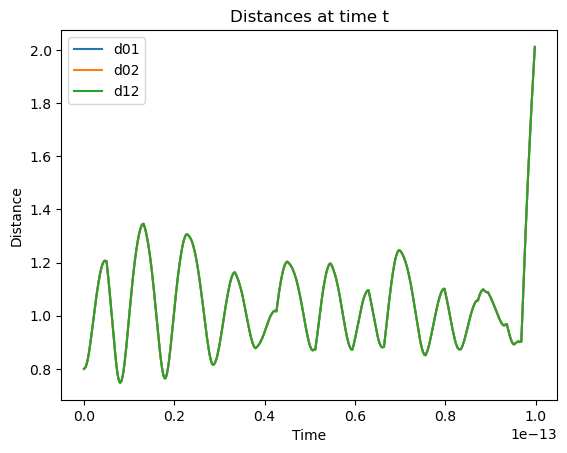

In [4]:
from matplotlib import pyplot as plt
(distance01,distance02,distance12,times) = main()

np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)

plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')

plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()